In [1]:
import json
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd
import pyarrow as pa
import pyarrow.csv as pv
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
df= pd.read_csv('mtavisualise.csv')

In [3]:
df.shape

(1435991, 30)

In [4]:
df.columns

Index(['transit_timestamp', 'station_complex', 'routes', 'latitude',
       'longitude', '1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E',
       'F', 'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'W', 'Z', 'date', 'time',
       'timeslots'],
      dtype='object')

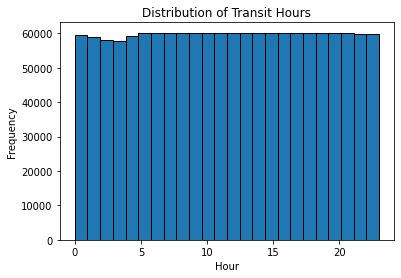

In [5]:
# Convert 'transit_timestamp' column to datetime
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

# Extract hour from 'transit_timestamp'
df['hour'] = df['transit_timestamp'].dt.hour

# Plot histogram
plt.hist(df['hour'], bins=24, edgecolor='black')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Distribution of Transit Hours')
plt.show()


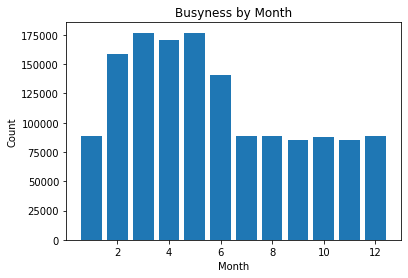

In [6]:
# Extract month from transit_timestamp
df['month'] = df['transit_timestamp'].dt.month

# Count the occurrences of each month
month_counts = df['month'].value_counts().sort_index()

# Plot bar chart
plt.bar(month_counts.index, month_counts.values)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Busyness by Month')
plt.show()

In [7]:

# cal = calendar()
# holidays = cal.holidays(start='2022-01-01', end='2022-12-31')
# df['holiday'] = df['date'].isin(holidays)

In [8]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create a US federal holiday calendar
cal = USFederalHolidayCalendar()

# Generate a list of holidays within the specified date range
holidays = cal.holidays(start='2022-01-01', end='2022-12-31')


# Check if each date is a holiday
df['holiday'] = df['transit_timestamp'].isin(holidays)

# Print the updated DataFrame
print(df[['date', 'holiday']])


               date  holiday
0        2023-01-24    False
1        2022-09-05    False
2        2022-05-08    False
3        2022-05-03    False
4        2023-01-28    False
...             ...      ...
1435986  2022-10-29    False
1435987  2023-01-27    False
1435988  2022-07-15    False
1435989  2023-02-27    False
1435990  2022-11-30    False

[1435991 rows x 2 columns]


In [9]:
# Assuming you have a DataFrame called 'df' with a 'holiday' column
holiday_counts = df['holiday'].value_counts()
true_count = holiday_counts.get(True, 0)

print("Number of true values in 'holiday' column:", true_count)


Number of true values in 'holiday' column: 1068


In [10]:
import pandas as pd

# Convert 'pickup_date' to datetime-like object
df['date'] = pd.to_datetime(df['date'])

# Create separate columns for each day of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df[days] = pd.get_dummies(df['date'].dt.day_name())[days]

# Assign day types (weekday/weekend)
df['day_type'] = df[['Saturday', 'Sunday']].apply(lambda row: 'weekend' if row.any() else 'weekday', axis=1)

# Drop the original 'pickup_date' column
df = df.drop('date', axis=1)

In [11]:
import pandas as pd

# Create a new 'day' column representing the day of the week
df['day'] = df['transit_timestamp'].dt.day_name()

# Print the updated DataFrame
print(df[['day_type', 'day']])



        day_type        day
0        weekday    Tuesday
1        weekday     Monday
2        weekend     Sunday
3        weekday    Tuesday
4        weekend   Saturday
...          ...        ...
1435986  weekend   Saturday
1435987  weekday     Friday
1435988  weekday     Friday
1435989  weekday     Monday
1435990  weekday  Wednesday

[1435991 rows x 2 columns]


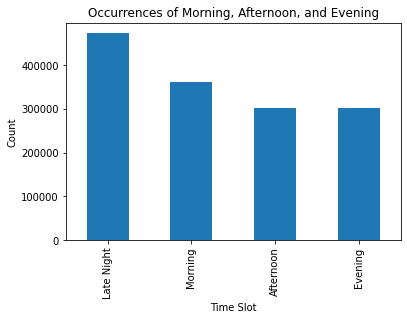

In [12]:

# Count the occurrences of each time slot
time_slot_counts = df['timeslots'].value_counts()

# Plot bar chart
time_slot_counts.plot(kind='bar')
plt.xlabel('Time Slot')
plt.ylabel('Count')
plt.title('Occurrences of Morning, Afternoon, and Evening')
plt.show()

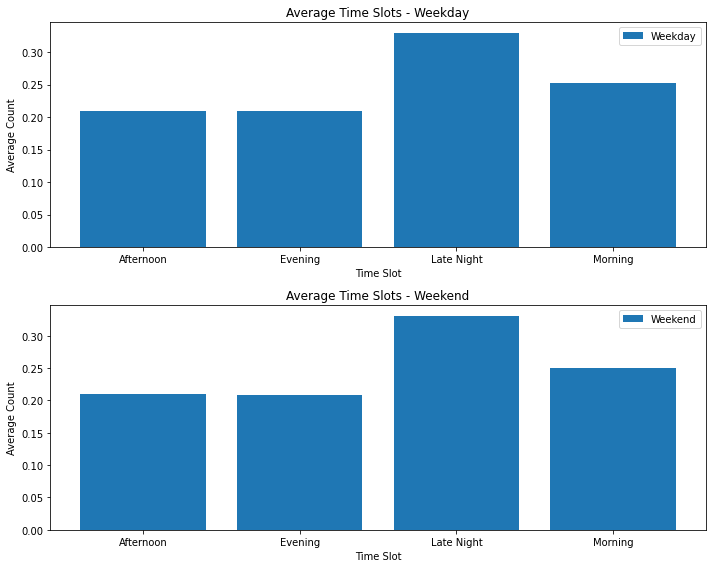

In [13]:
# Group the data by day and calculate the average time slot
average_timeslots = df.groupby('day_type')['timeslots'].value_counts(normalize=True).unstack()

# Plot bar charts for average time slots for each day type
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot weekday average time slots
axes[0].bar(average_timeslots.columns, average_timeslots.loc['weekday'], label='Weekday')
axes[0].set_xlabel('Time Slot')
axes[0].set_ylabel('Average Count')
axes[0].set_title('Average Time Slots - Weekday')
axes[0].legend()

# Plot weekend average time slots
axes[1].bar(average_timeslots.columns, average_timeslots.loc['weekend'], label='Weekend')
axes[1].set_xlabel('Time Slot')
axes[1].set_ylabel('Average Count')
axes[1].set_title('Average Time Slots - Weekend')
axes[1].legend()

plt.tight_layout()
plt.show()

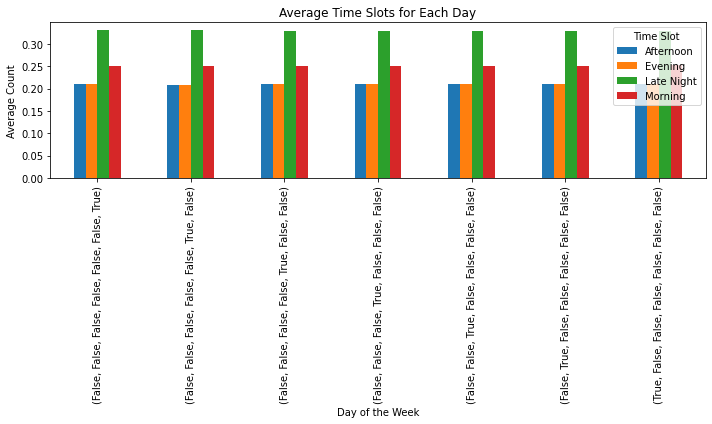

In [14]:
# Group the data by each day of the week and calculate the average time slot
average_timeslots = df.groupby(days)['timeslots'].value_counts(normalize=True).unstack()

# Plot bar charts for average time slots for each day
fig, ax = plt.subplots(figsize=(10, 6))

# Plot average time slots for each day
average_timeslots.plot(kind='bar', ax=ax)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Count')
ax.set_title('Average Time Slots for Each Day')

plt.legend(title='Time Slot')
plt.tight_layout()
plt.show()

In [15]:
# # Assuming your dataset is stored in a DataFrame called 'df'
# # Filter the data for weekdays
# weekday_data = df[df['day_type'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

# # Grouping the weekday data by 'station_complex', 'hour', and 'day_type'
# grouped_data = weekday_data.groupby(['station_complex', 'hour'])

# # Calculating the average row count for each group
# result = grouped_data.size().groupby('station_complex').mean().reset_index(name='avg_count')

# # Iterate over unique station complexes
# for station_complex in result['station_complex'].unique():
#     # Filter the data for the current station complex
#     complex_data = result[result['station_complex'] == station_complex]

#     # Create a line chart for the current station complex
#     plt.figure(figsize=(10, 6))
#     plt.plot(complex_data['hour'], complex_data['avg_count'], marker='o')
#     plt.xlabel('Hour')
#     plt.ylabel('Average Count')
#     plt.title(f'Average Busyness of {station_complex} by Hour on Weekdays')

#     # Display the chart
#     plt.show()

In [16]:
df.columns

Index(['transit_timestamp', 'station_complex', 'routes', 'latitude',
       'longitude', '1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E',
       'F', 'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'W', 'Z', 'time', 'timeslots',
       'hour', 'month', 'holiday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'day_type', 'day'],
      dtype='object')

In [17]:
# Check the data type of 'transit_timestamp'
print(df['transit_timestamp'].dtype)

# Check the data type of 'hour'
print(df['hour'].dtype)


datetime64[ns]
int32


In [18]:
# Check unique 'day_type' values
print(df['day_type'].unique())


['weekday' 'weekend']


In [19]:
# Check unique 'station_complex' values
print(df['station_complex'].unique())

# Check the range of 'hour' values
print(df['hour'].min(), df['hour'].max())


['103 St (6)' '103 St (1)' '1 Av (L)' '103 St (B,C)' '110 St (6)'
 '116 St (2,3)' '116 St-Columbia University (1)' '116 St (6)'
 '116 St (B,C)' '125 St (1)' '125 St (2,3)' '135 St (2,3)'
 '125 St (A,B,C,D)' '125 St (4,5,6)' '137 St-City College (1)'
 '135 St (B,C)' '14 St (F,M,1,2,3)/6 Av (L)' '14 St (A,C,E)/8 Av (L)'
 '145 St (1)' '145 St (3)' '14 St-Union Sq (L,N,Q,R,W,4,5,6)'
 '145 St (A,B,C,D)' '155 St (C)' '155 St (B,D)' '157 St (1)'
 '163 St-Amsterdam Av (C)' '168 St (A,C,1)' '175 St (A)' '181 St (1)'
 '18 St (1)' '181 St (A)' '2 Av (F)' '191 St (1)' '190 St (A)'
 '207 St (1)' '215 St (1)' '23 St (1)' '23 St (C,E)' '23 St (6)'
 '23 St (F,M)' '23 St (R,W)' '28 St (6)' '28 St (1)' '3 Av (L)'
 '28 St (R,W)' '33 St (6)' '34 St-Hudson Yards (7)'
 '34 St-Herald Sq (B,D,F,M,N,Q,R,W)' '34 St-Penn Station (A,C,E)'
 '34 St-Penn Station (1,2,3)' '49 St (N,R,W)'
 '47-50 Sts-Rockefeller Center (B,D,F,M)' '5 Av-53 St (E,M)' '50 St (1)'
 '5 Av-59 St (N,R,W)' '50 St (C,E)' '57 St (F)'
 '59 St-Co

In [20]:
df.columns

Index(['transit_timestamp', 'station_complex', 'routes', 'latitude',
       'longitude', '1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E',
       'F', 'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'W', 'Z', 'time', 'timeslots',
       'hour', 'month', 'holiday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'day_type', 'day'],
      dtype='object')

                                       station_complex   avg_count
0                                             1 Av (L)  359.375000
1                                           103 St (1)  359.458333
2                                           103 St (6)  359.375000
3                                         103 St (B,C)  355.875000
4                                           110 St (6)  359.625000
..                                                 ...         ...
115  Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...  360.041667
116                                  WTC Cortlandt (1)  358.625000
117                                      Wall St (2,3)  354.791667
118                                      Wall St (4,5)  356.166667
119            West 4 St-Washington Sq (A,B,C,D,E,F,M)  360.041667

[120 rows x 2 columns]


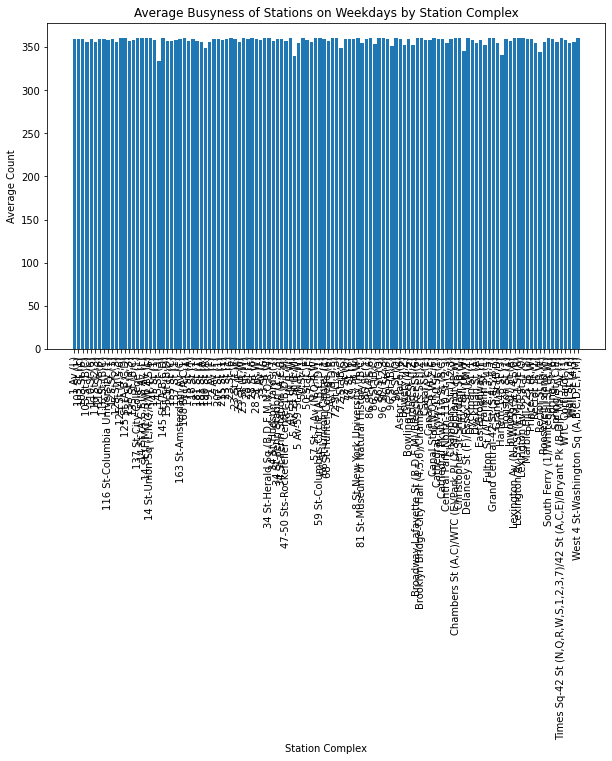

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a DataFrame called 'df'
# Filtering the data for weekdays
weekday_data = df[df['day_type'].isin(['weekday'])]

# Grouping the weekday data by 'station_complex' and 'hour'
grouped_data = weekday_data.groupby(['station_complex', 'hour'])

# Calculating the average count of rows for each group
result = grouped_data.size().groupby(['station_complex']).mean().reset_index(name='avg_count')

# Print the intermediate results
print(result)

# Creating a bar chart
plt.figure(figsize=(10, 6))
plt.bar(result['station_complex'], result['avg_count'])
plt.xlabel('Station Complex')
plt.ylabel('Average Count')
plt.title('Average Busyness of Stations on Weekdays by Station Complex')
plt.xticks(rotation=90)

# Displaying the chart
plt.show()



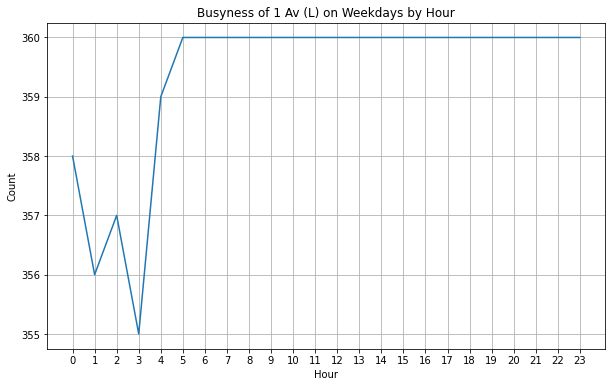

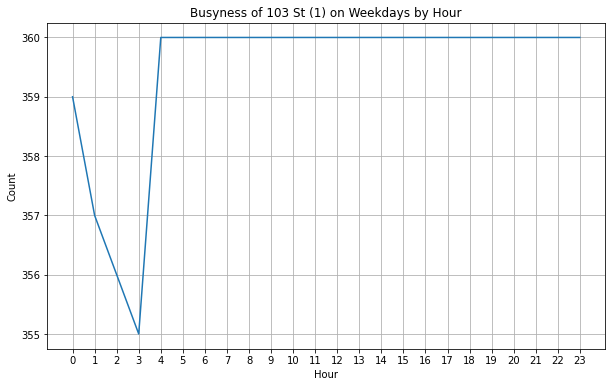

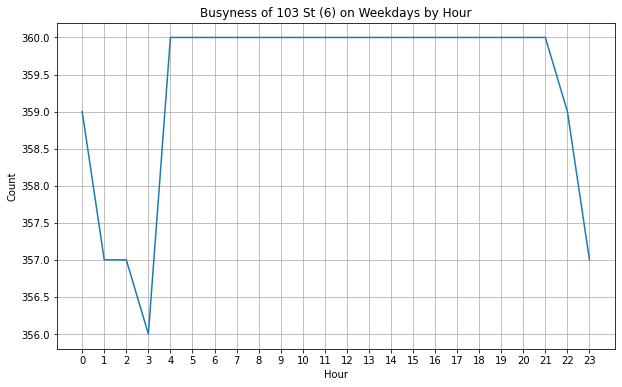

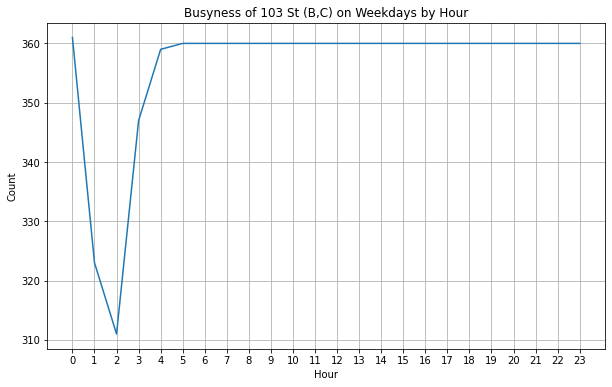

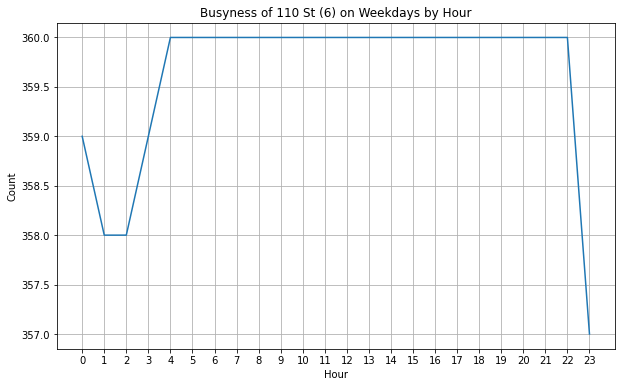

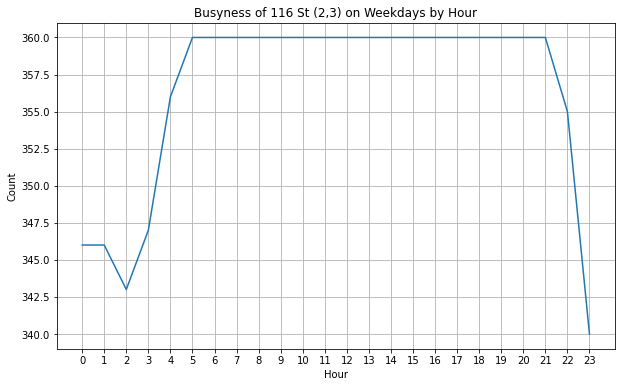

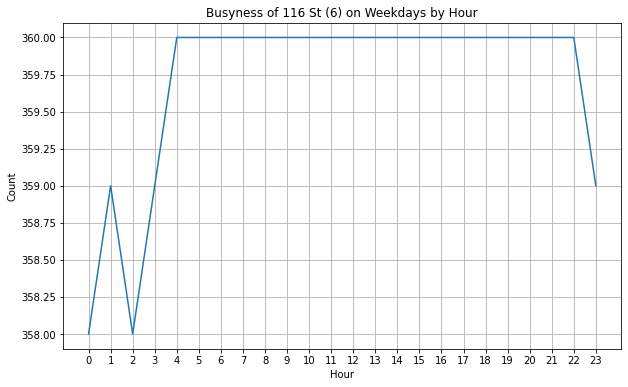

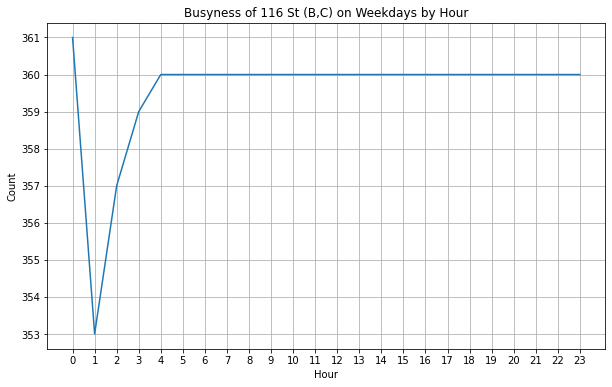

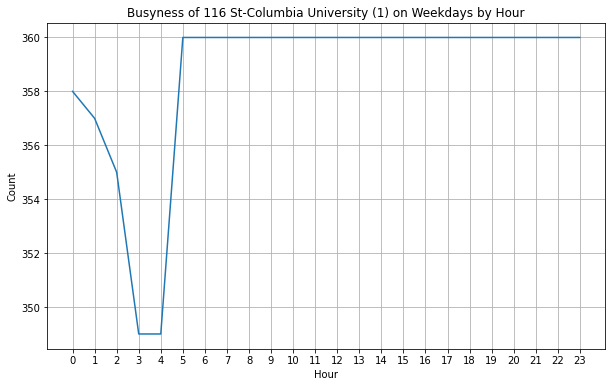

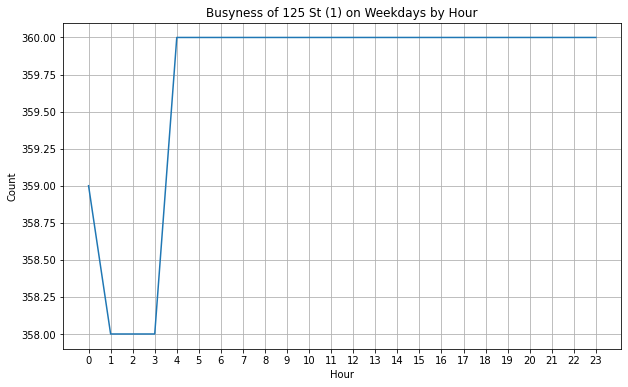

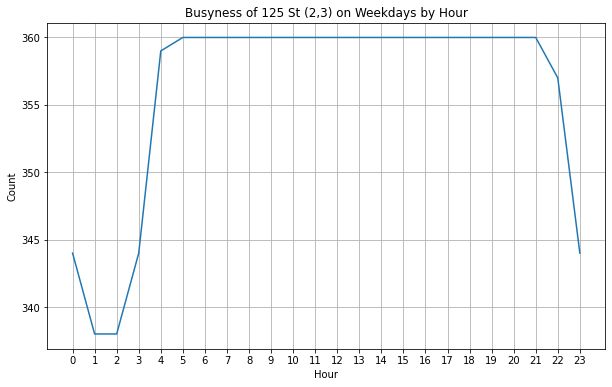

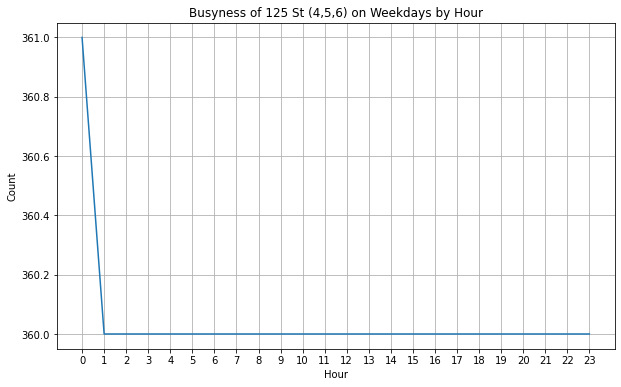

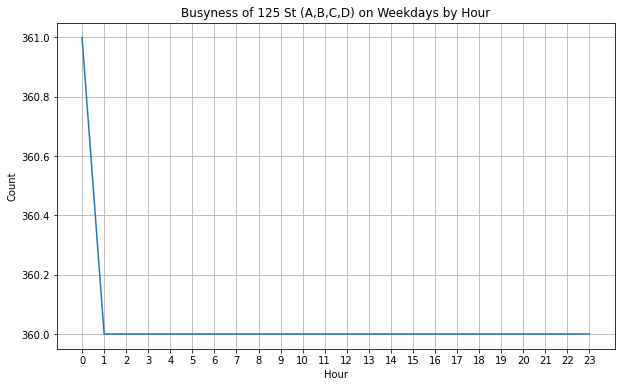

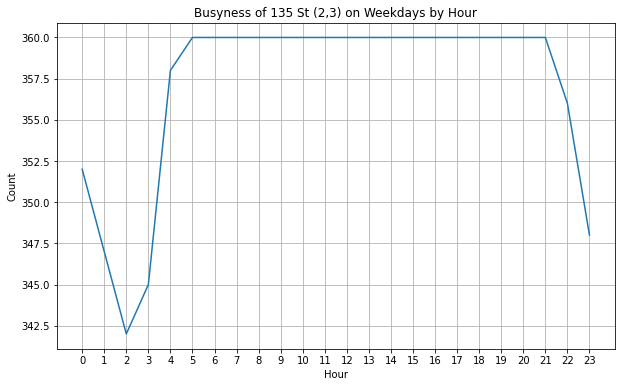

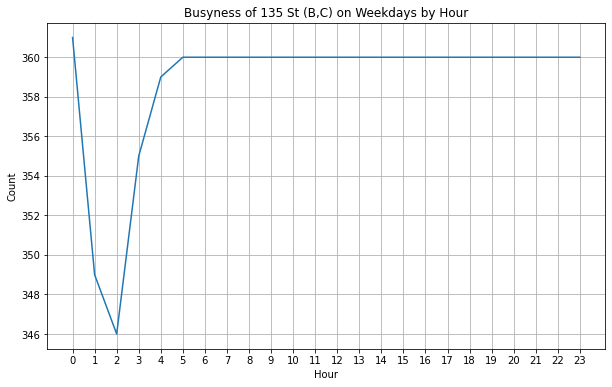

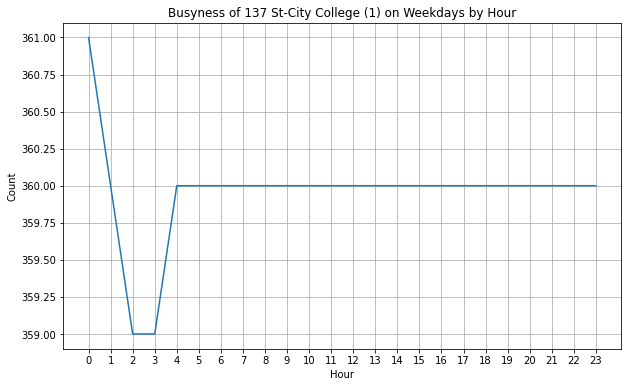

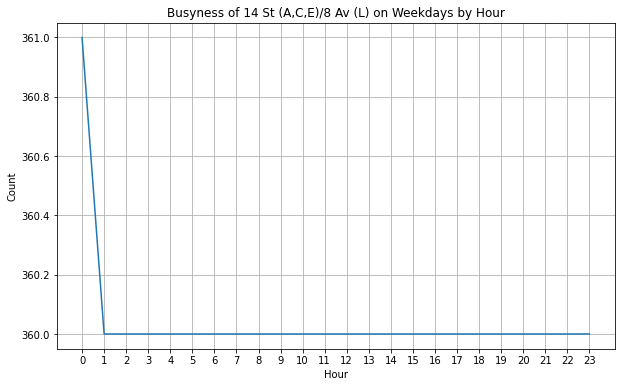

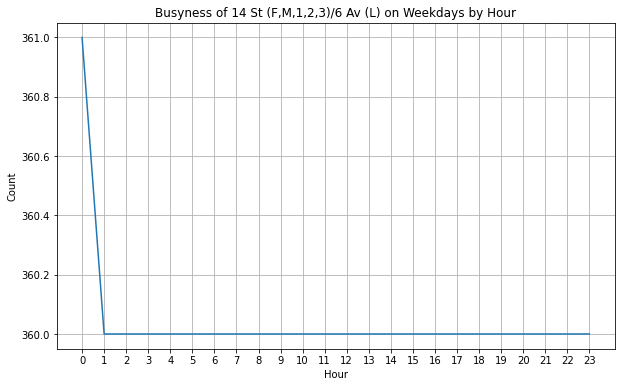

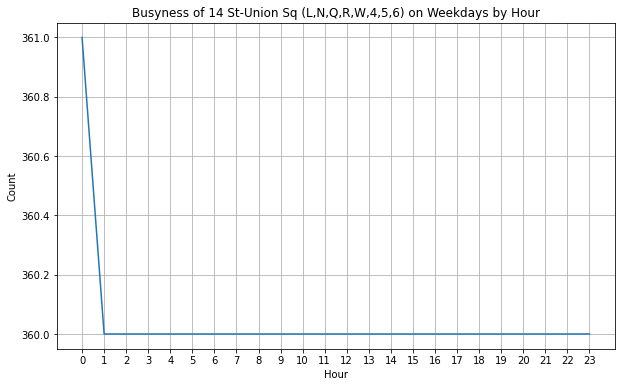

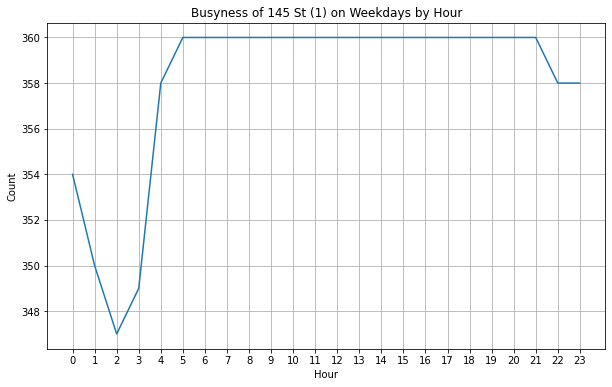

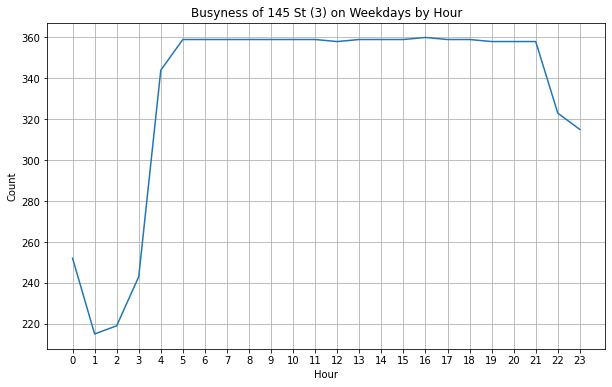

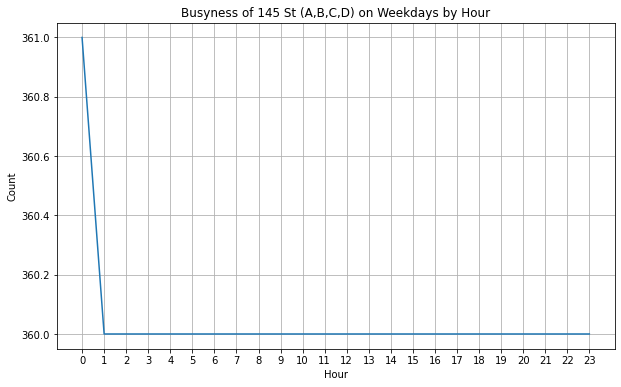

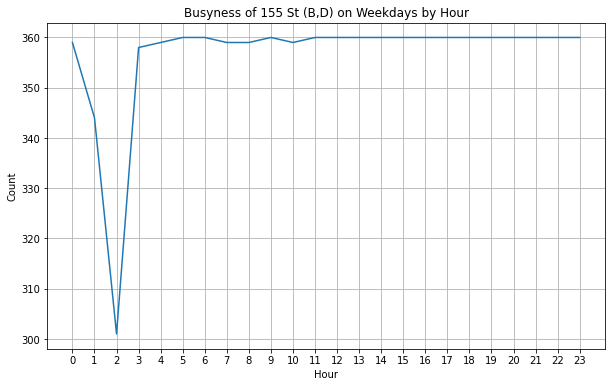

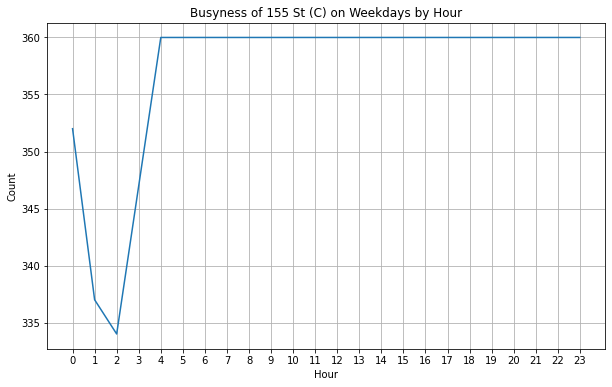

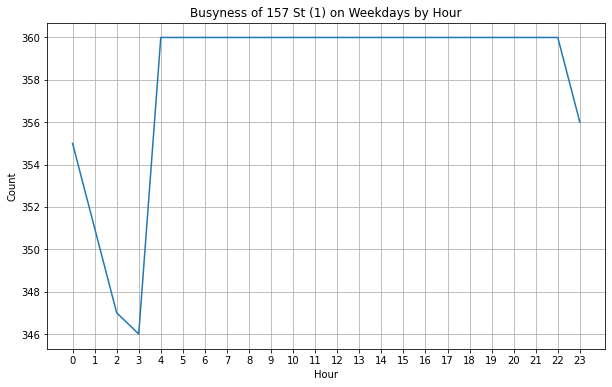

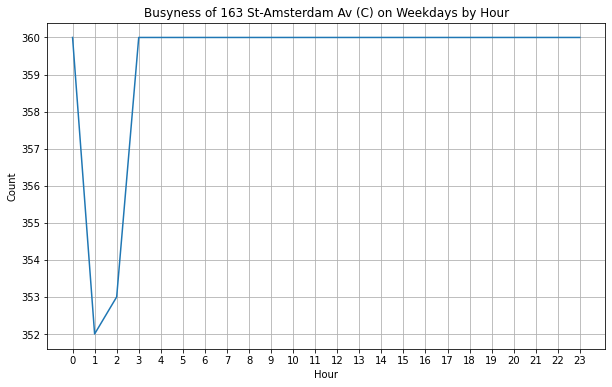

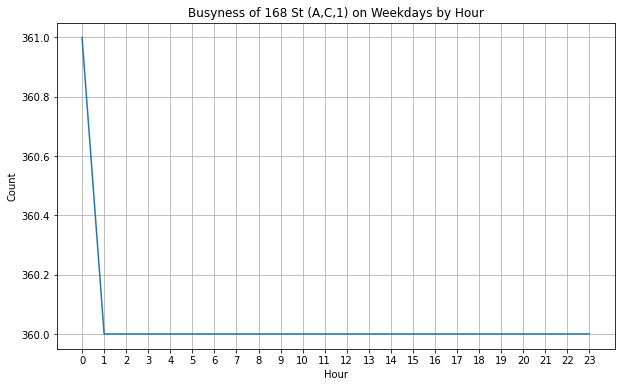

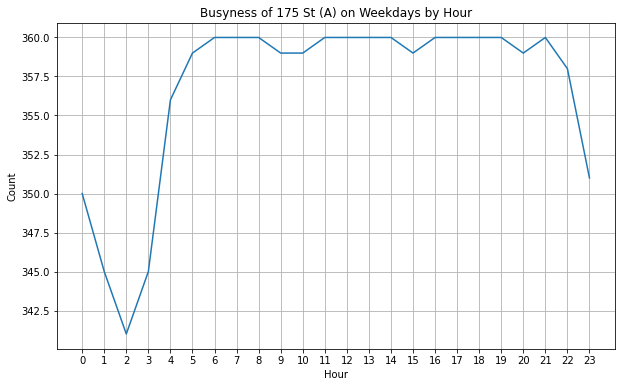

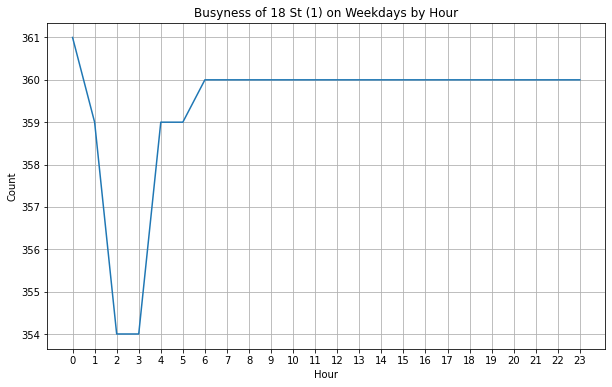

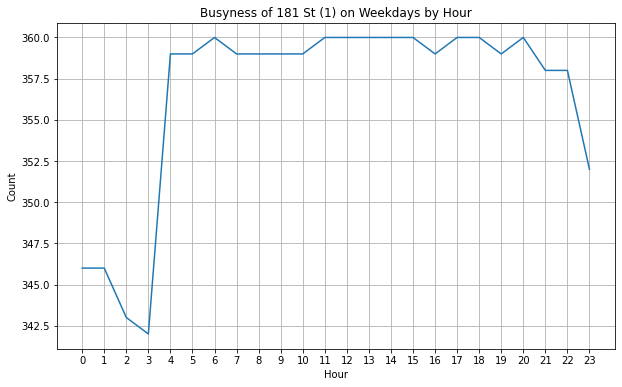

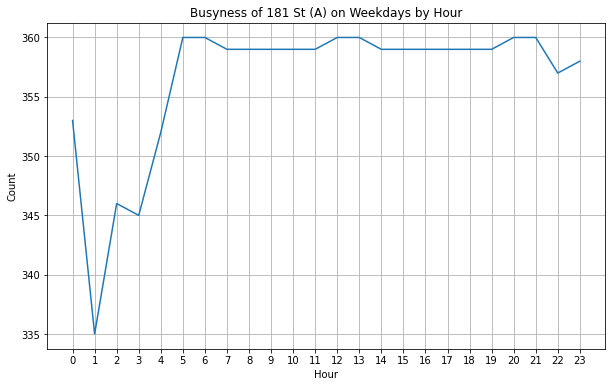

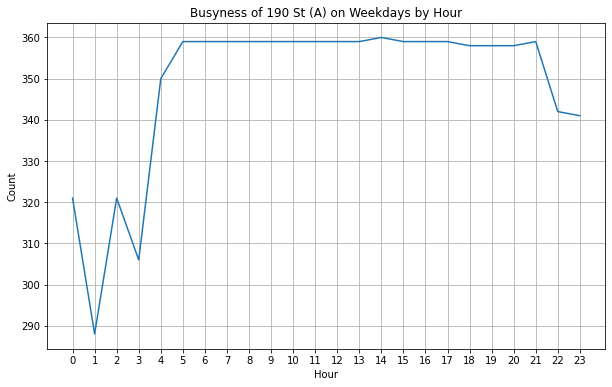

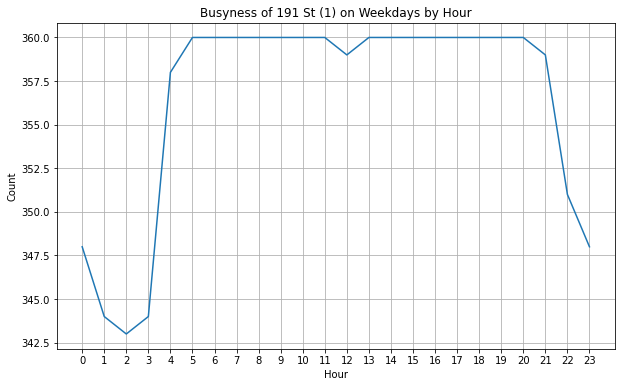

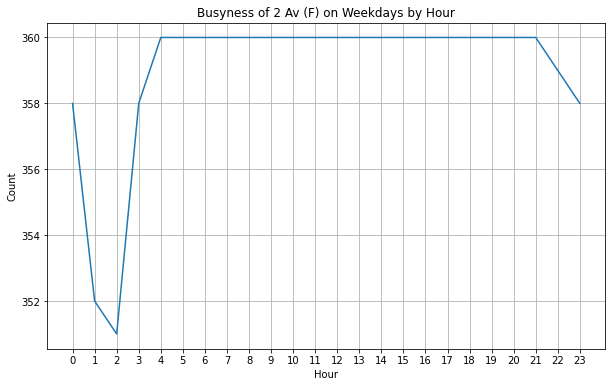

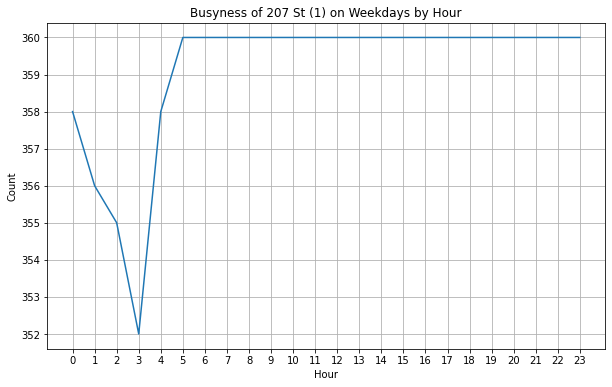

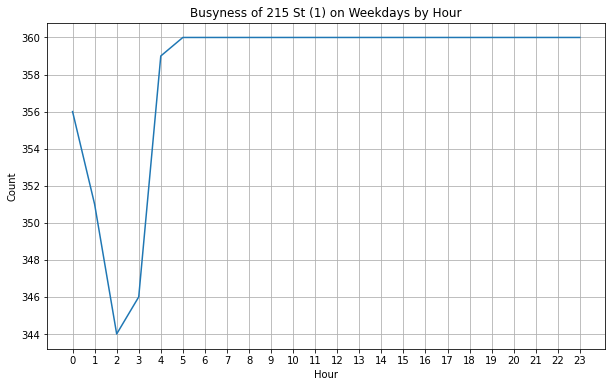

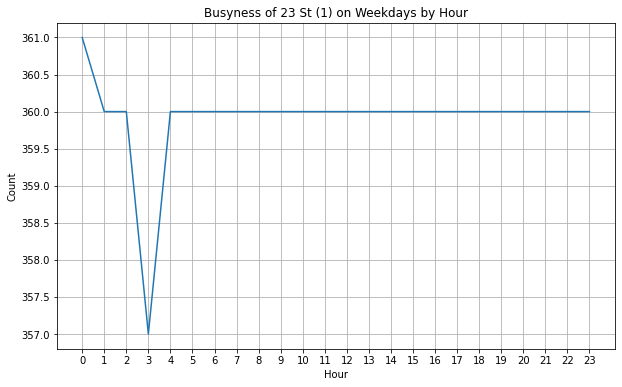

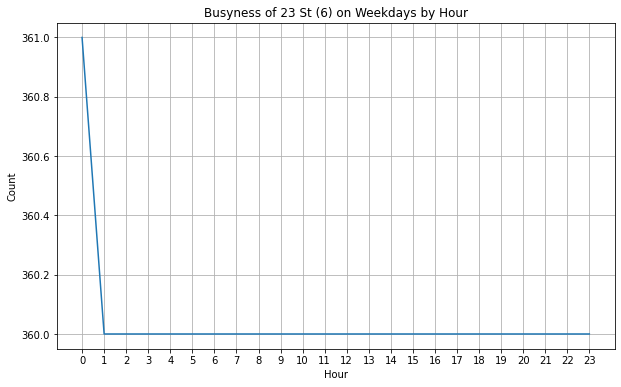

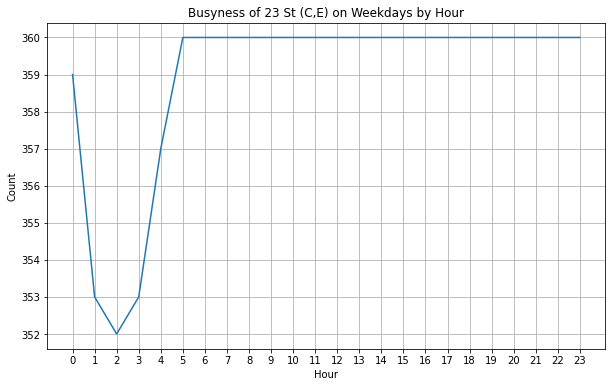

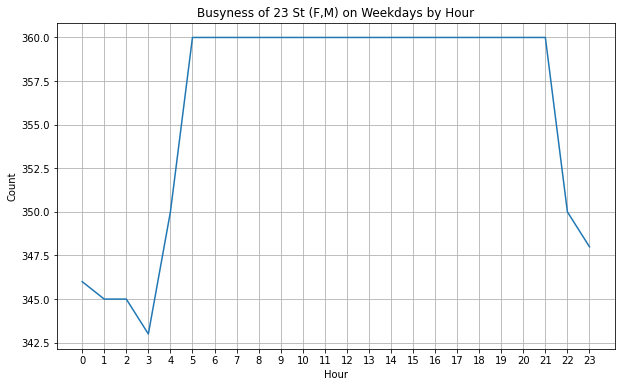

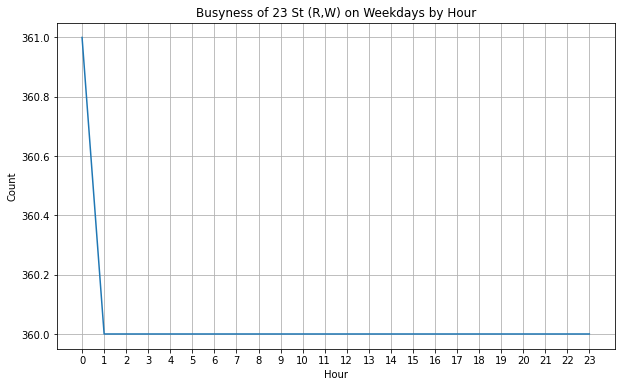

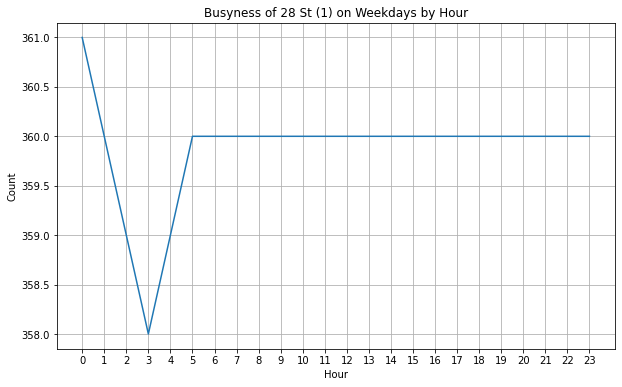

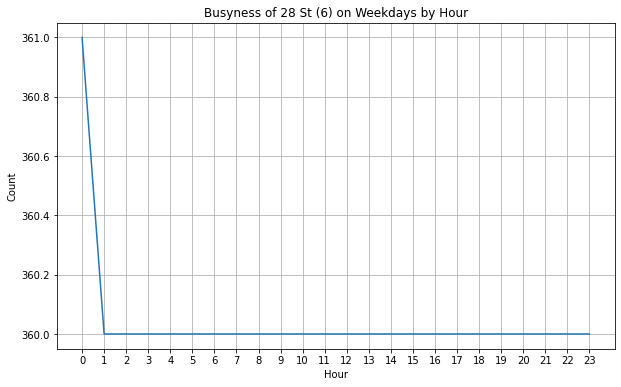

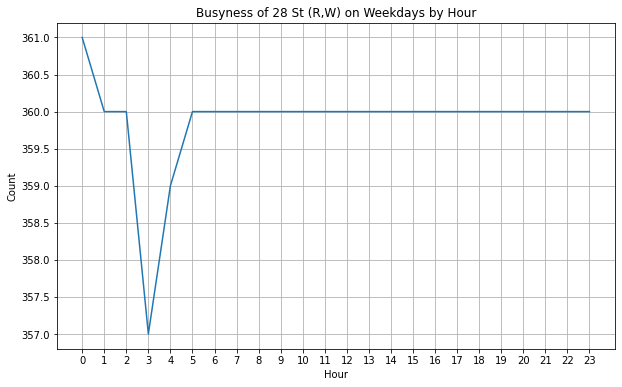

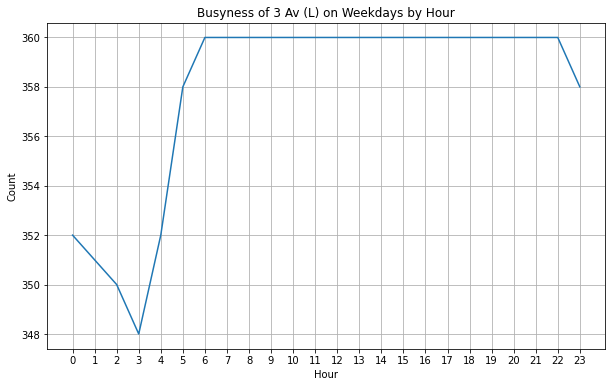

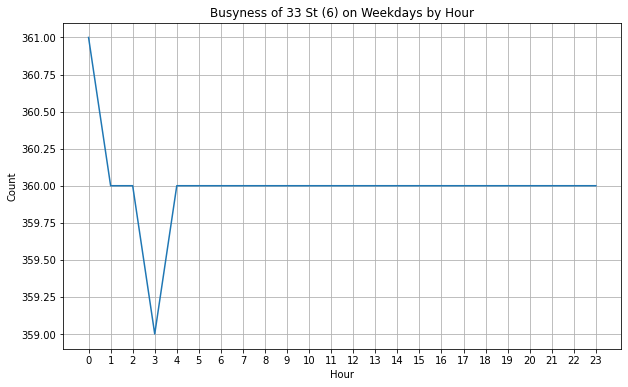

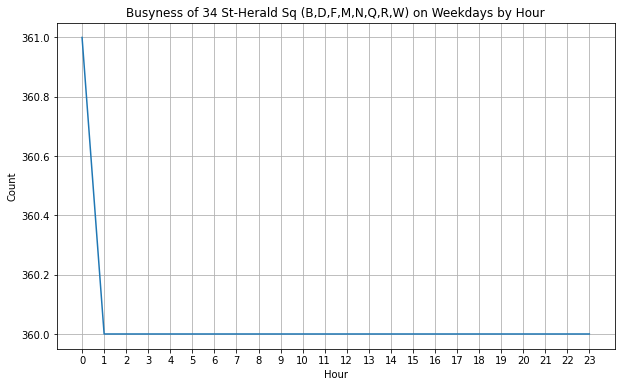

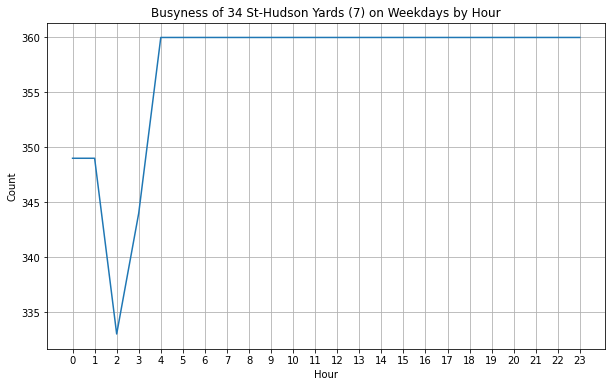

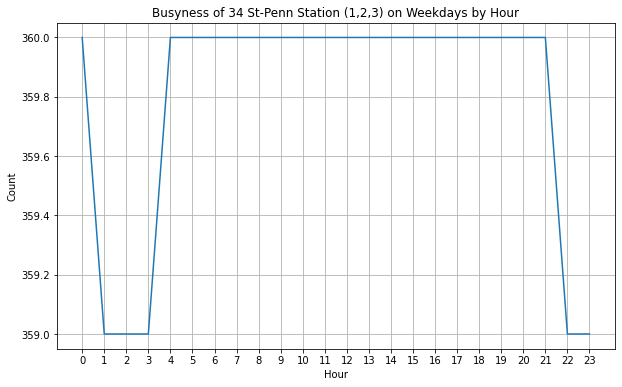

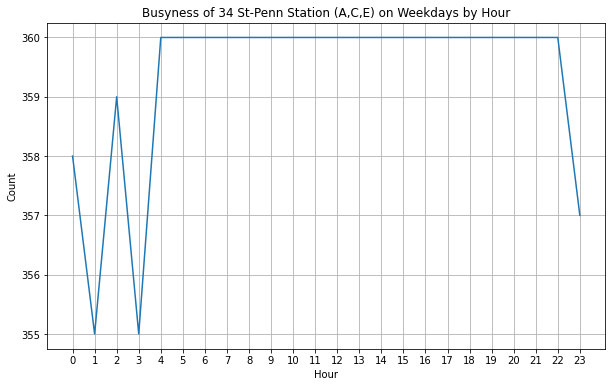

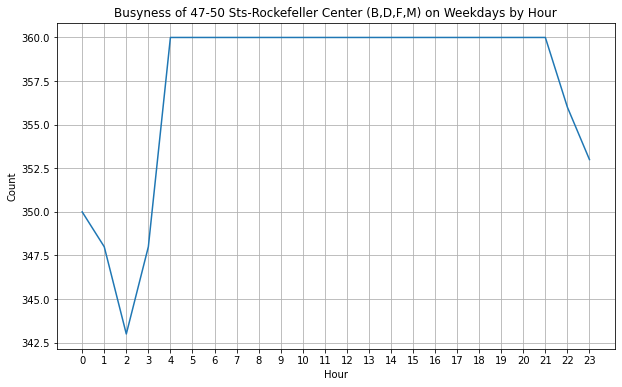

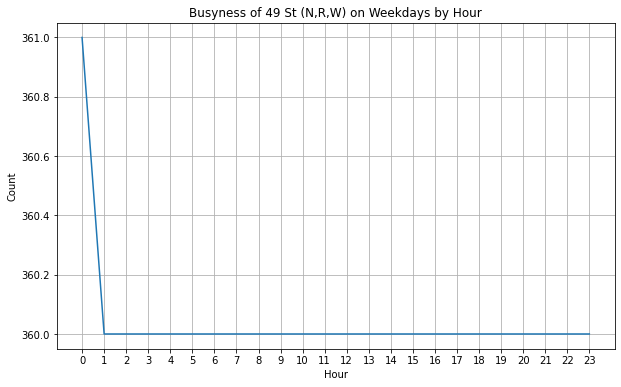

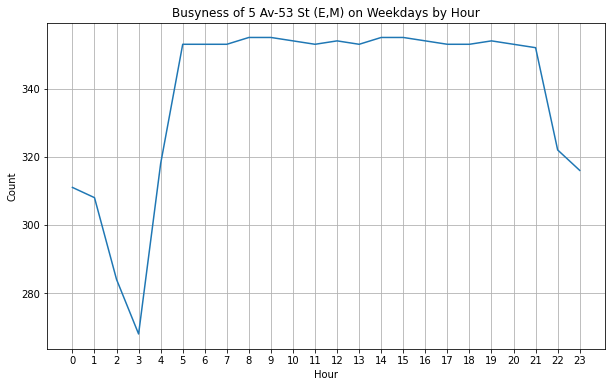

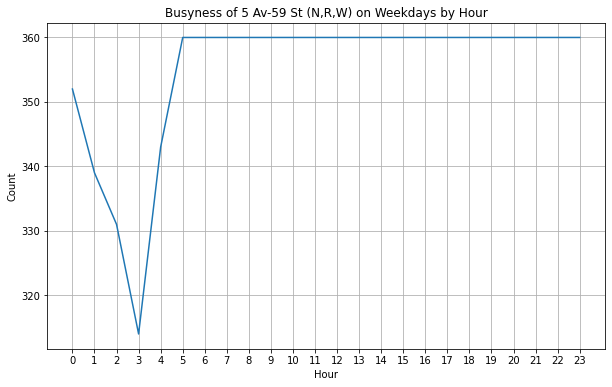

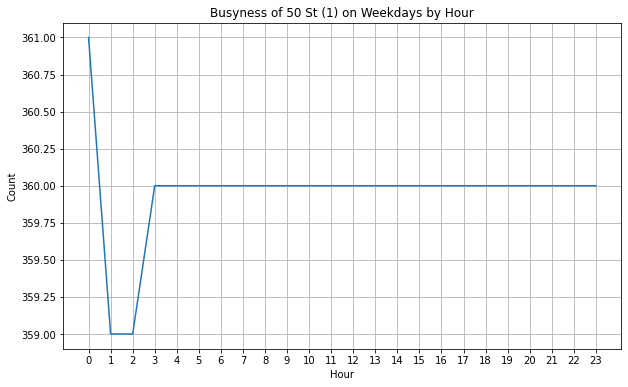

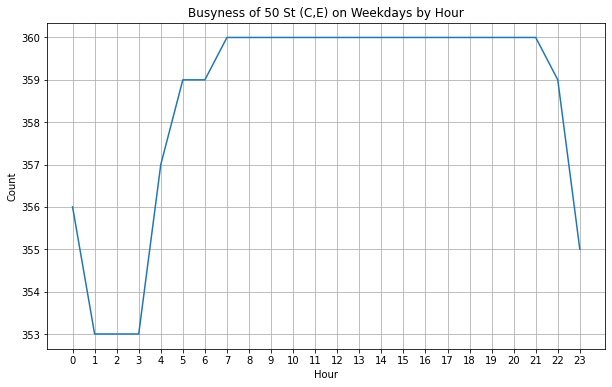

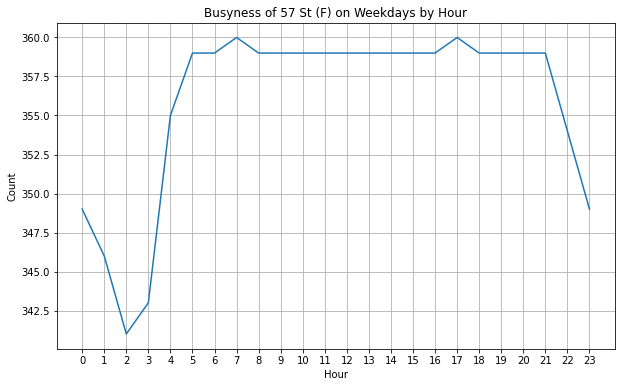

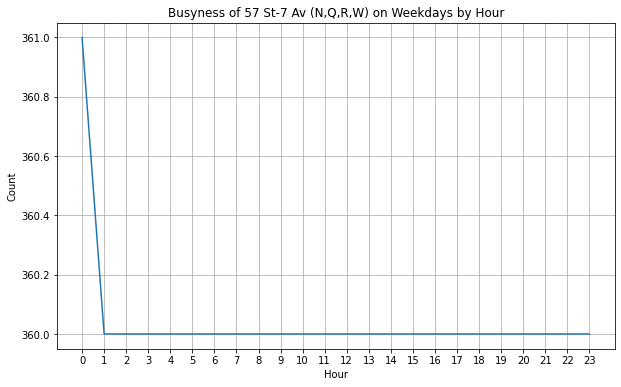

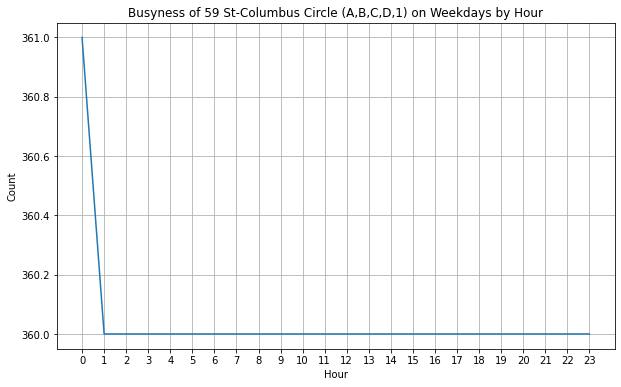

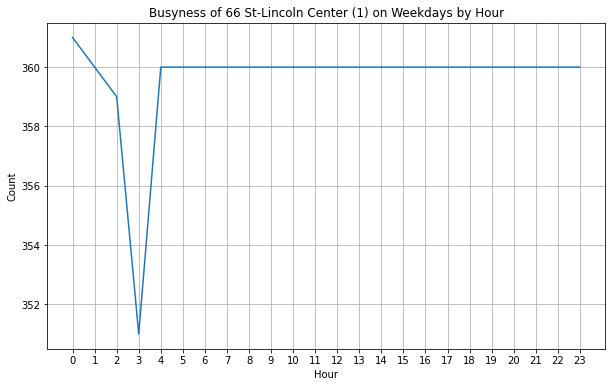

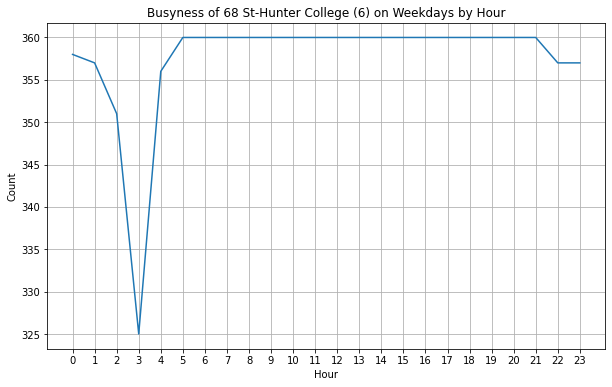

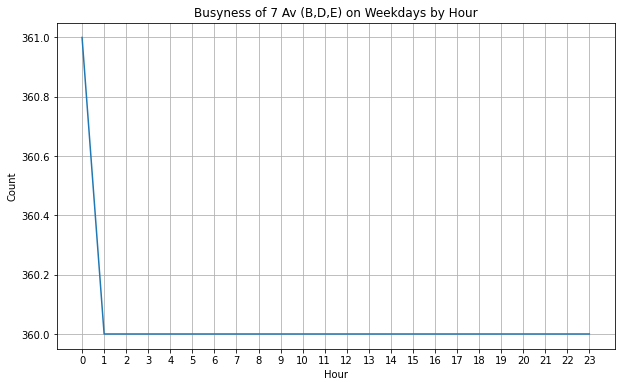

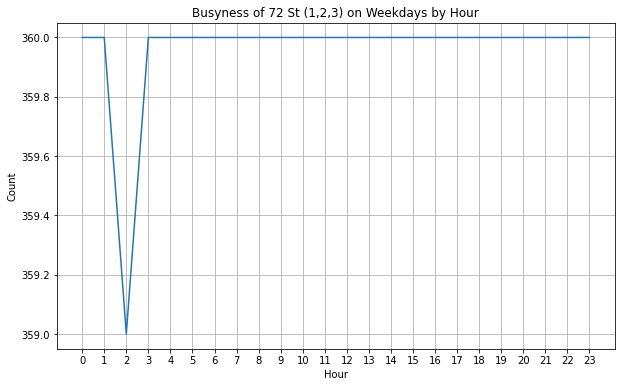

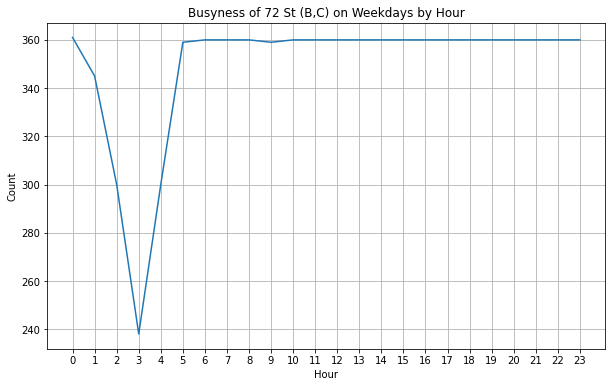

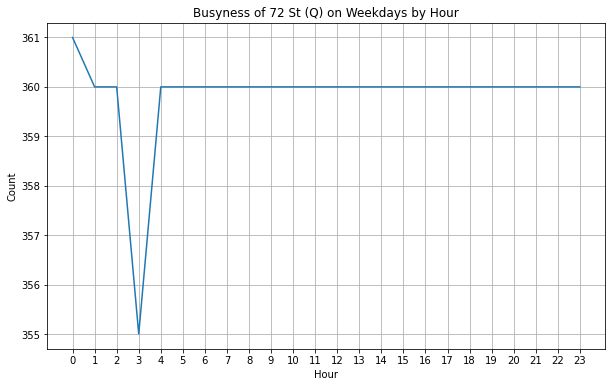

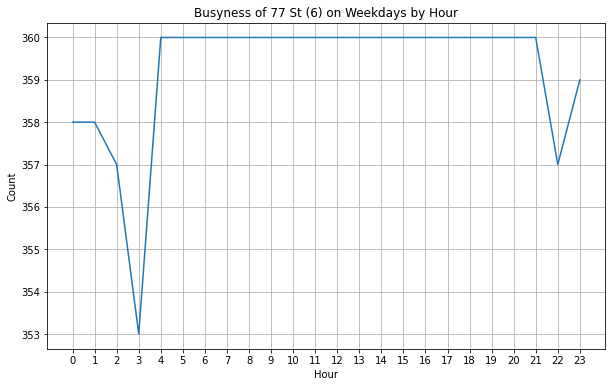

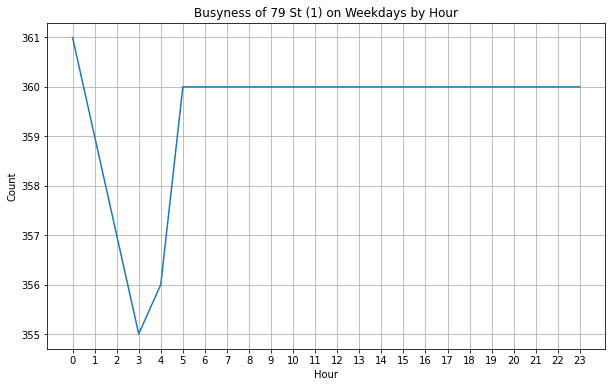

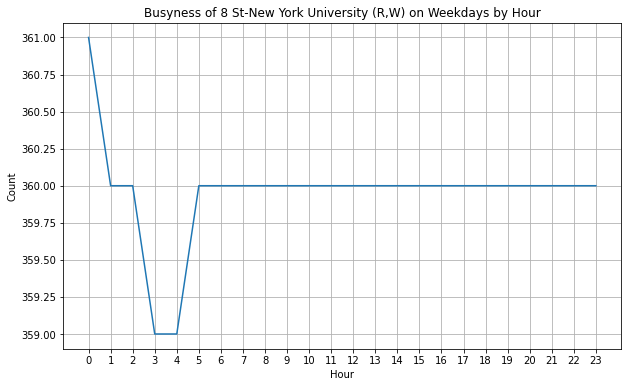

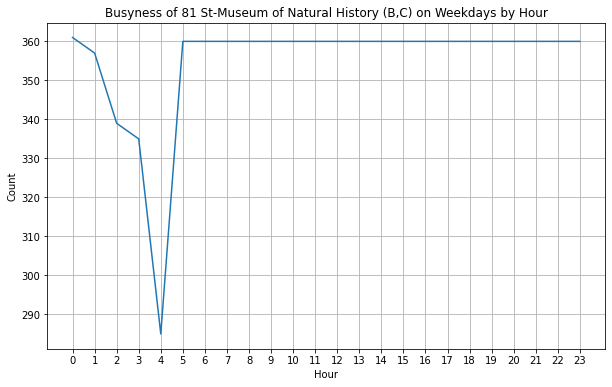

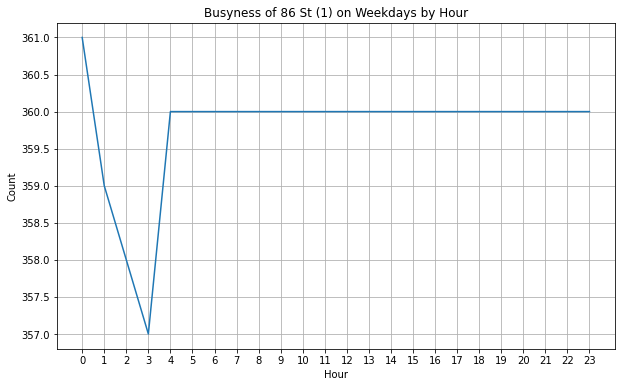

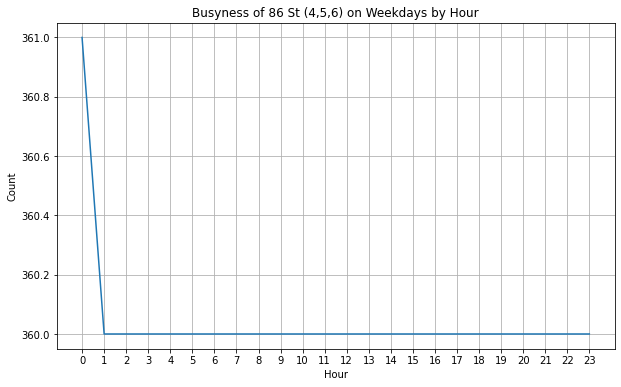

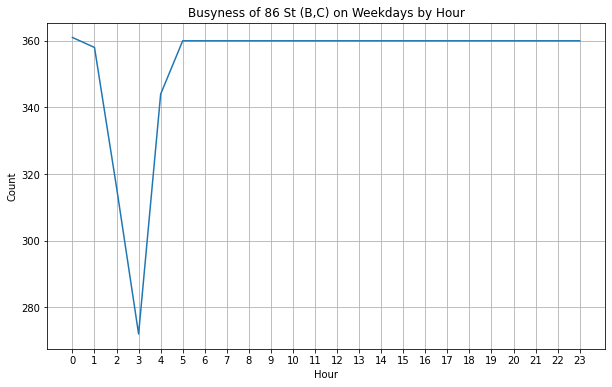

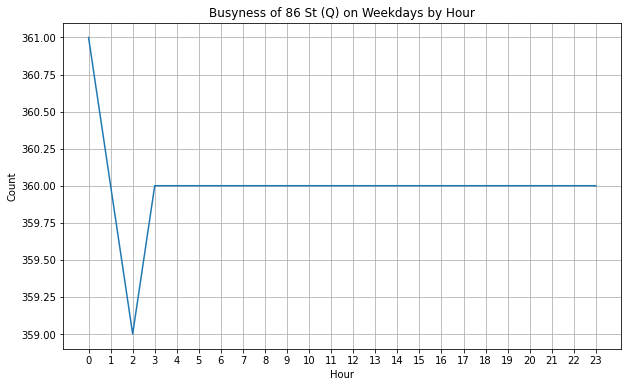

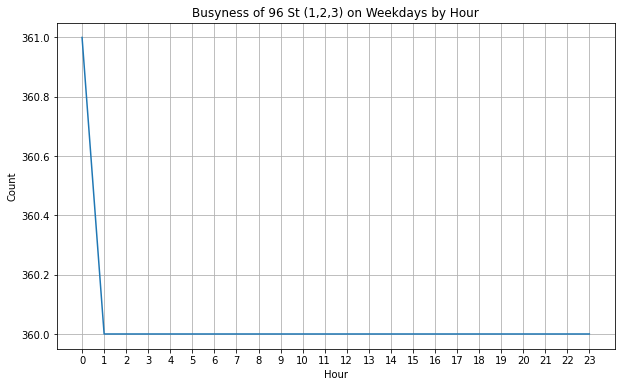

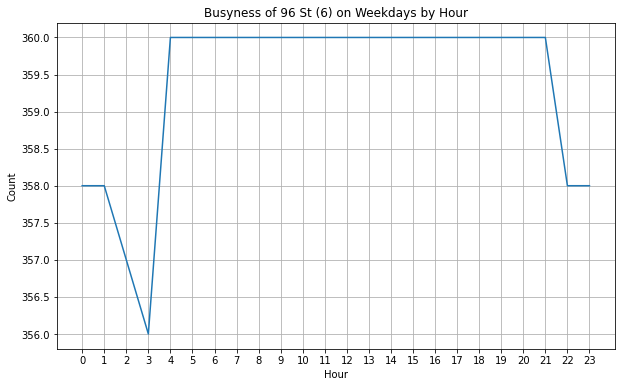

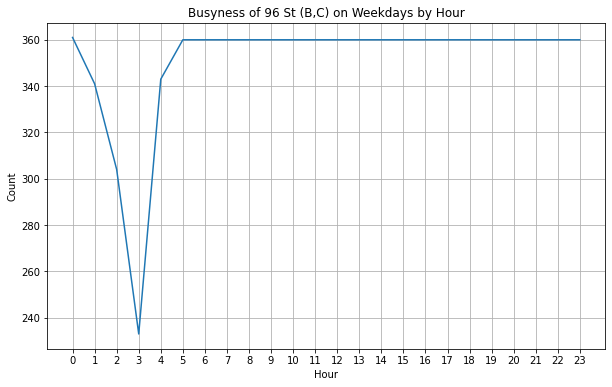

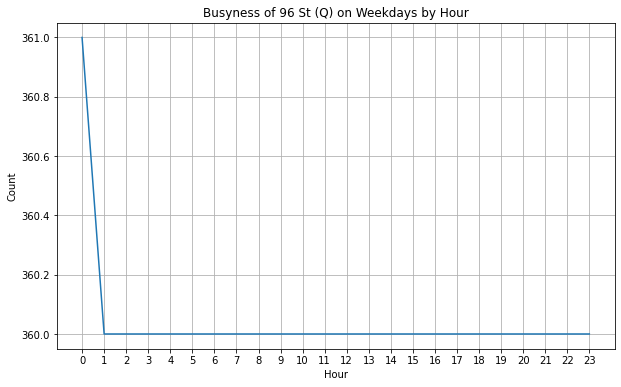

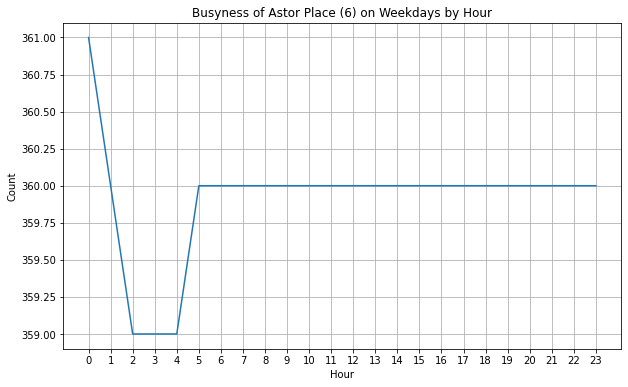

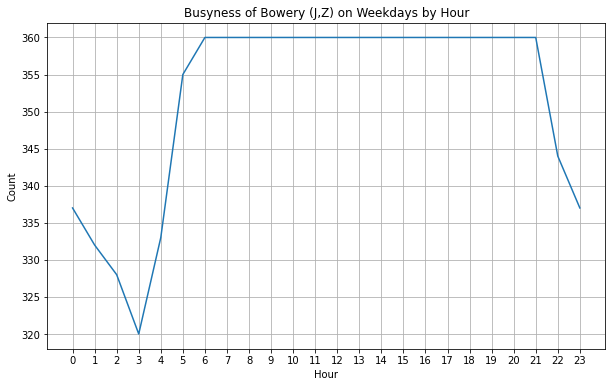

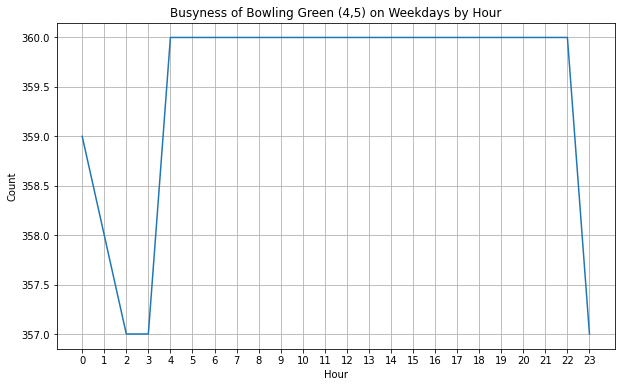

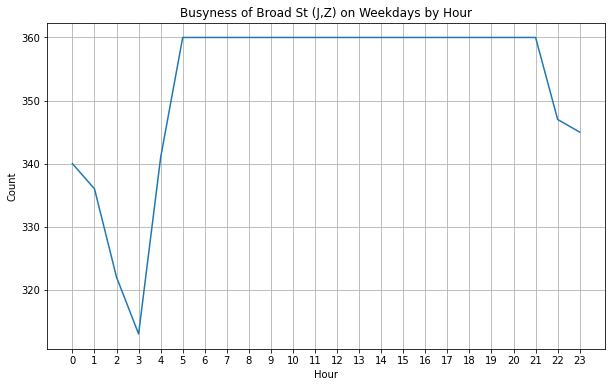

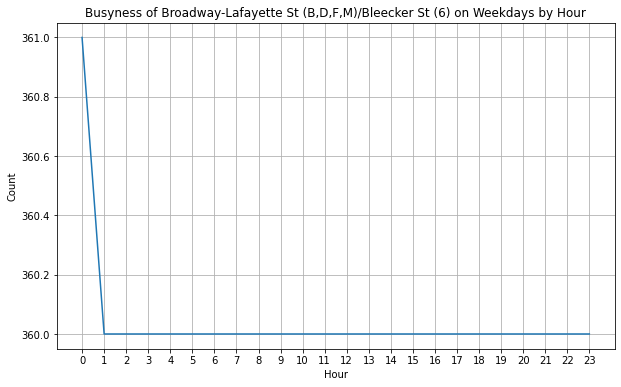

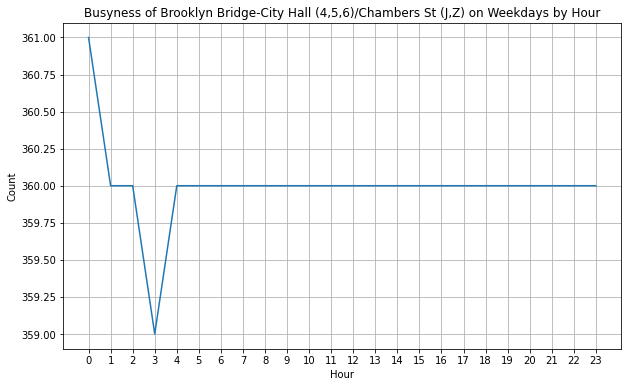

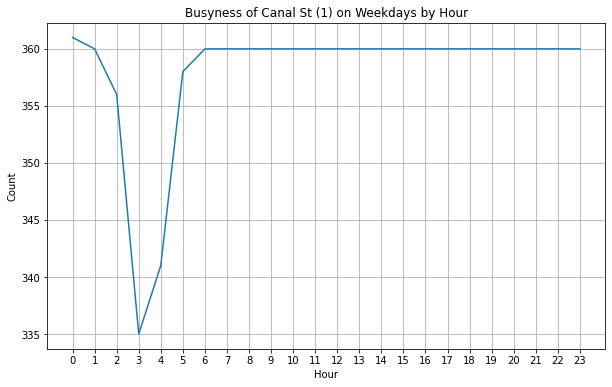

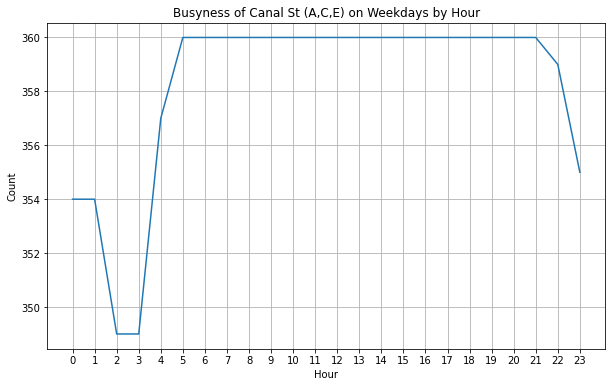

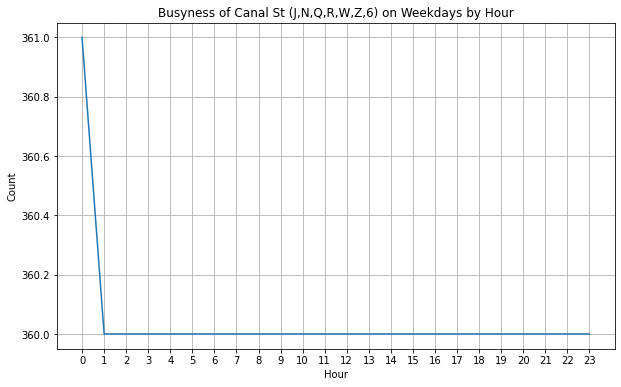

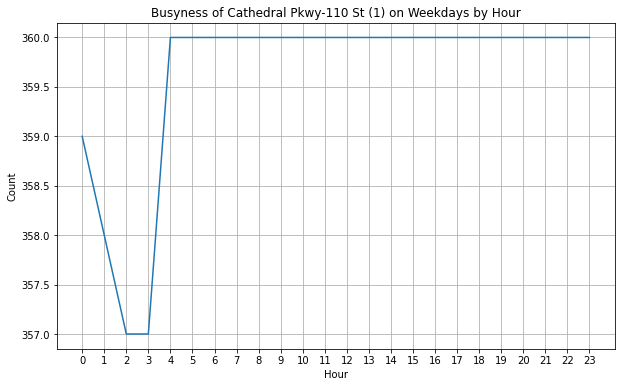

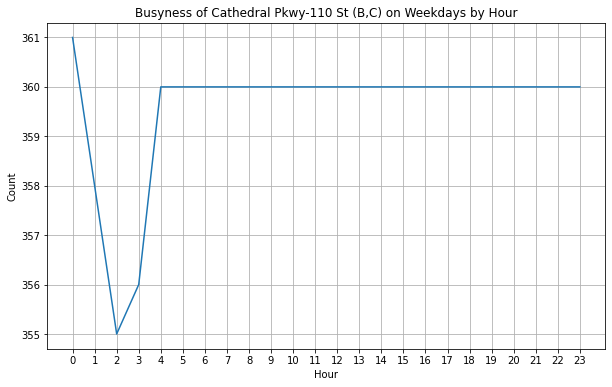

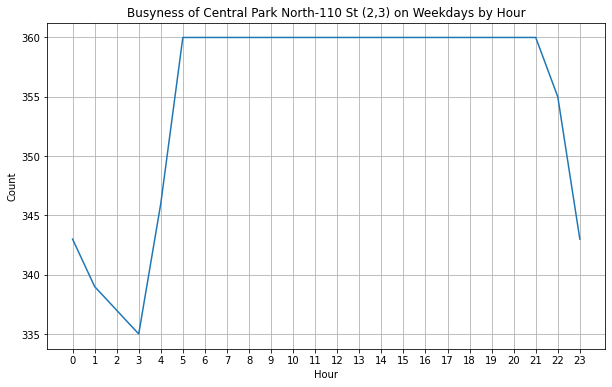

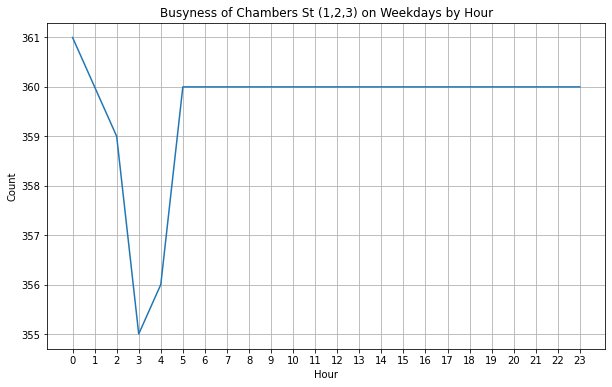

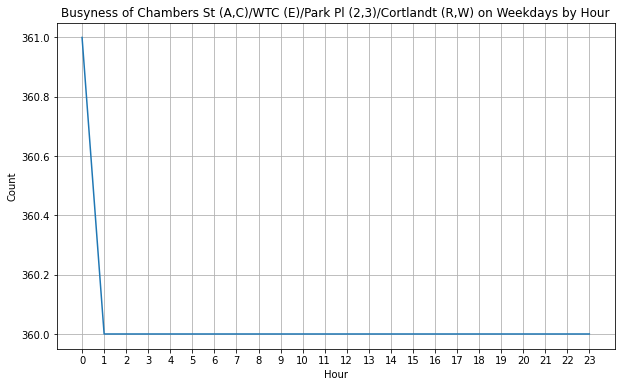

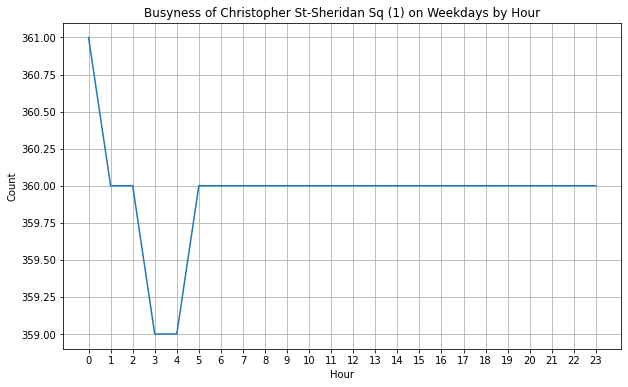

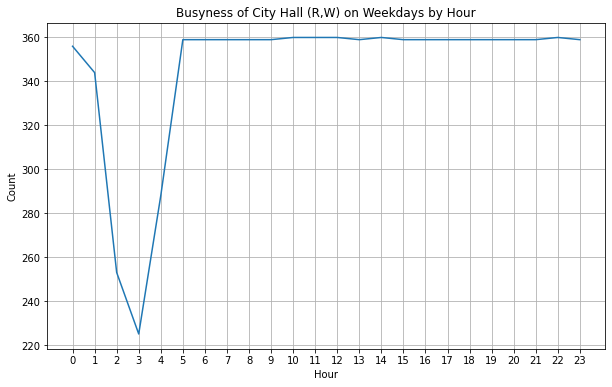

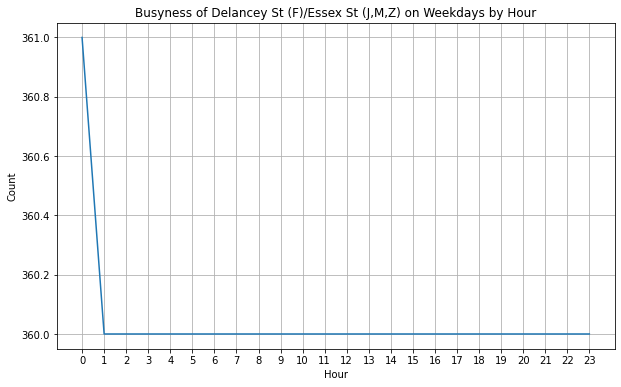

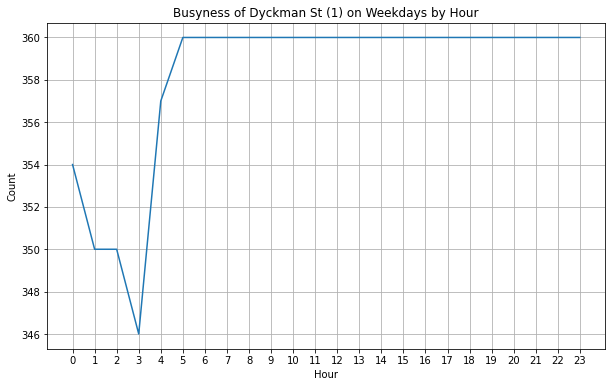

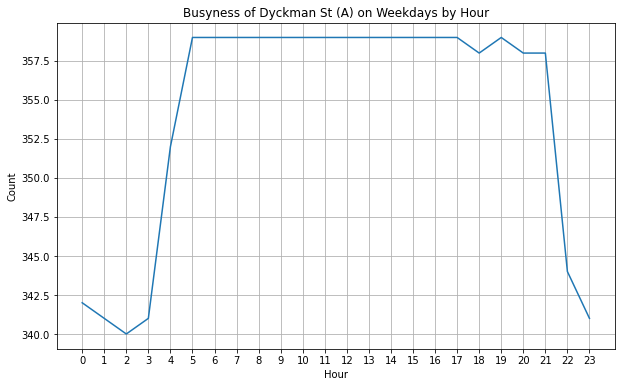

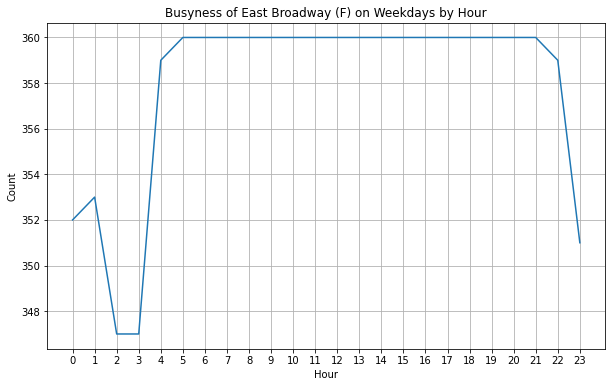

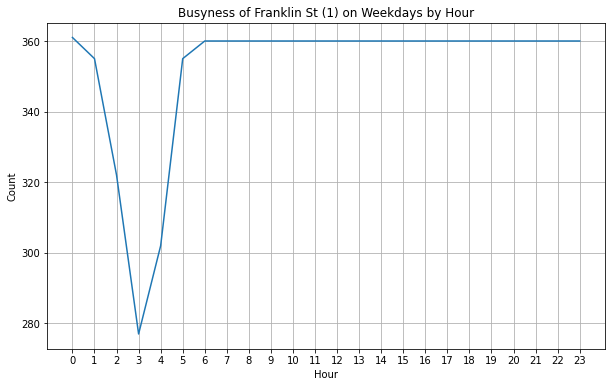

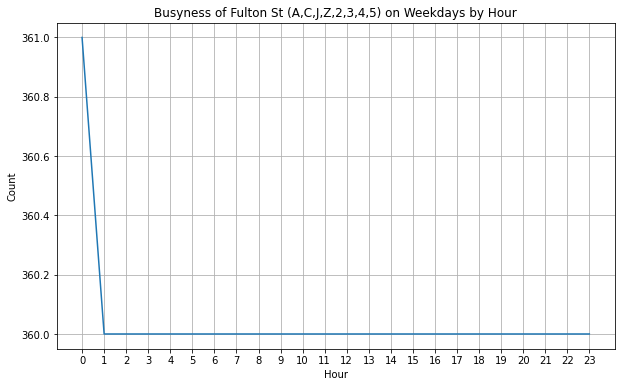

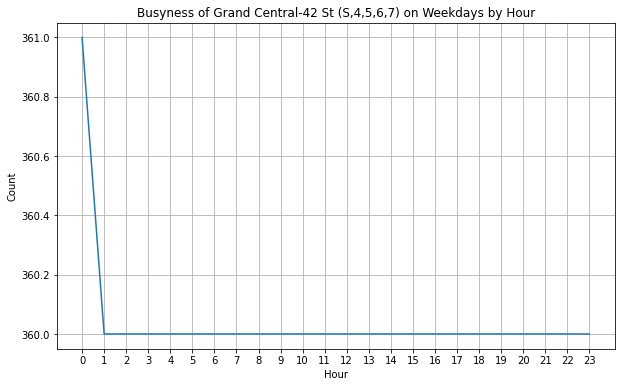

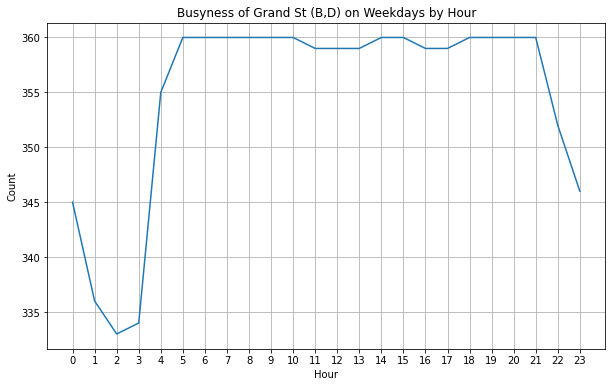

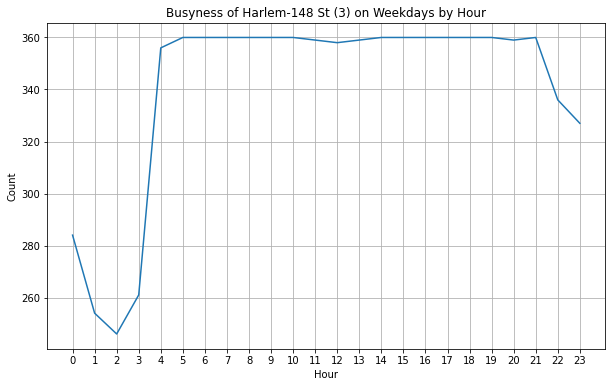

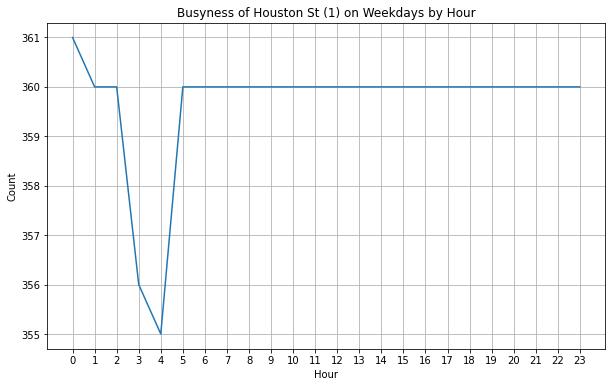

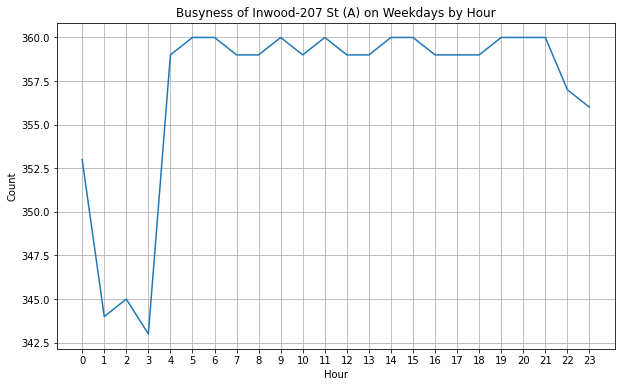

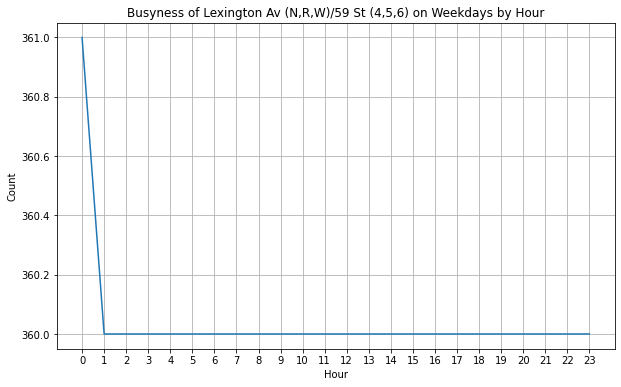

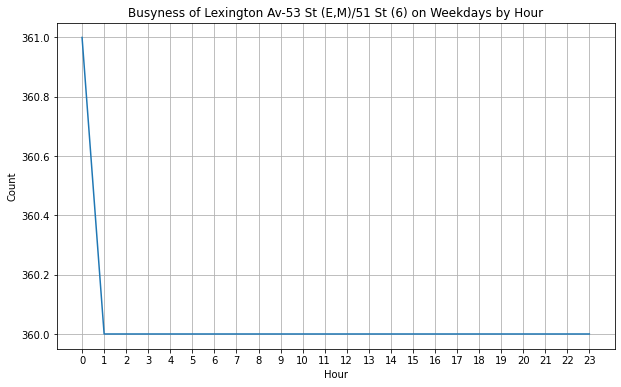

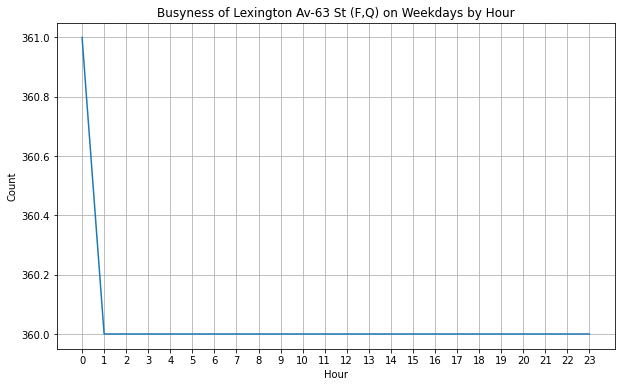

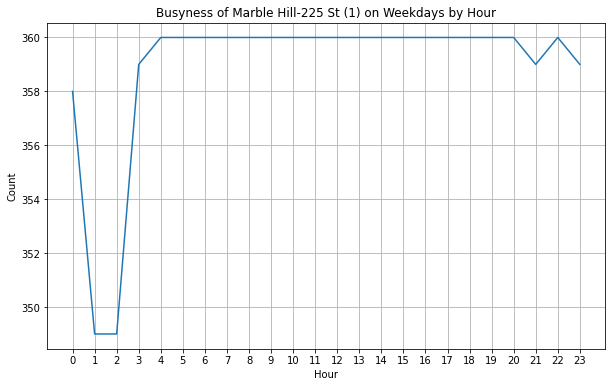

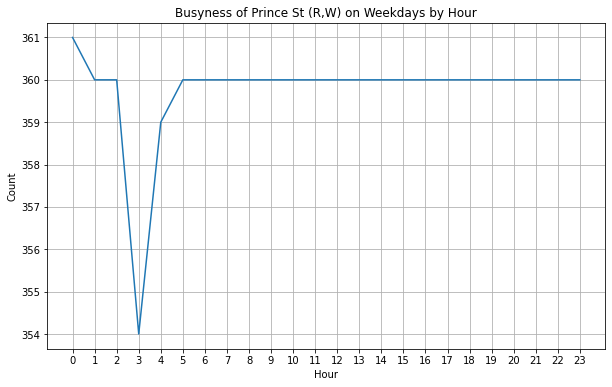

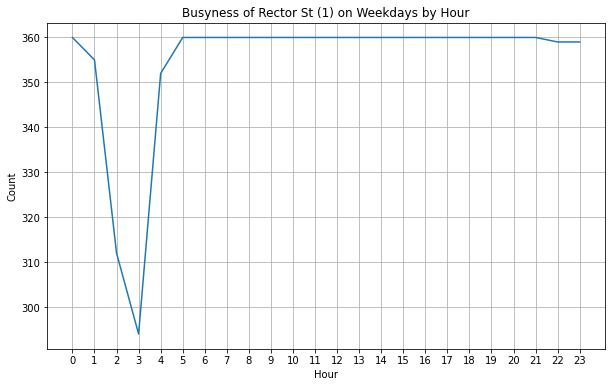

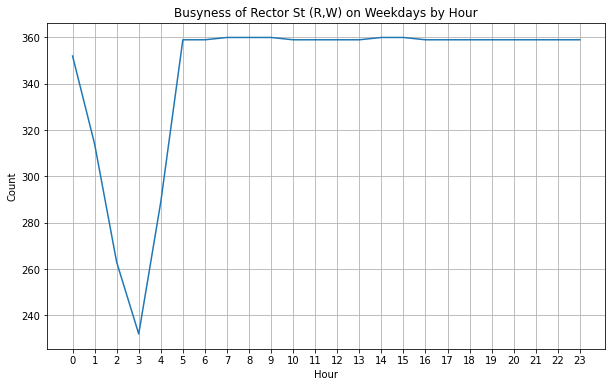

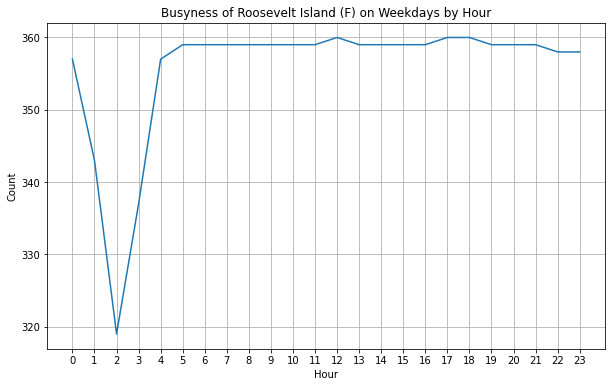

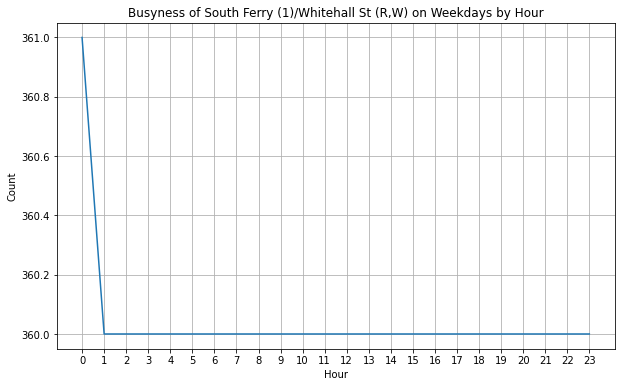

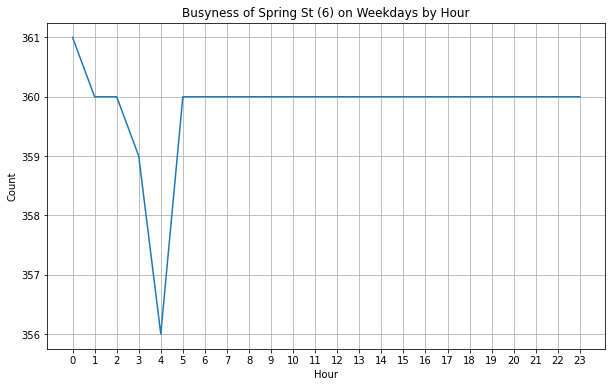

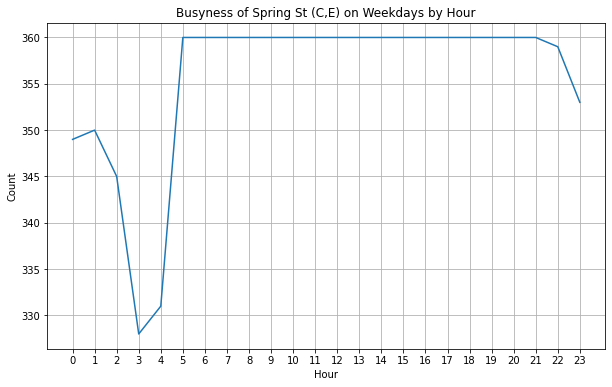

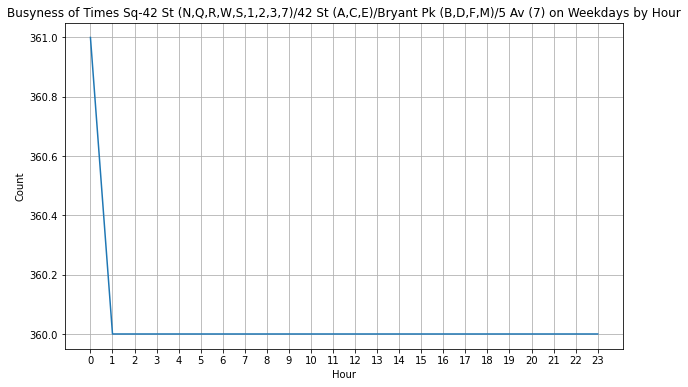

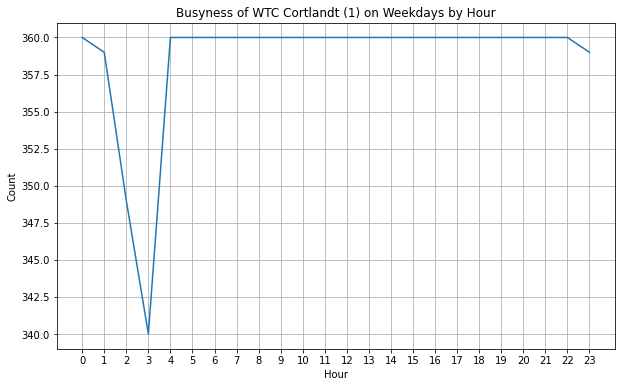

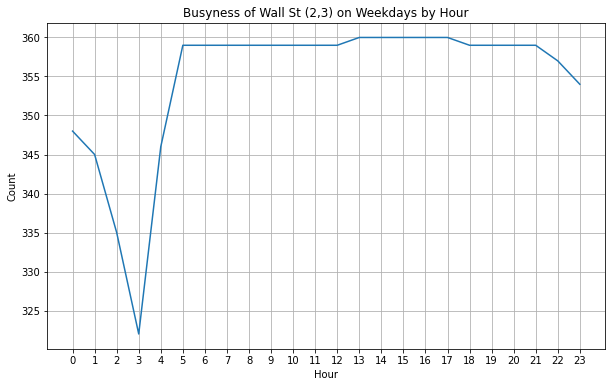

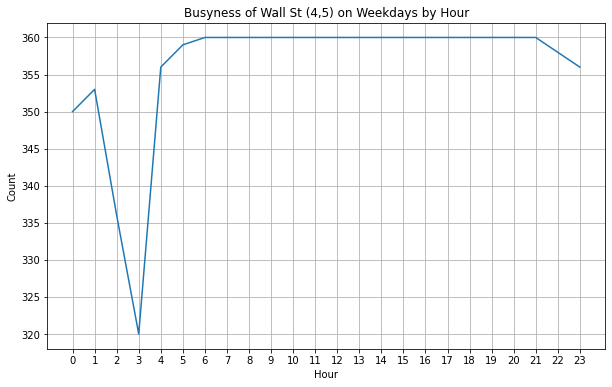

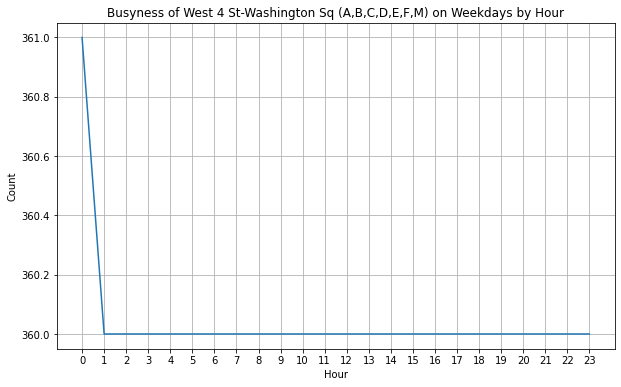

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a DataFrame called 'df'
# Filtering the data for weekdays
weekday_data = df[df['day_type'] == 'weekday']

# Grouping the weekday data by 'station_complex' and 'hour'
grouped_data = weekday_data.groupby(['station_complex', 'hour'])

# Calculating the count of rows for each group
result = grouped_data.size().reset_index(name='count')

# Iterate over unique station complexes
for station_complex in result['station_complex'].unique():
    # Filter the data for the current station complex
    complex_data = result[result['station_complex'] == station_complex]

    # Create a line plot for the current station complex
    plt.figure(figsize=(10, 6))
    plt.plot(complex_data['hour'], complex_data['count'])
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.title(f'Busyness of {station_complex} on Weekdays by Hour')
    plt.xticks(range(24))
    plt.grid(True)

    # Display the plot
    plt.show()


In [23]:
# Filter data for holidays
holidays_df = df[df['holiday']]
#  Calculate the total number of rows in the DataFrame
total_rows = len(df)

#  Calculate the number of holiday trips
holiday_trips = len(holidays_df)

#  Calculate the percentage of holiday trips
percentage_holidays = (holiday_trips / total_rows) * 100
print("length",holiday_trips)
# Print the results
print(f"Percentage of trips that are holidays: {percentage_holidays:.2f}%")
print(f"Total rows in the DataFrame: {total_rows}")

length 1068
Percentage of trips that are holidays: 0.07%
Total rows in the DataFrame: 1435991


In [24]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import folium
# import re
# from io import BytesIO
# from PIL import Image
# import base64

# # Assuming your dataset is stored in a DataFrame called 'df'
# # Filtering the data for weekdays
# weekday_data = df[df['day_type'] == 'weekday']

# # Grouping the weekday data by 'station_complex' and 'hour'
# grouped_data = weekday_data.groupby(['station_complex', 'hour'])

# # Calculating the count of rows for each group
# result = grouped_data.size().reset_index(name='count')

# # Create a set to store unique latitude and longitude combinations
# unique_locations = set()

# # Initialize a Folium map
# map = folium.Map(location=[40.75, -73.95], zoom_start=12)  # Set the initial center and zoom level

# # Iterate over unique station complexes
# for station_complex in result['station_complex'].unique():
#     # Filter the data for the current station complex
#     complex_data = result[result['station_complex'] == station_complex]

#     # Create a line plot for the current station complex
#     plt.figure(figsize=(10, 6))
#     plt.plot(complex_data['hour'], complex_data['count'])
#     plt.xlabel('Hour')
#     plt.ylabel('Count')
#     plt.title(f'Busyness of {station_complex} on Weekdays by Hour')
#     plt.xticks(range(24))
#     plt.grid(True)

#     # Save the plot to a BytesIO object instead of a file
#     buffer = BytesIO()
#     plt.savefig(buffer, format='png')
#     buffer.seek(0)

#     # Read the image and encode it as base64
#     image_base64 = base64.b64encode(buffer.getvalue()).decode()

#     # Construct the popup content with the base64 encoded image
#     popup_content = f'<img src="data:image/png;base64,{image_base64}" alt="Graph">{station_complex}'

#     # Get the latitude and longitude for the current station complex
#     station_lat = df[df['station_complex'] == station_complex]['latitude'].iloc[0]
#     station_lon = df[df['station_complex'] == station_complex]['longitude'].iloc[0]

#     # Add unique location to the set
#     unique_locations.add((station_lat, station_lon))

#     # Create a marker on the map for the current station complex
#     folium.Marker(location=[station_lat, station_lon],
#                   icon=folium.Icon(color='green'),
#                   popup=popup_content).add_to(map)

#     # Clear the plot for the next iteration
#     plt.clf()

# # Display the map
# map



In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from io import BytesIO
import base64


In [26]:
weekday_data = df[df['day_type'] == 'weekday']


In [27]:
grouped_data = weekday_data.groupby(['station_complex', 'hour'])
result = grouped_data.size().reset_index(name='count')


In [32]:
unique_locations = set()
station_complex_images = {}
map = folium.Map(location=[40.75, -73.95], zoom_start=12)  # Set the initial center and zoom level


In [37]:
for station_complex in result['station_complex'].unique():
    complex_data = result[result['station_complex'] == station_complex]
    plt.figure(figsize=(10, 6))
    plt.plot(complex_data['hour'], complex_data['count'])
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.title(f'Busyness of {station_complex} on Weekdays by Hour')
    plt.xticks(range(24))
    plt.grid(True)

    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode()

    # Store the base64 encoded image in the dictionary
    station_complex_images[station_complex] = image_base64

    # Clear the plot for the next iteration
    plt.clf()
%store station_complex_images

/var/folders/6q/9wmlbvpj5nqfn_clctmzyck00000gn/T/ipykernel_6059/2961496327.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Stored 'station_complex_images' (dict)


<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>


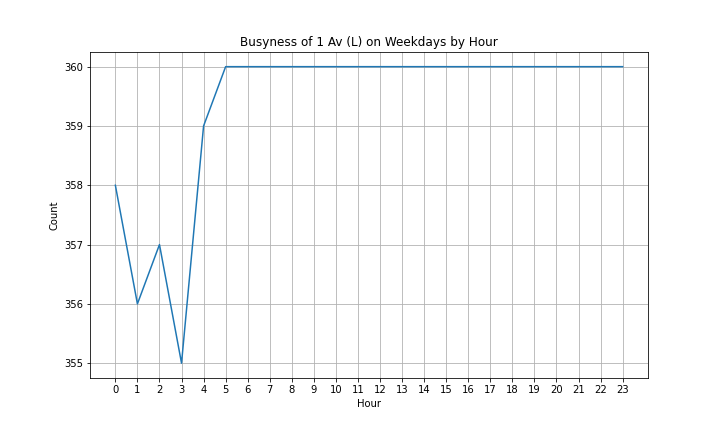
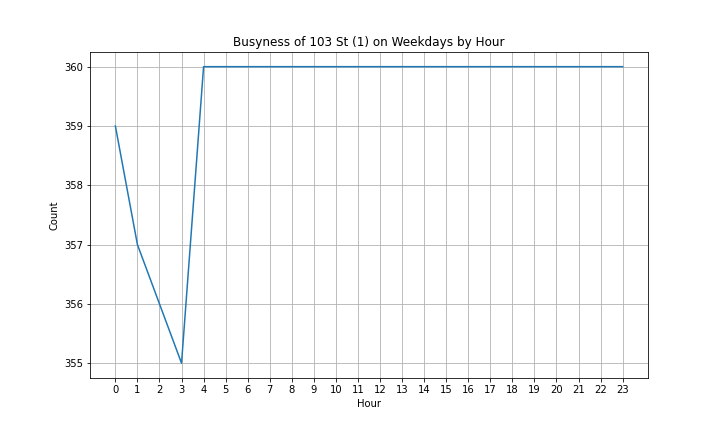
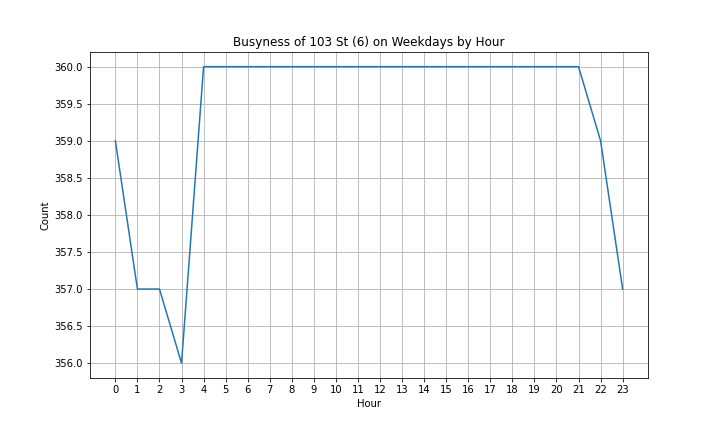
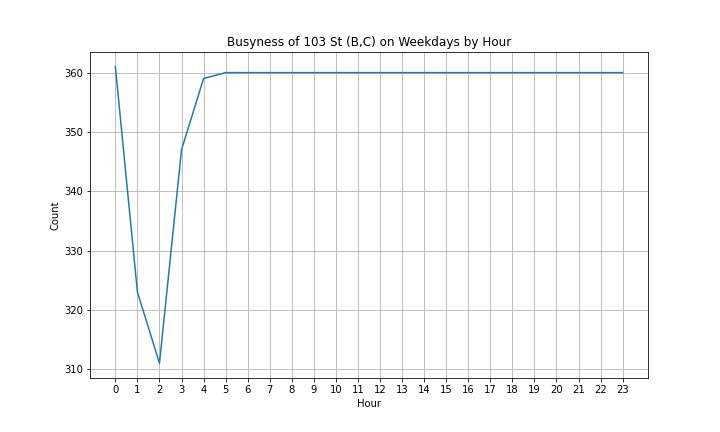
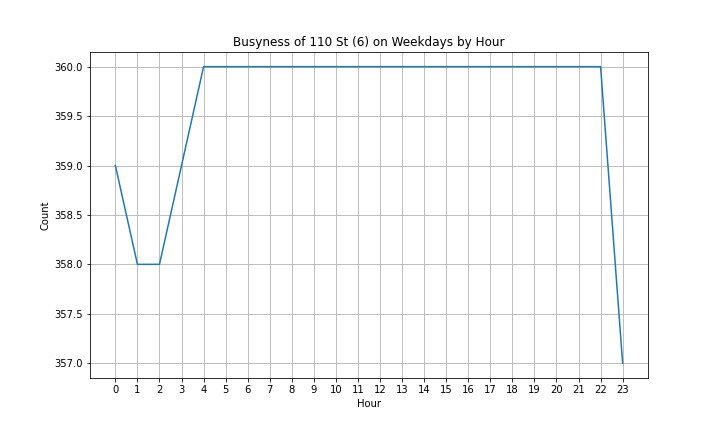
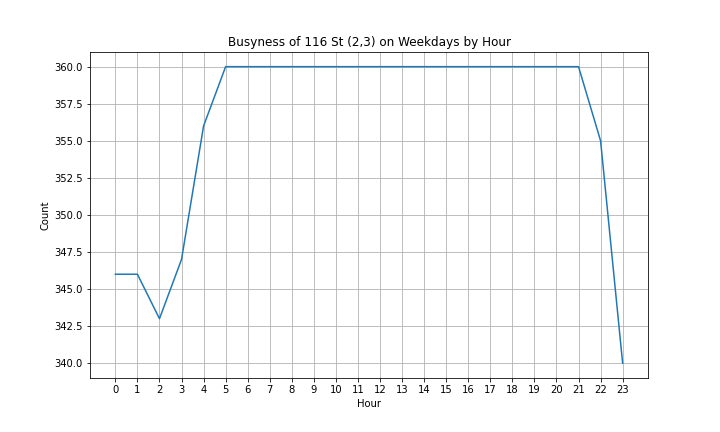
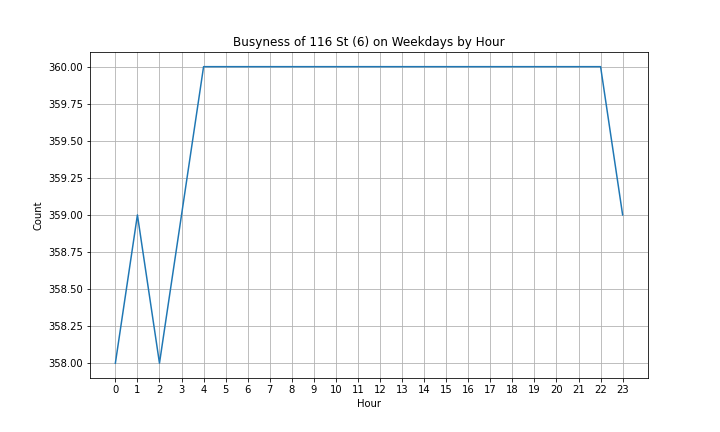
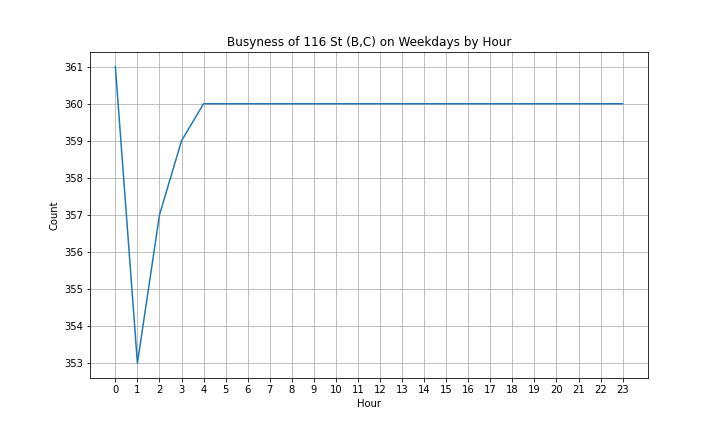
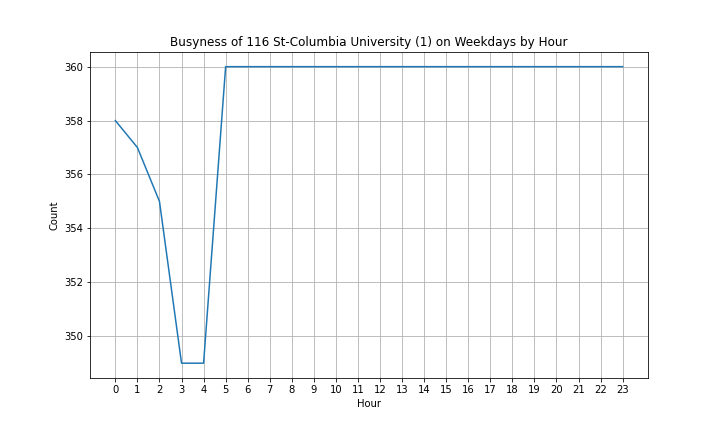
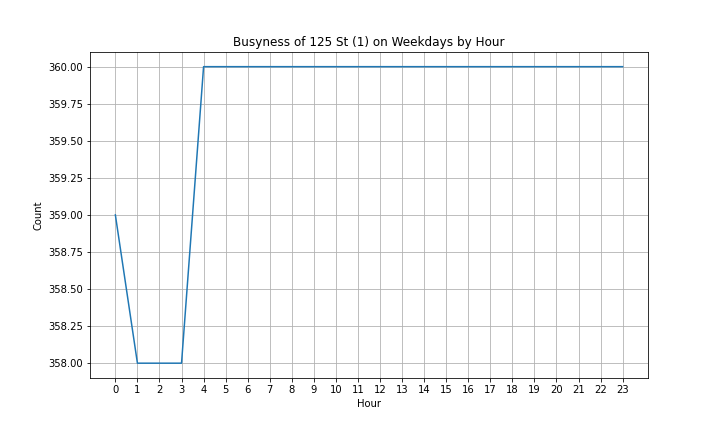
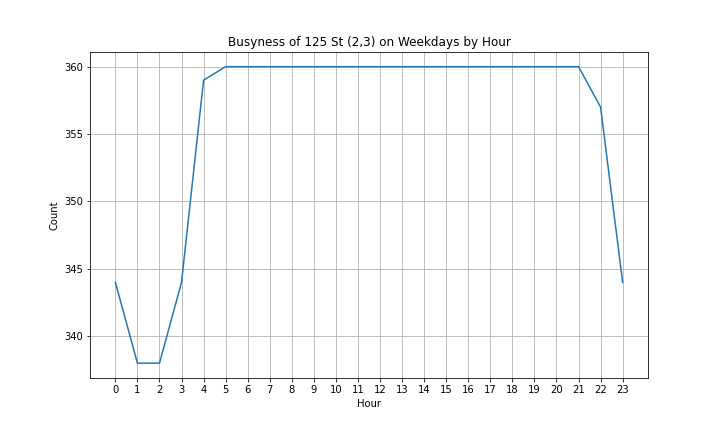
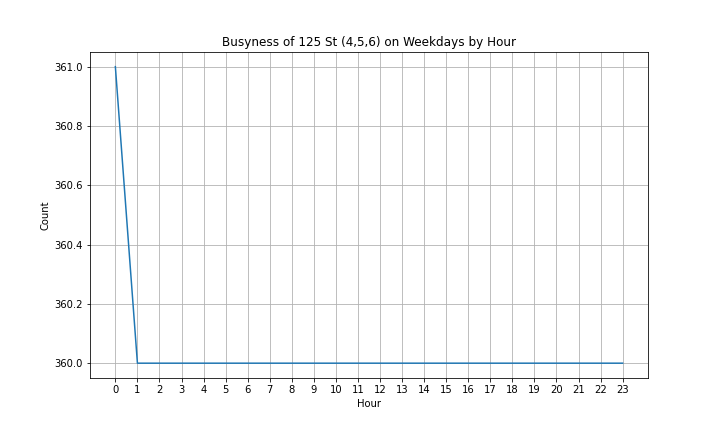
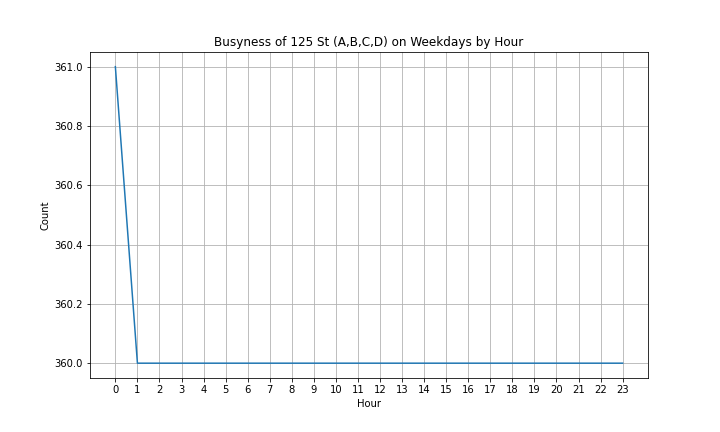
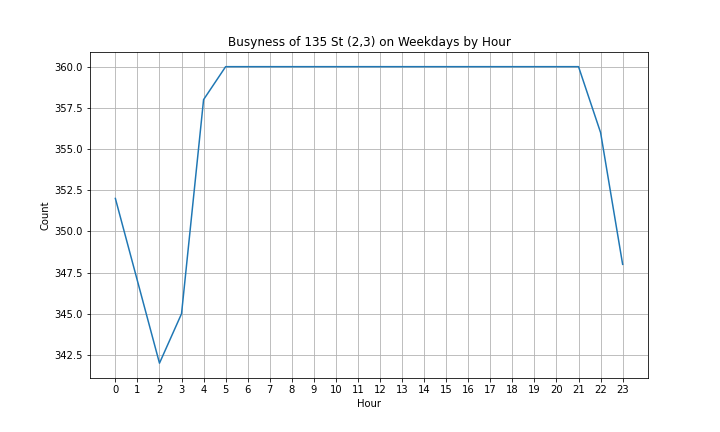
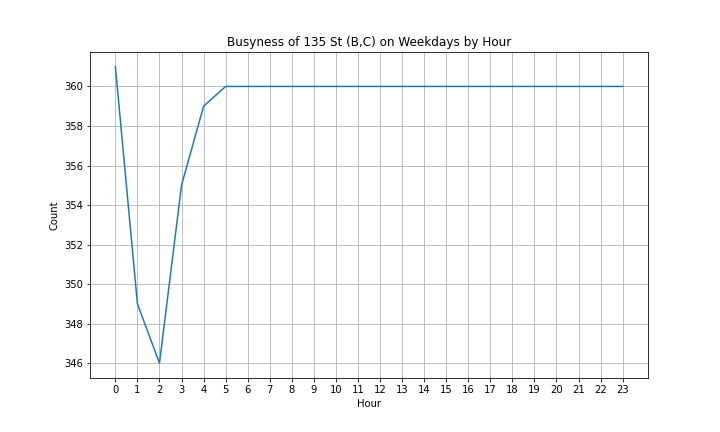
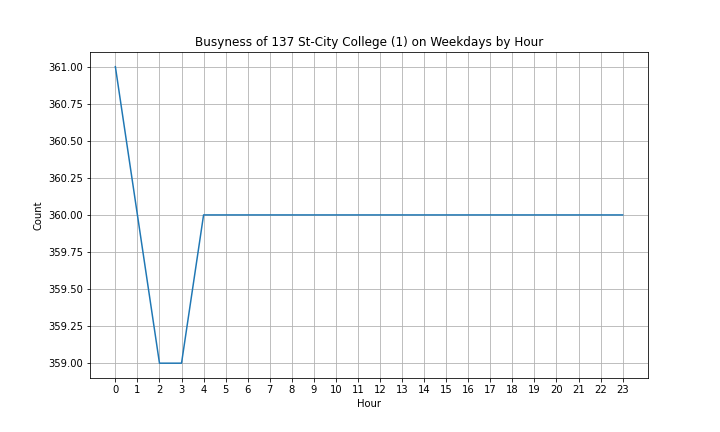
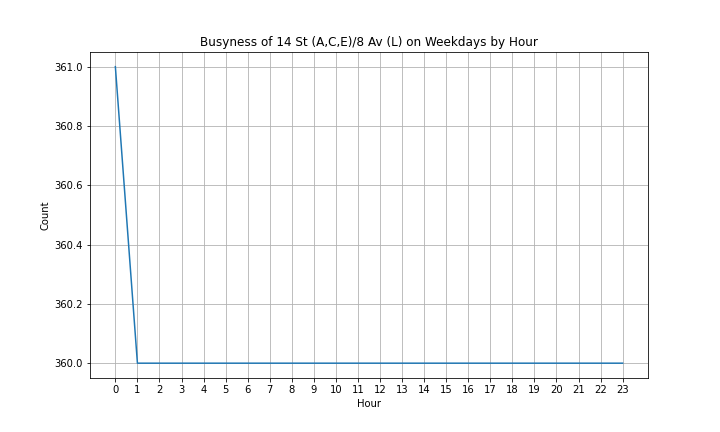
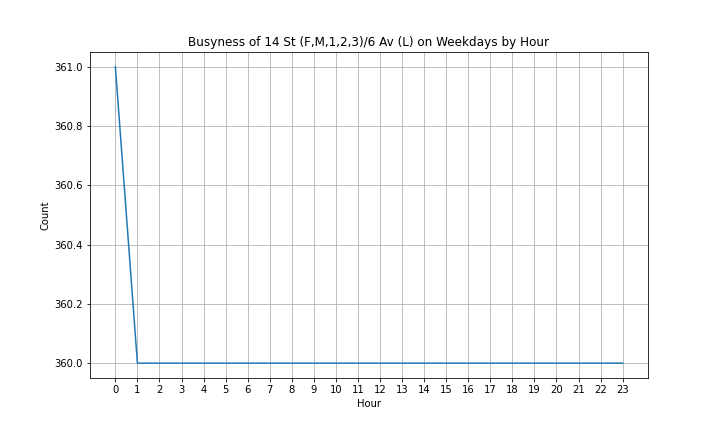
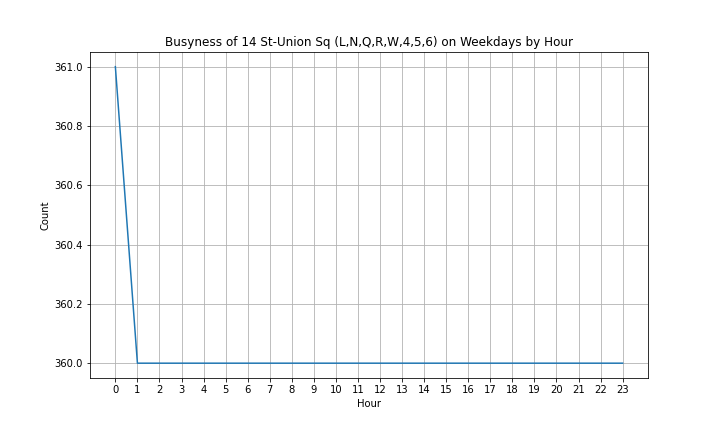
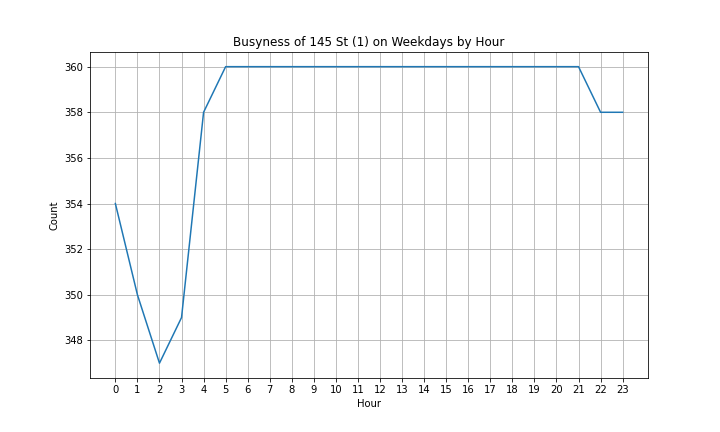
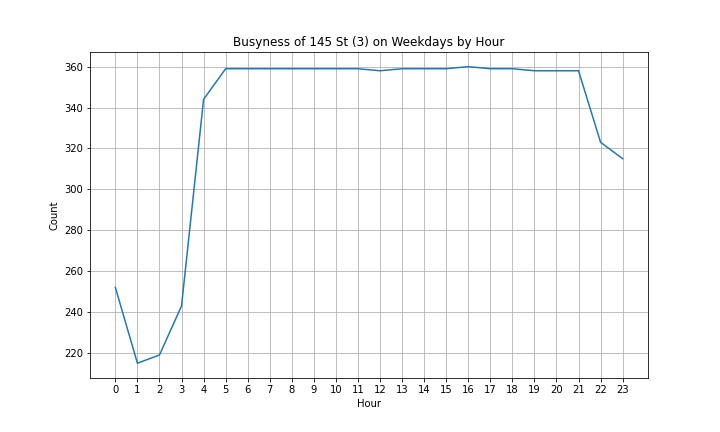
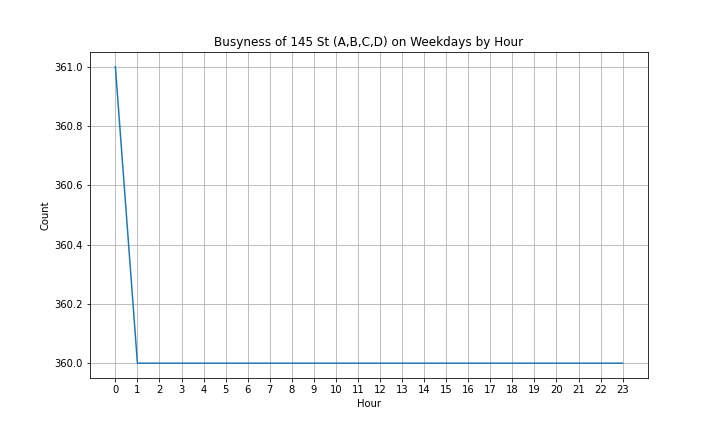
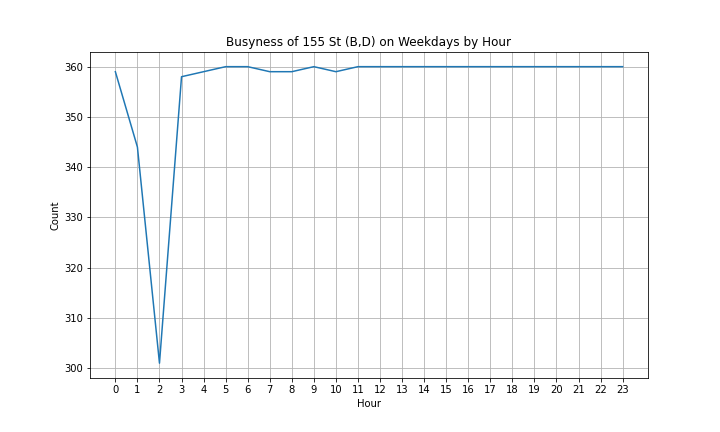
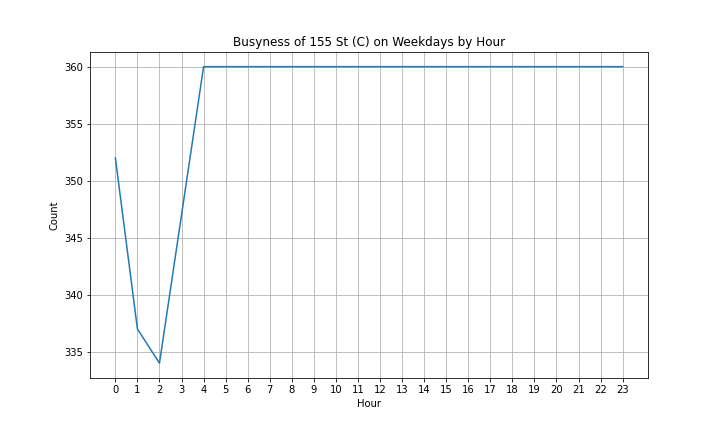
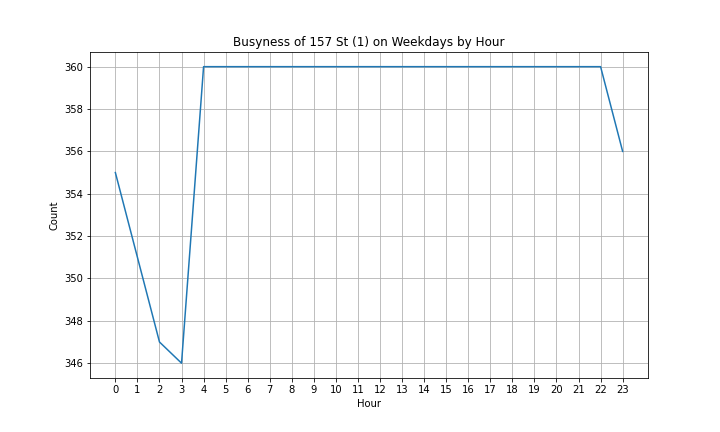
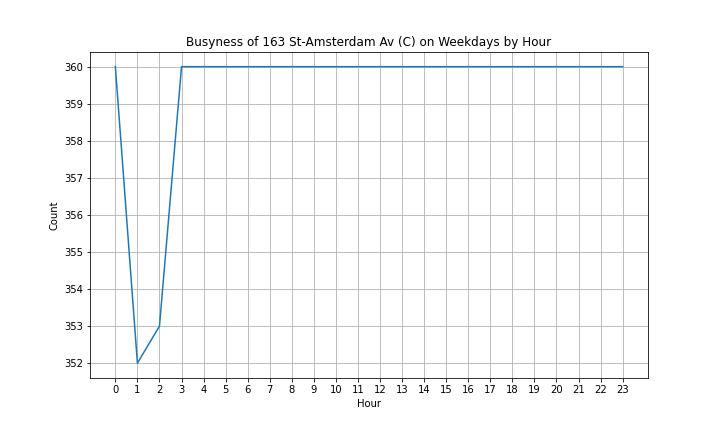
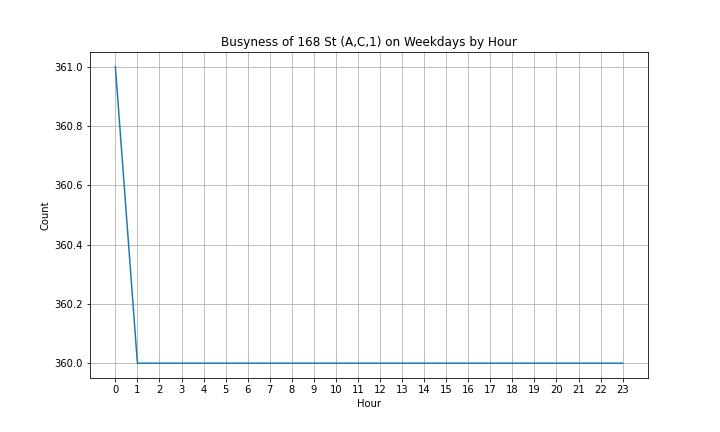
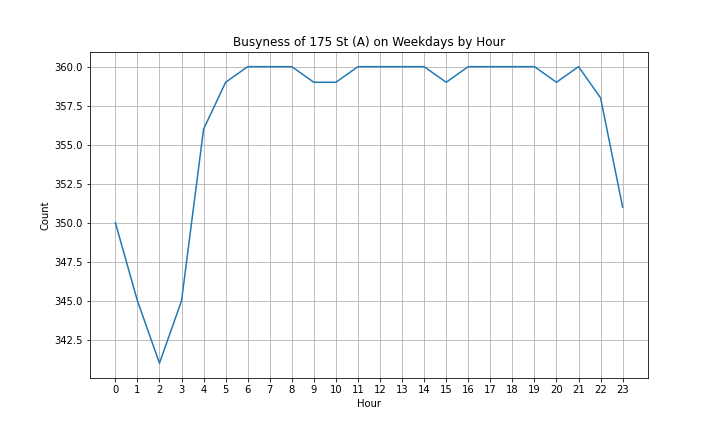
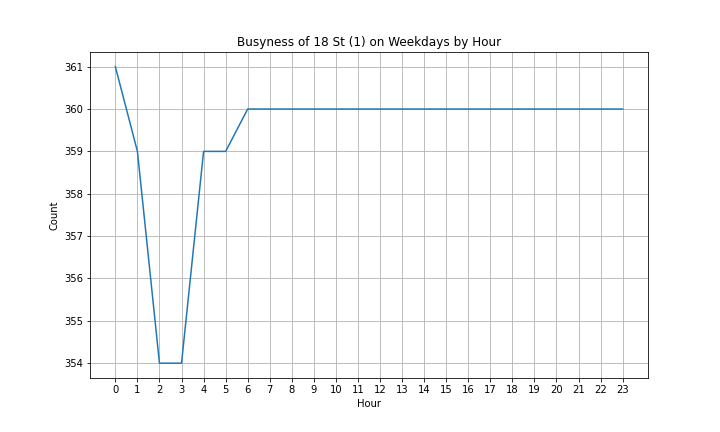
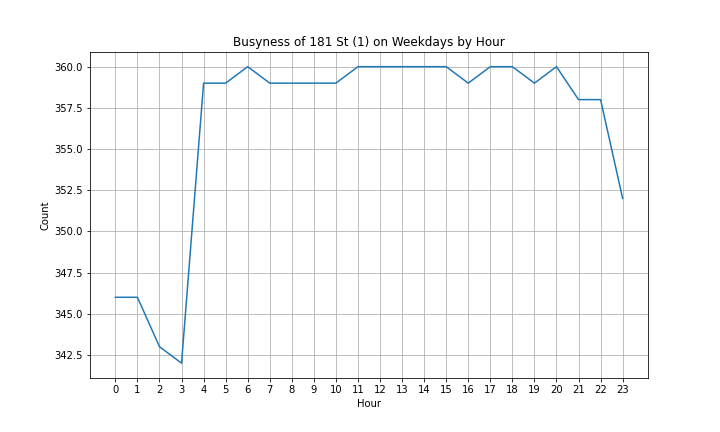
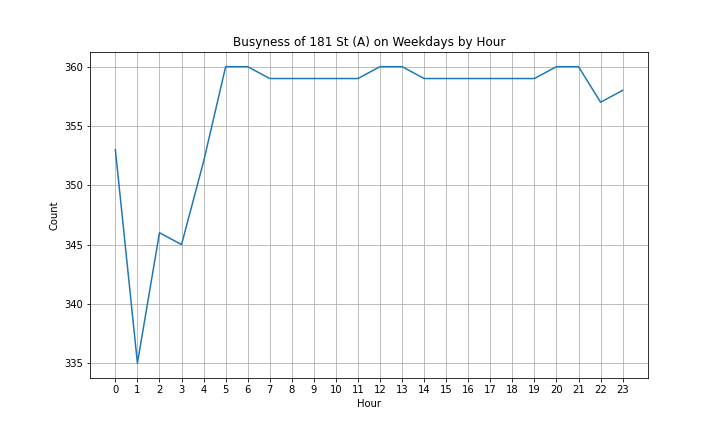
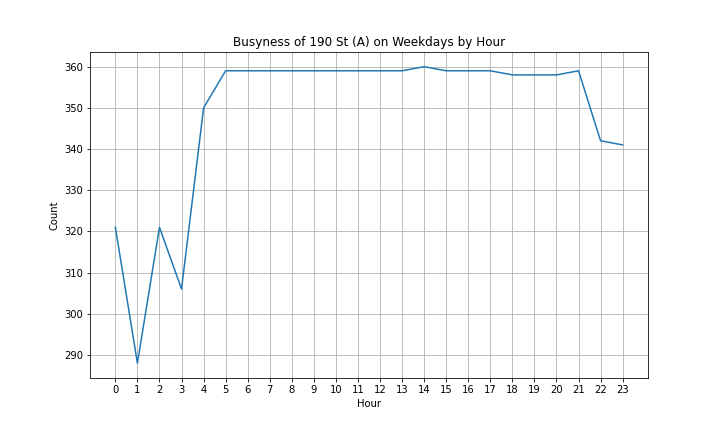
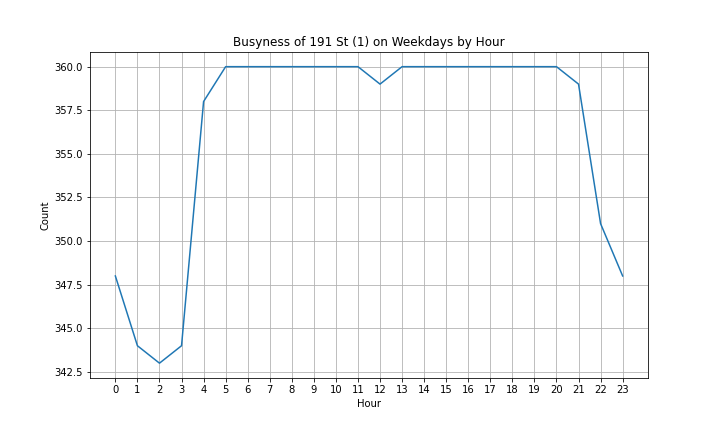
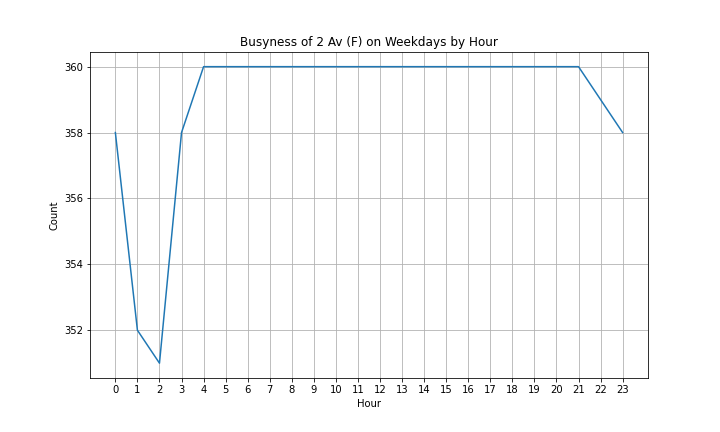
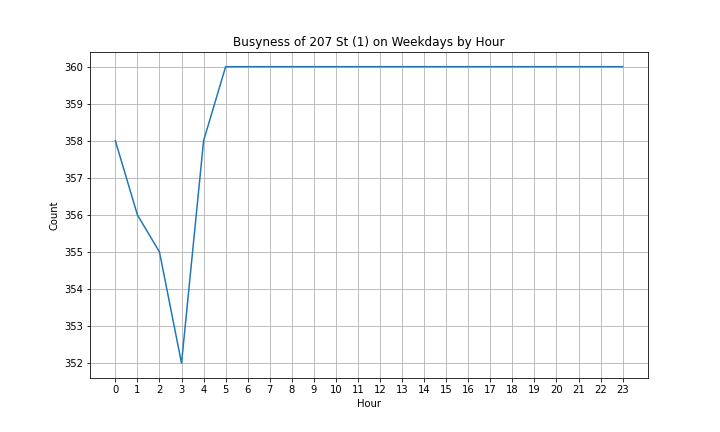
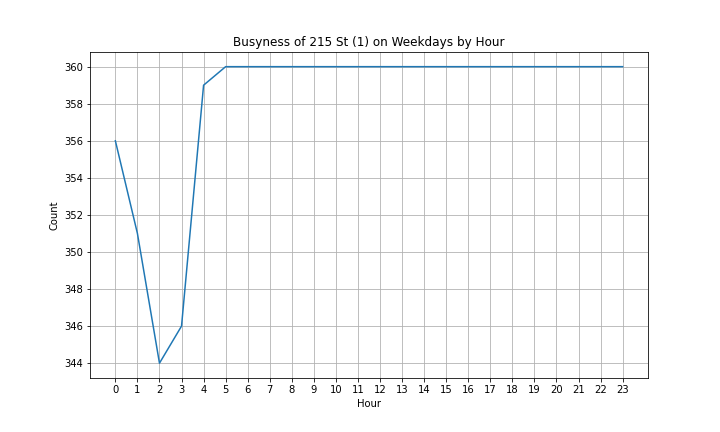
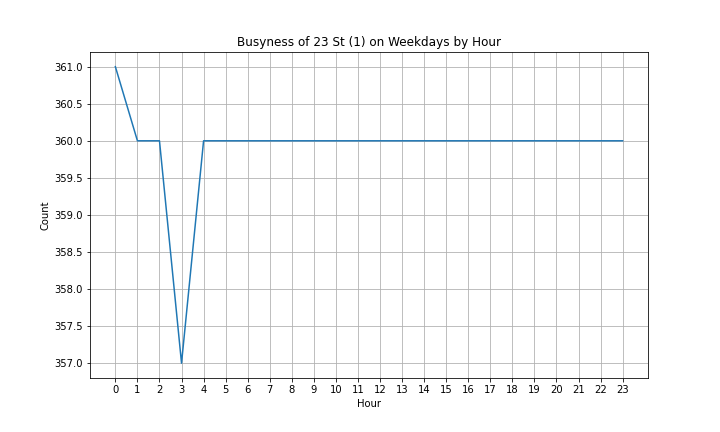
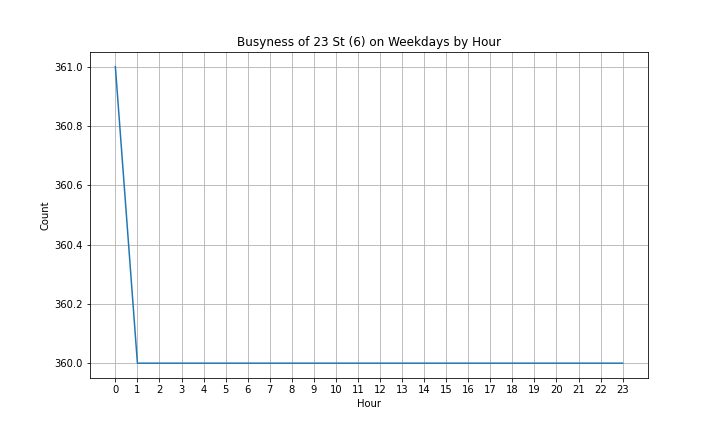
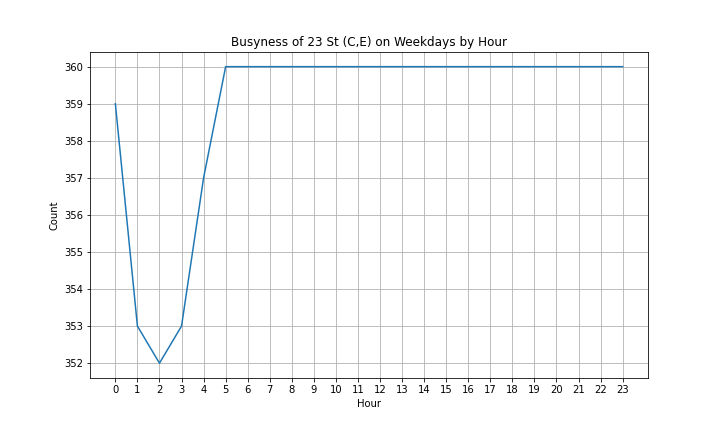
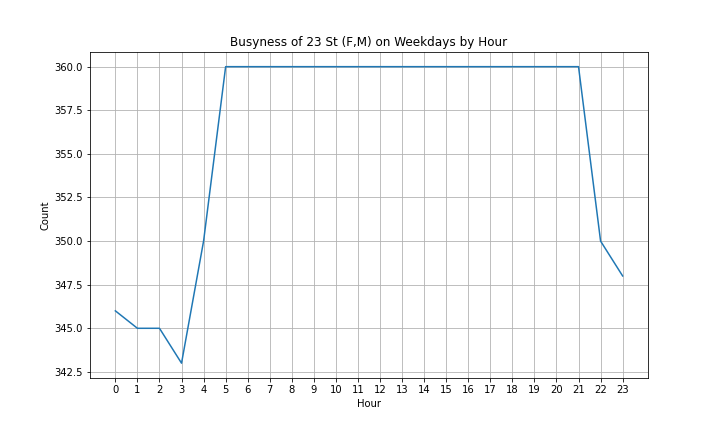
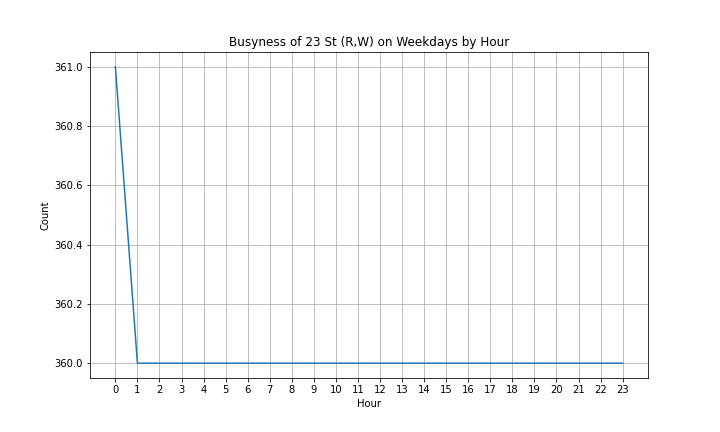
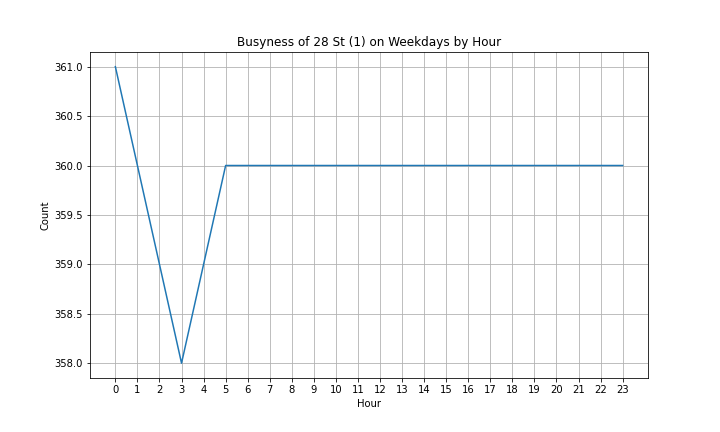
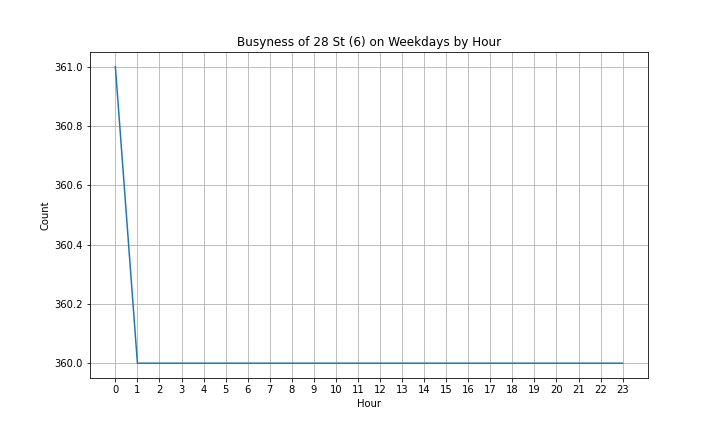
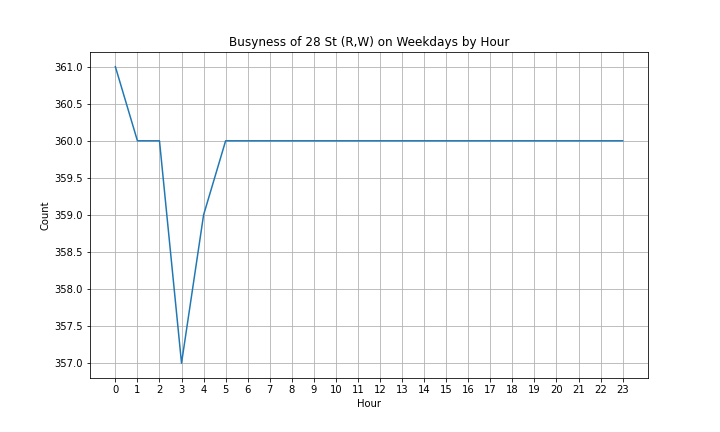
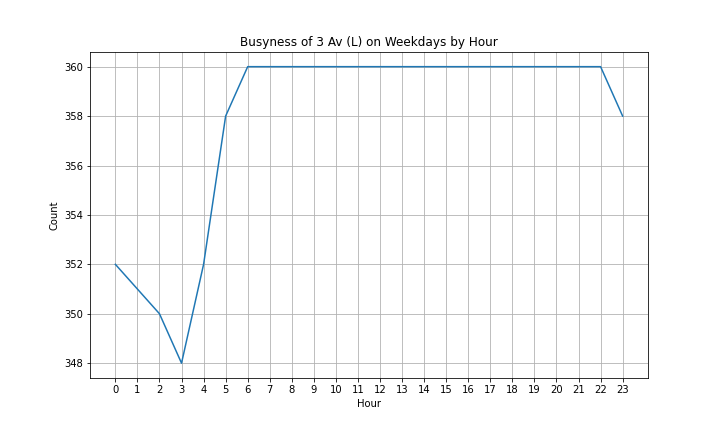
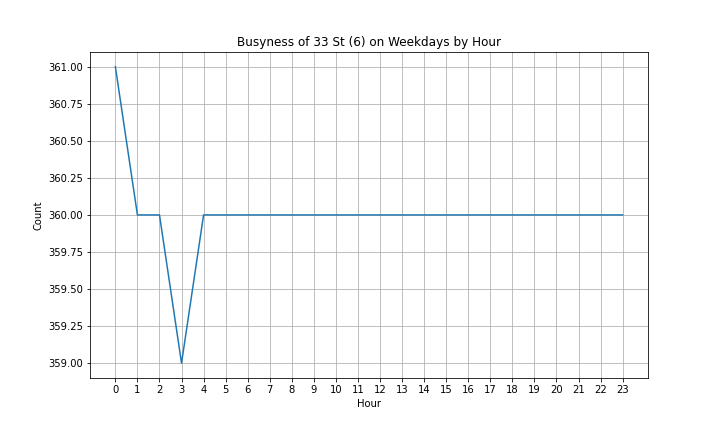
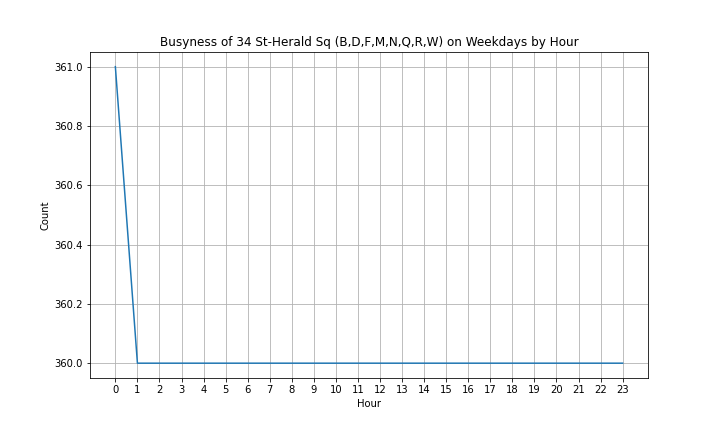
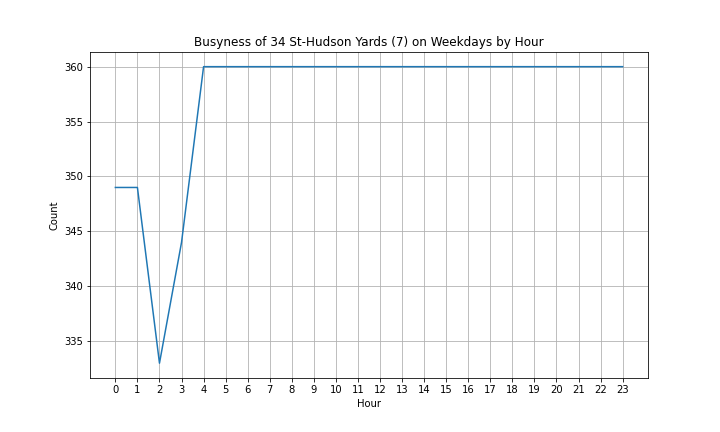
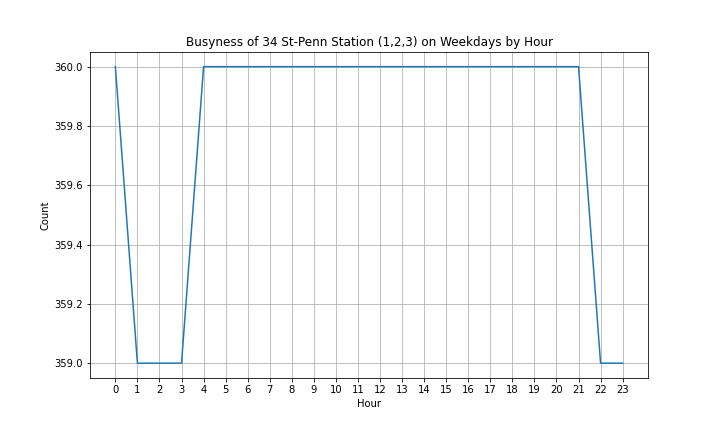
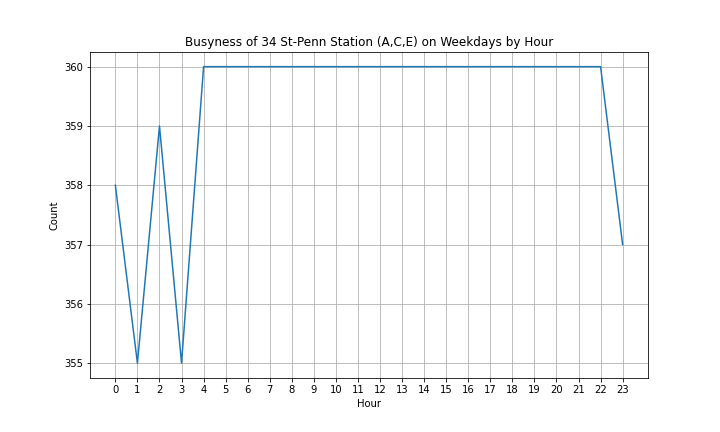
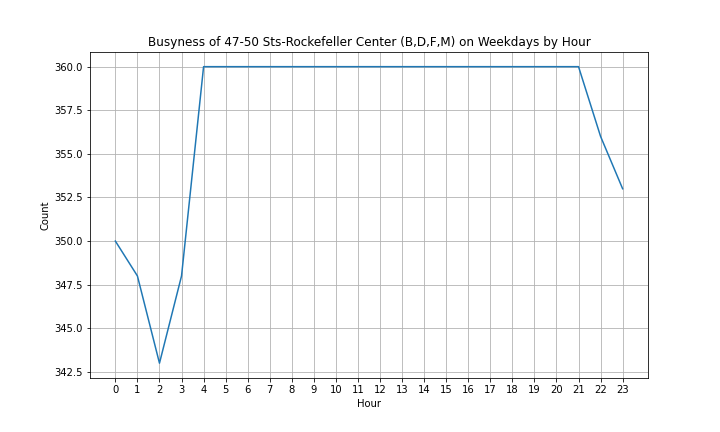
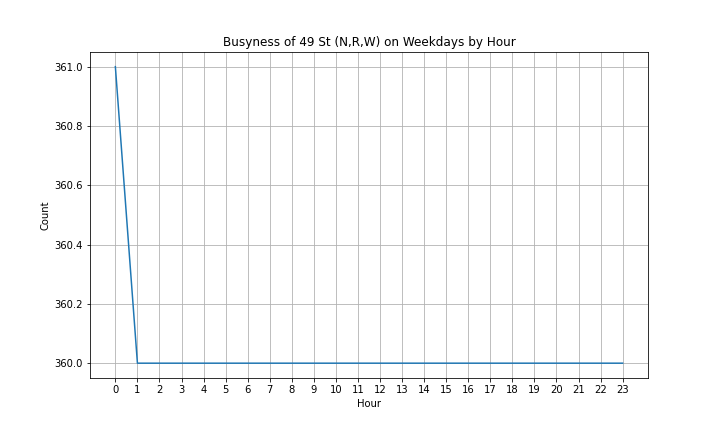
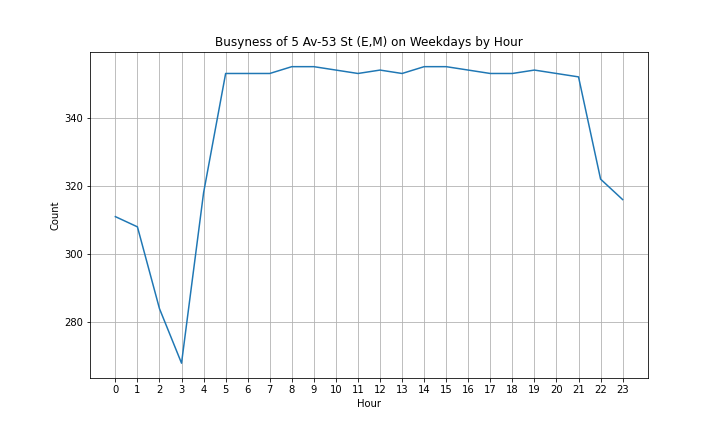
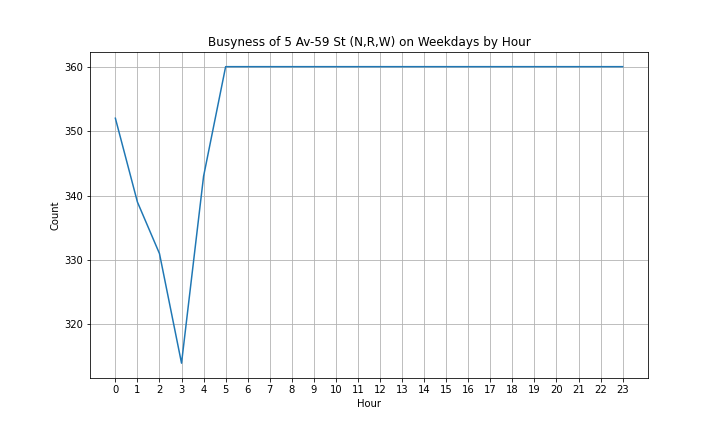
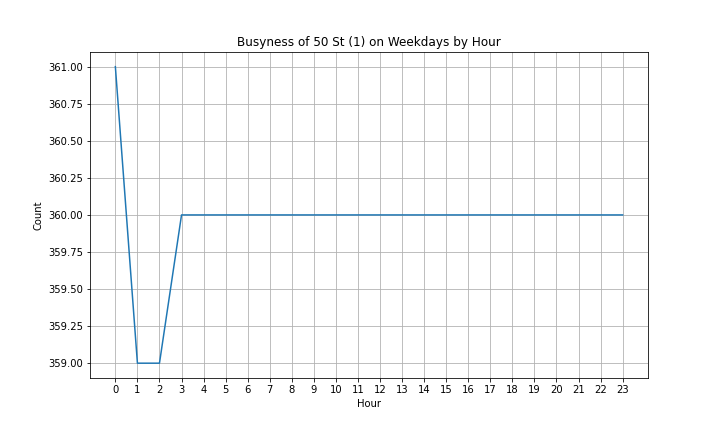
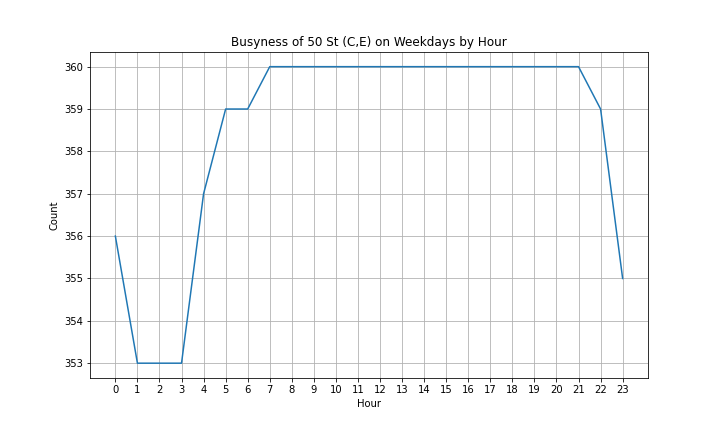
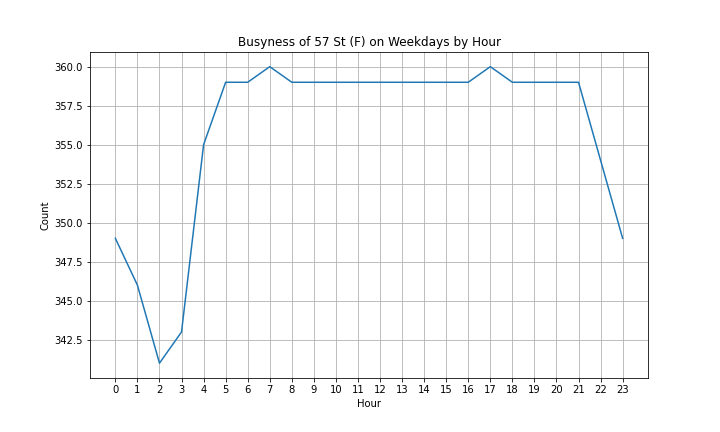
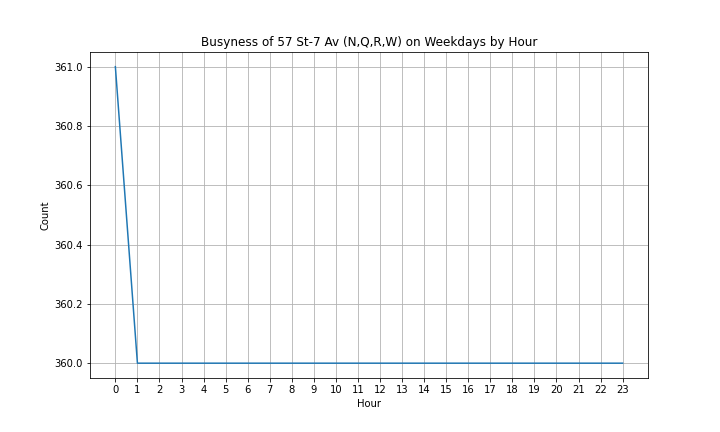
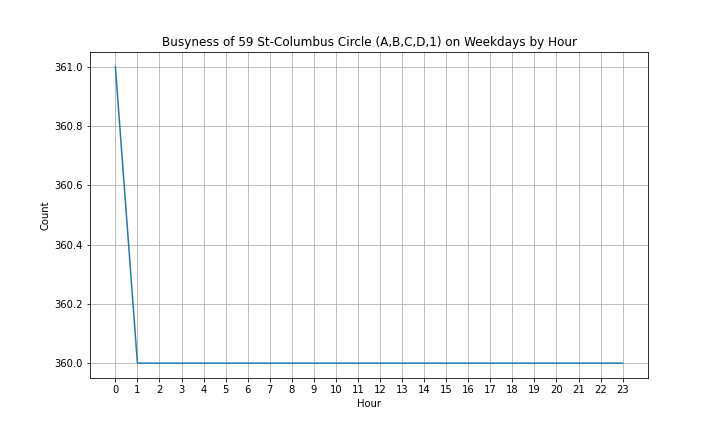
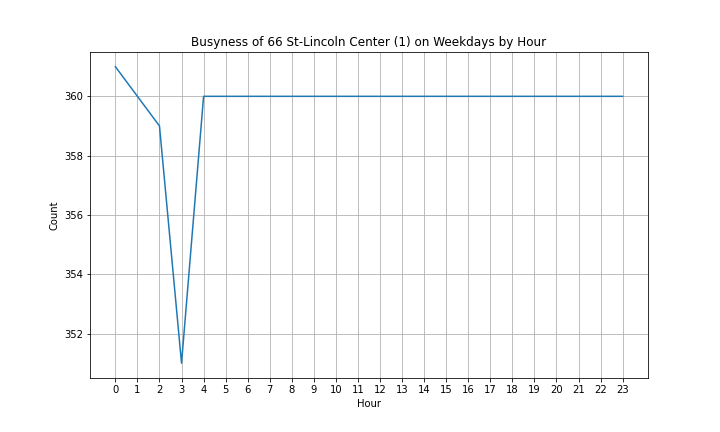
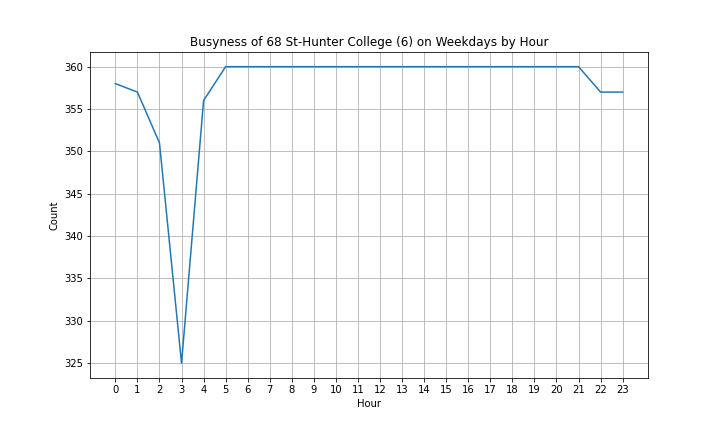
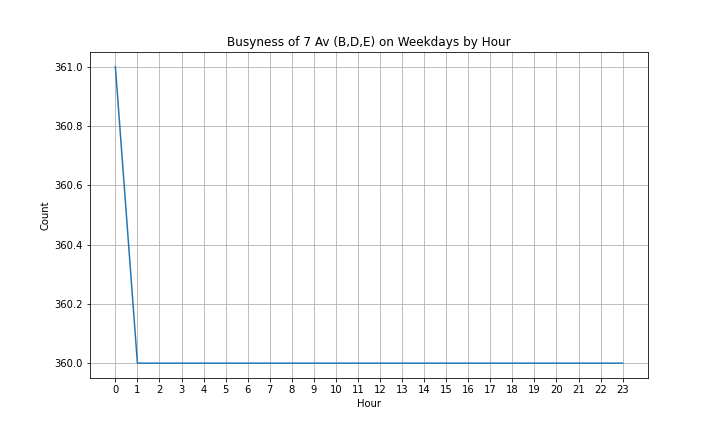
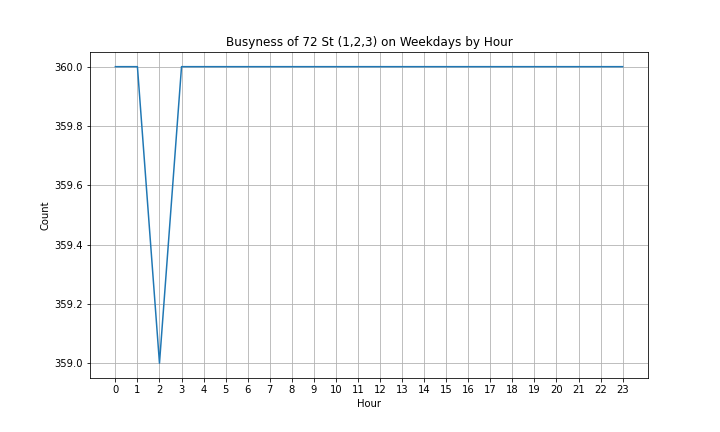
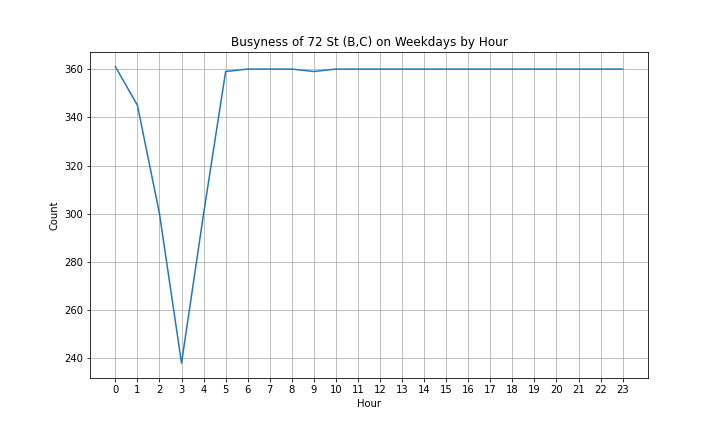
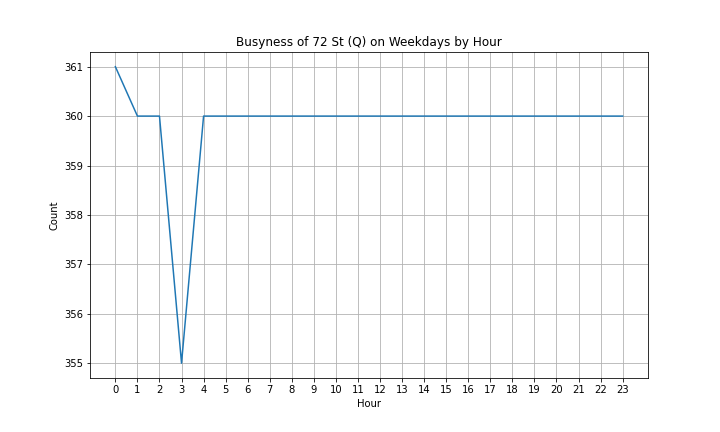
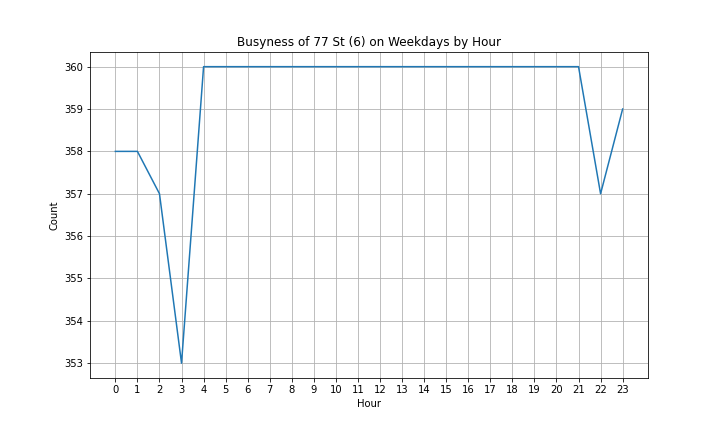
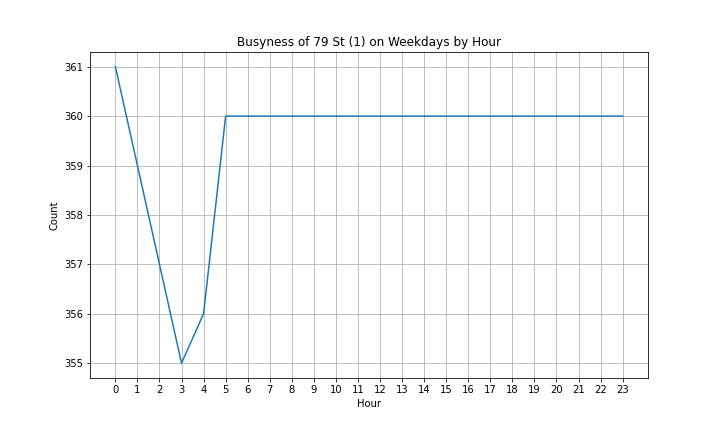
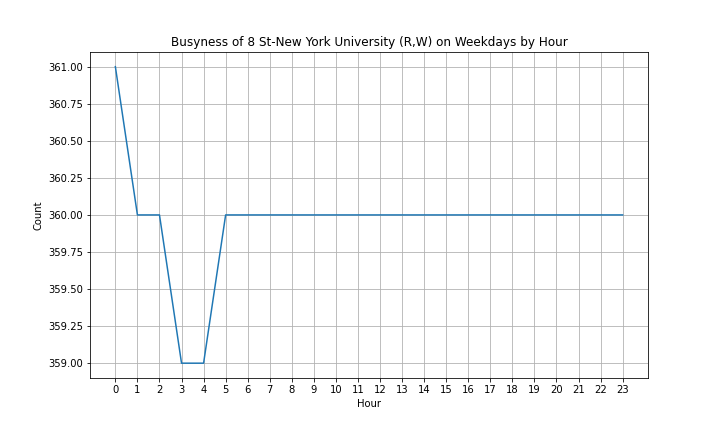
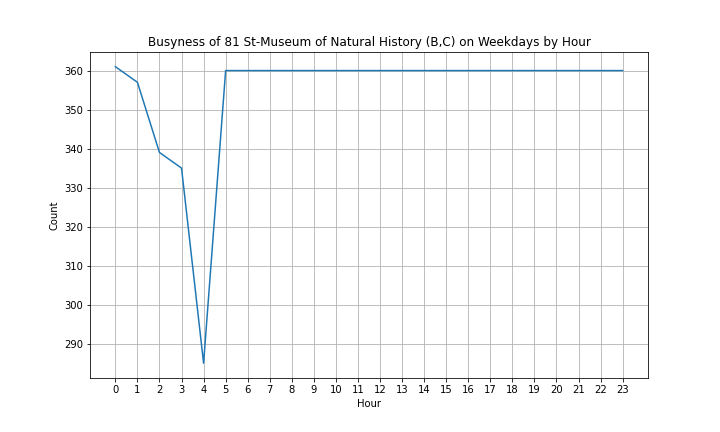
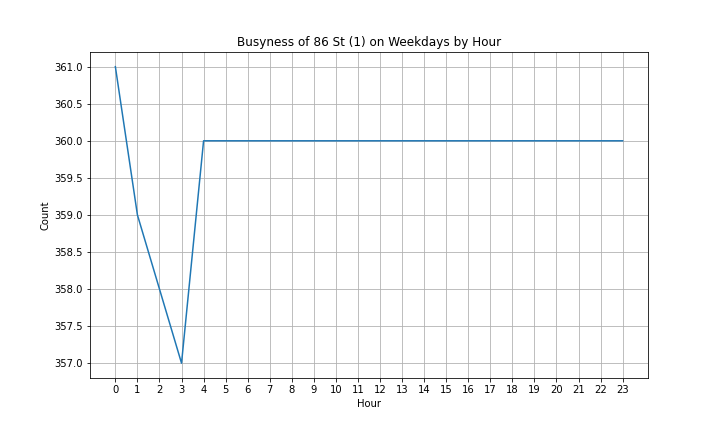
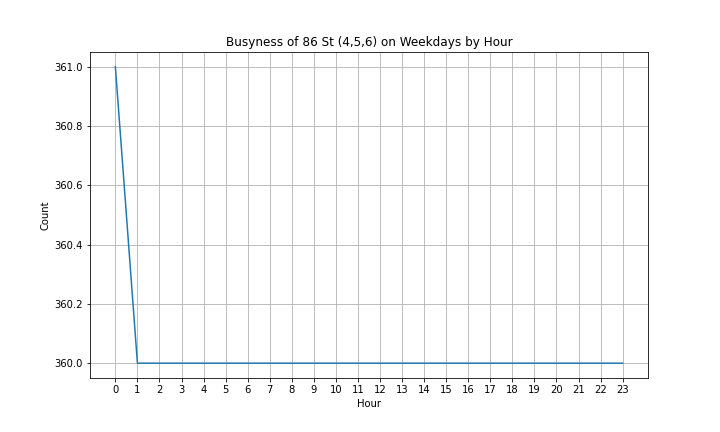
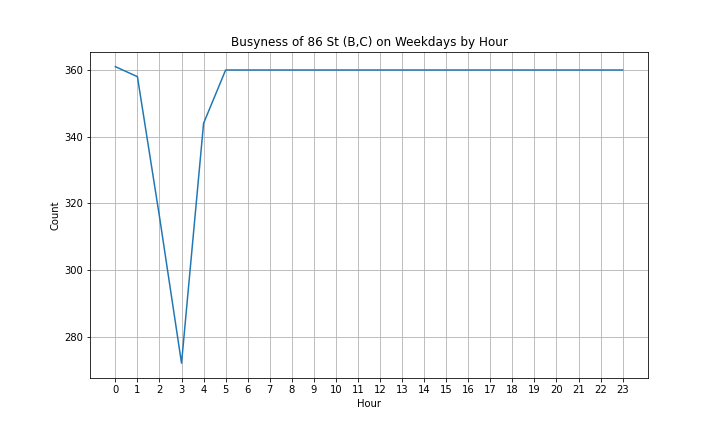
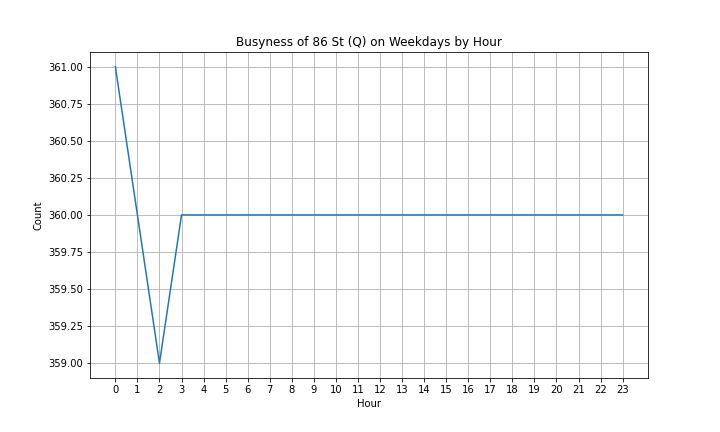
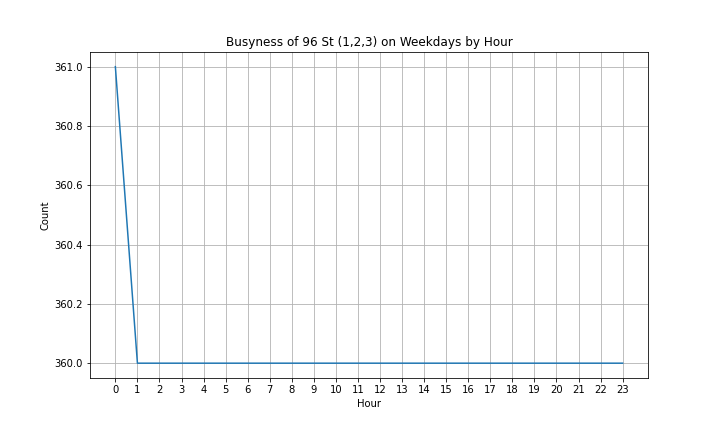
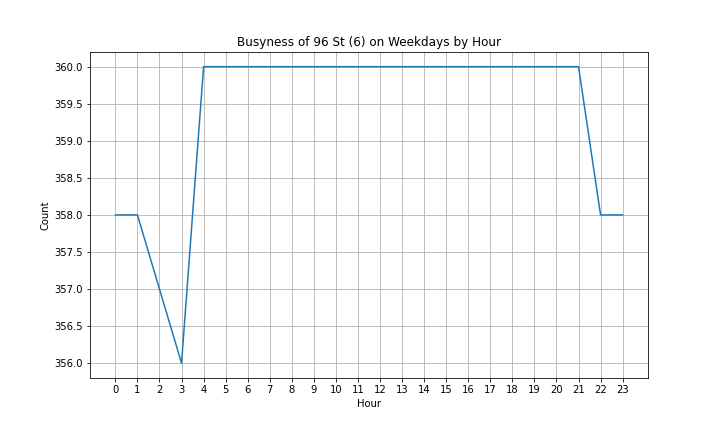
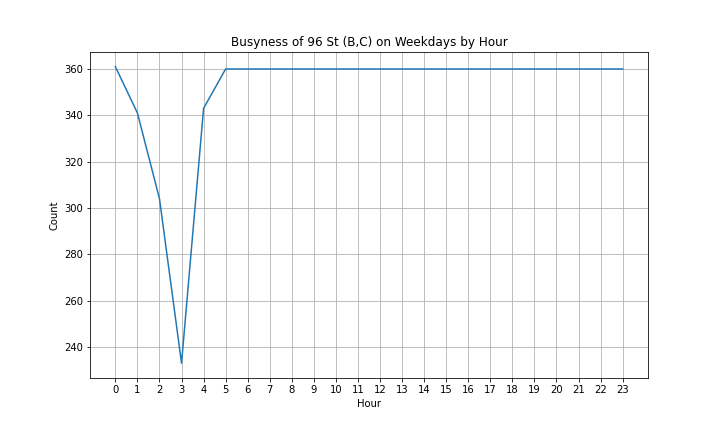
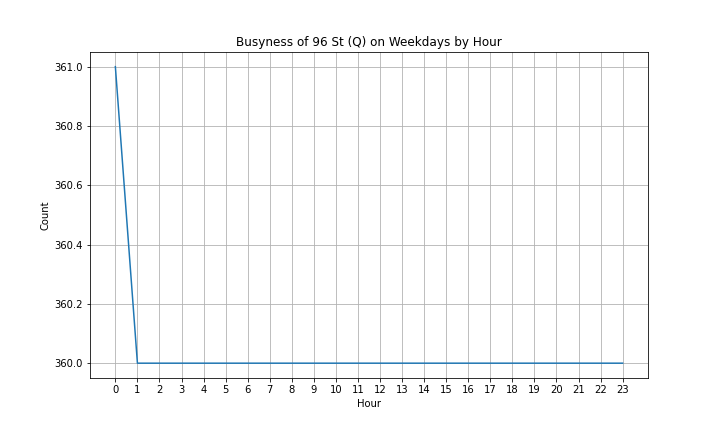
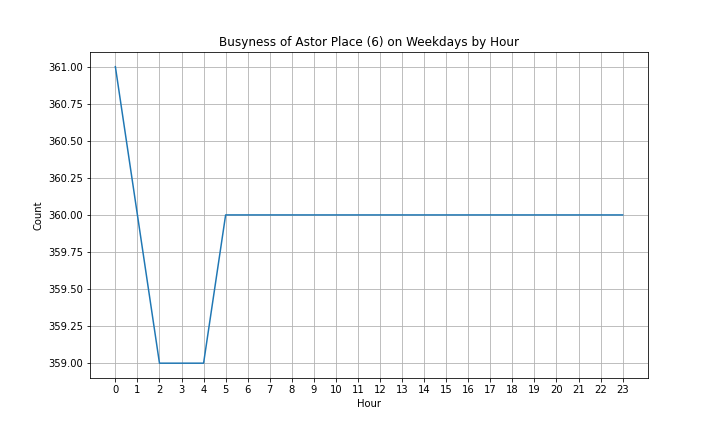
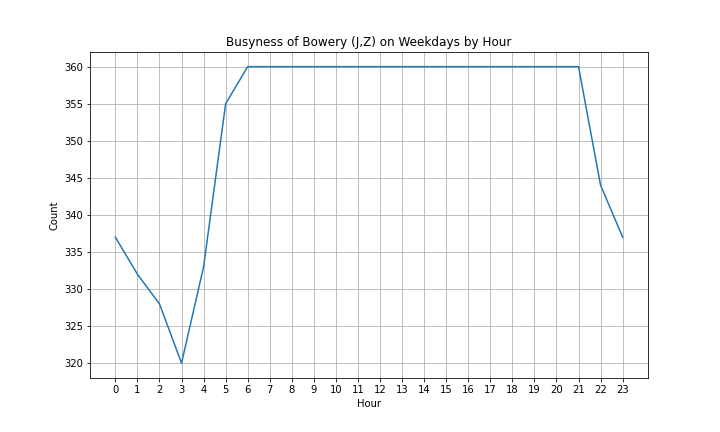
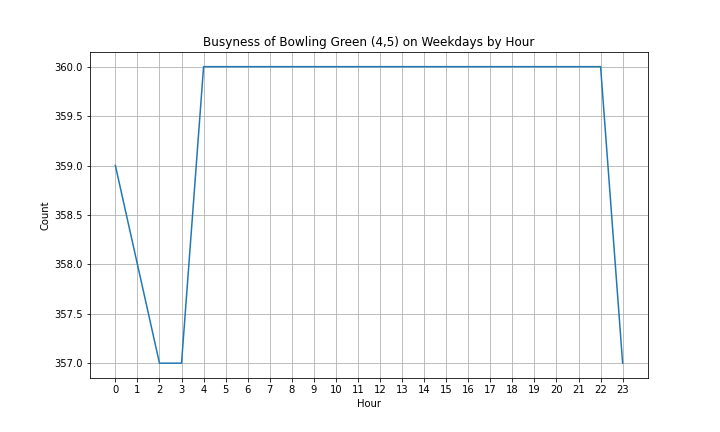
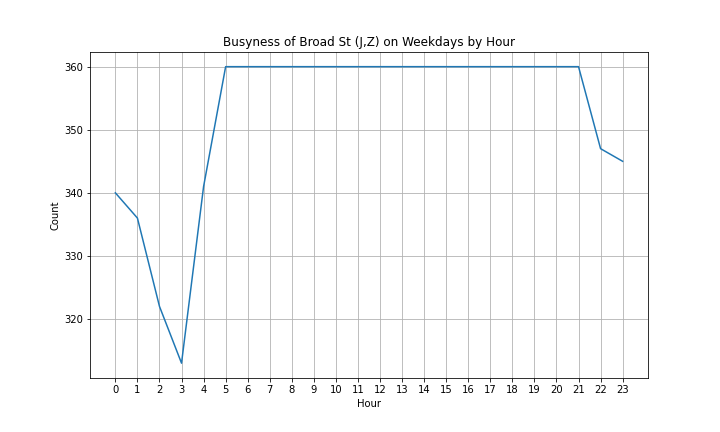
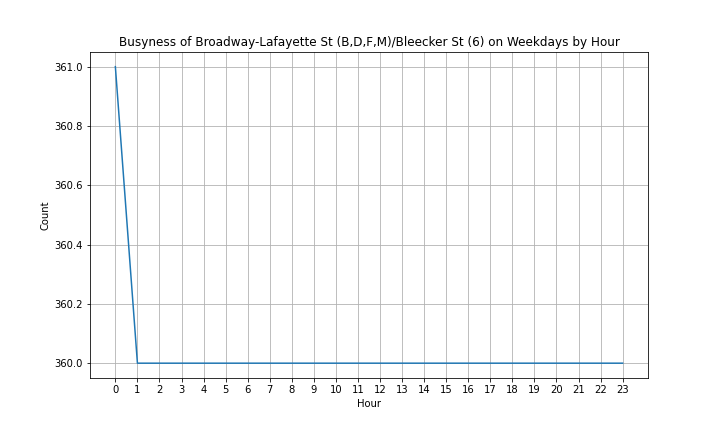
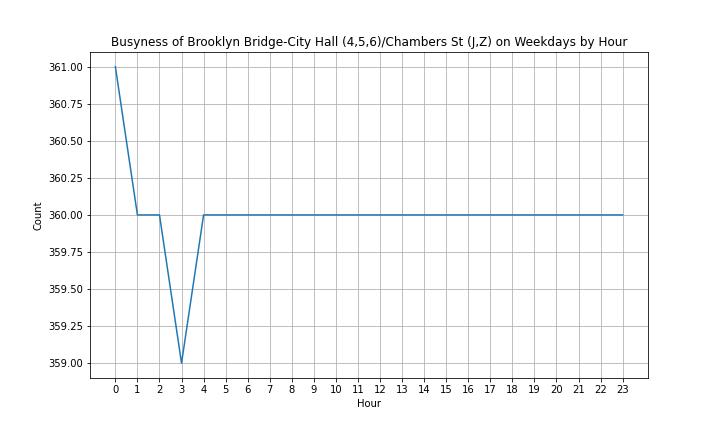
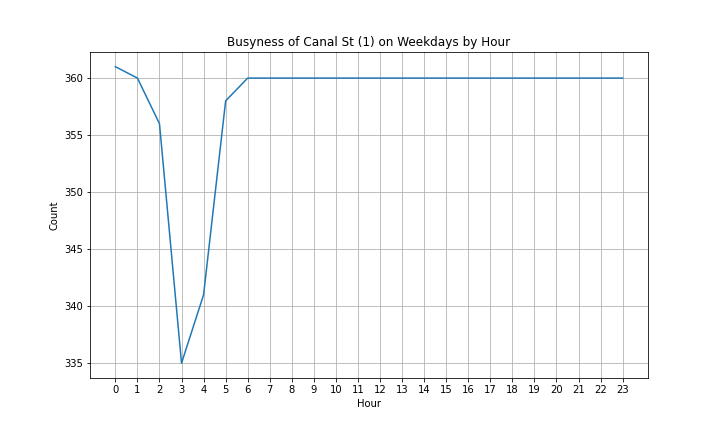
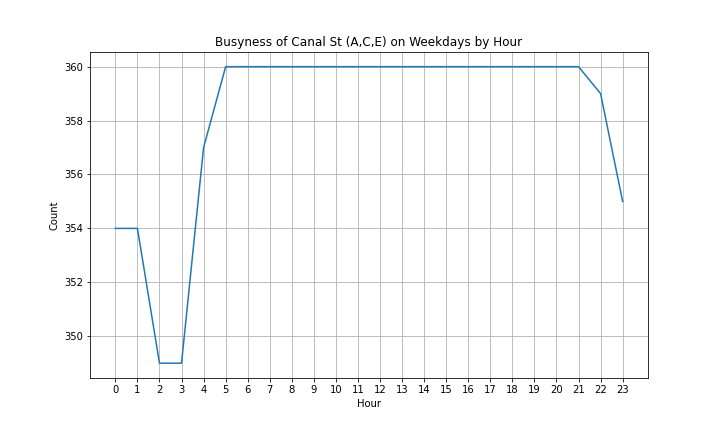
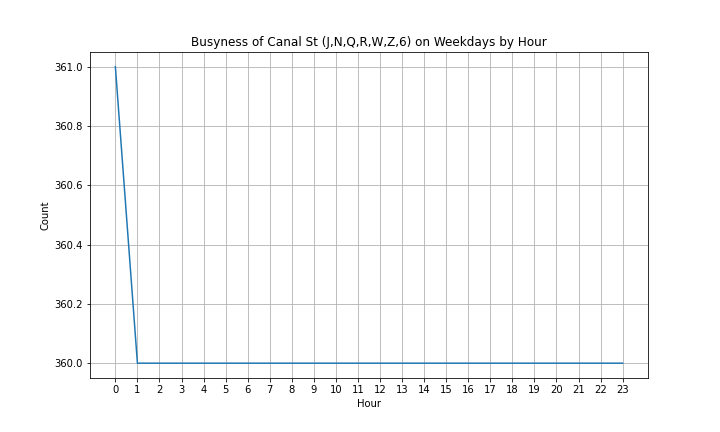
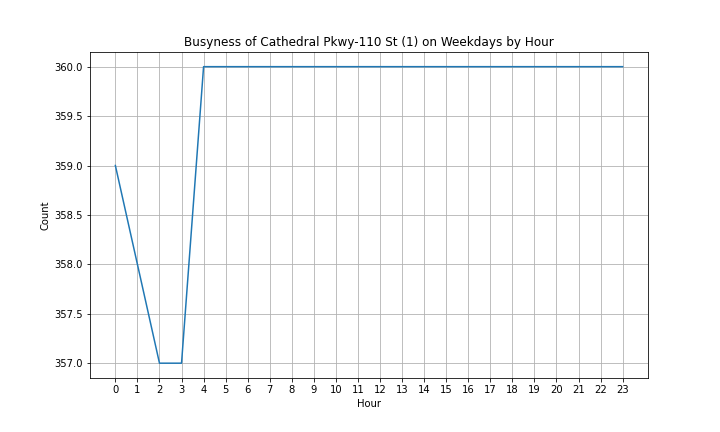
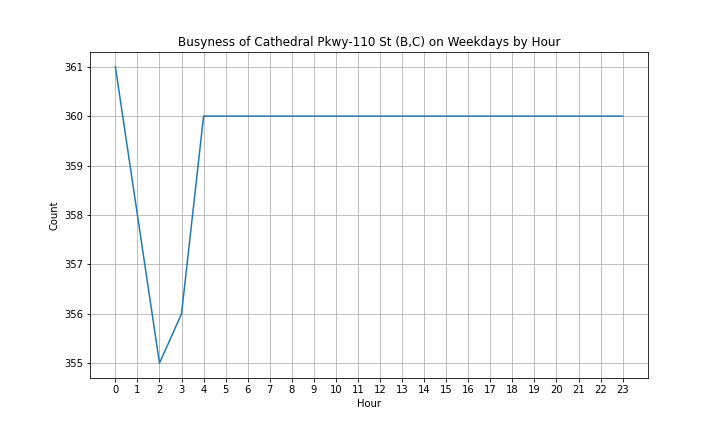
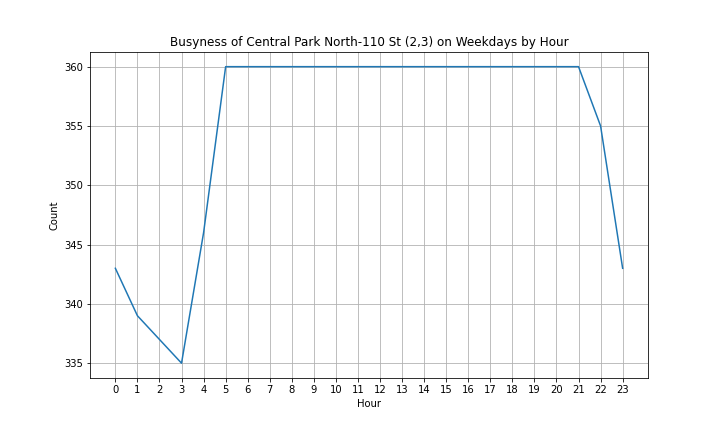
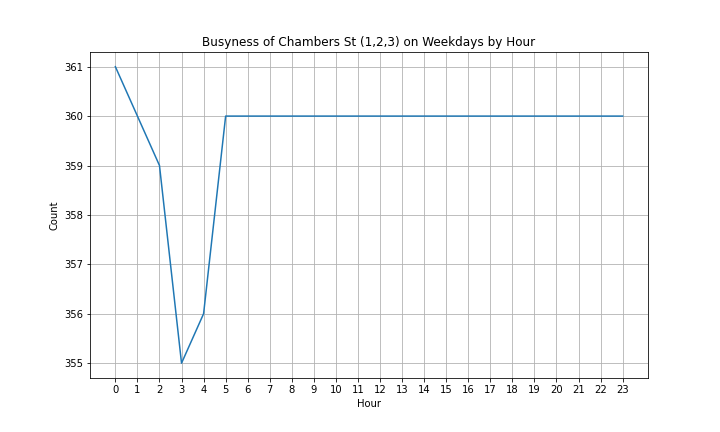
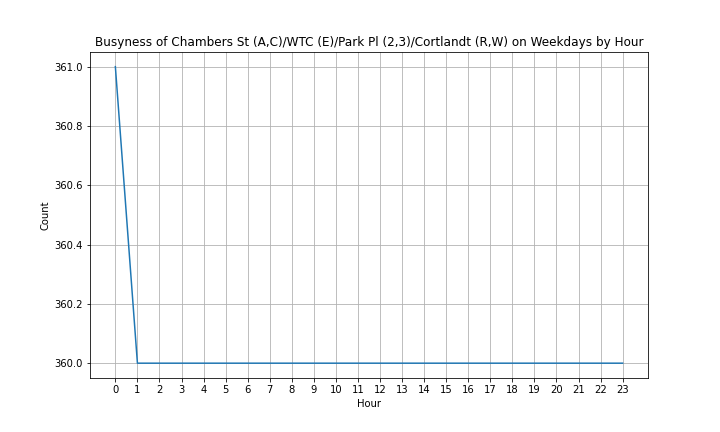
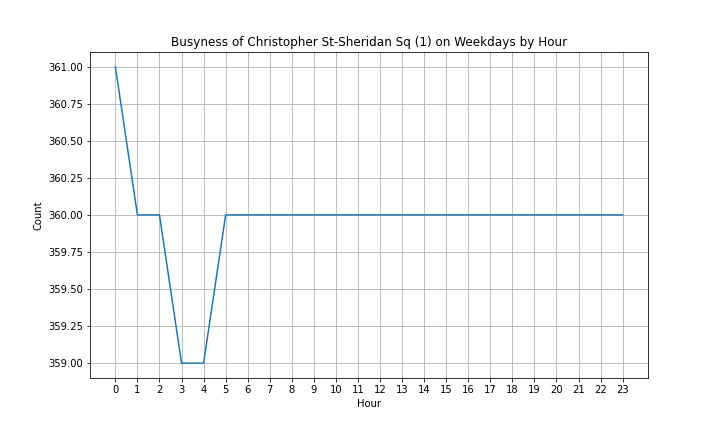
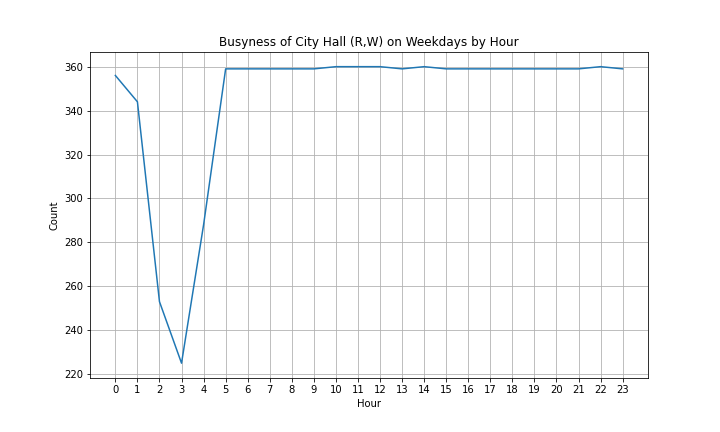
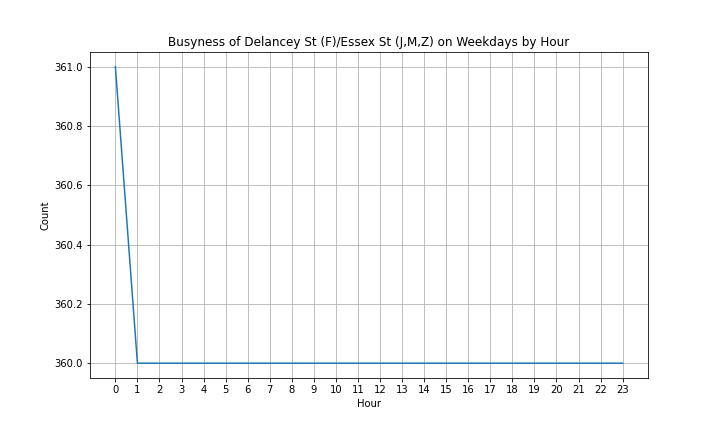
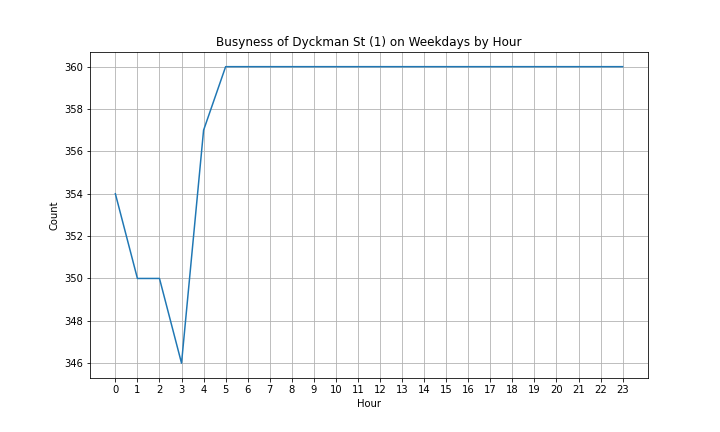
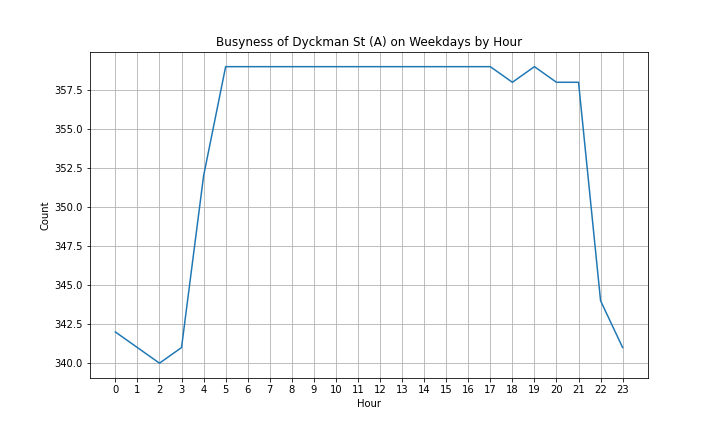
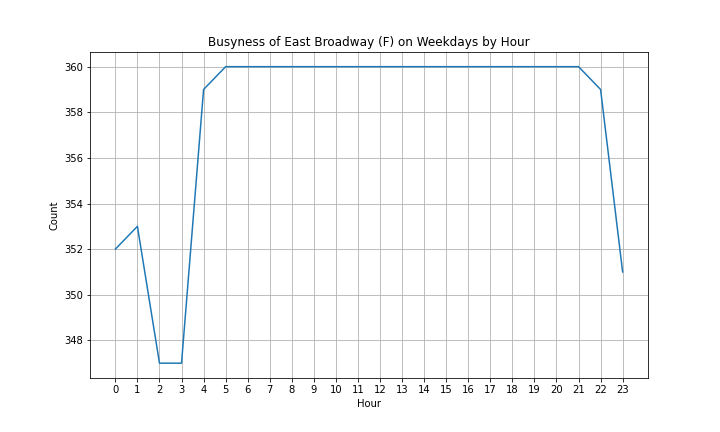
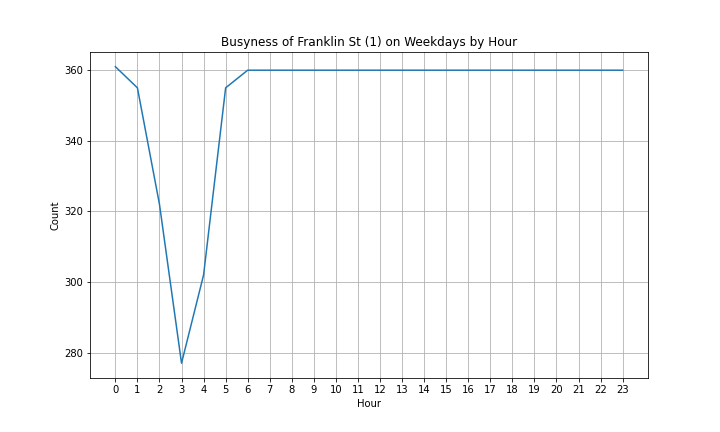
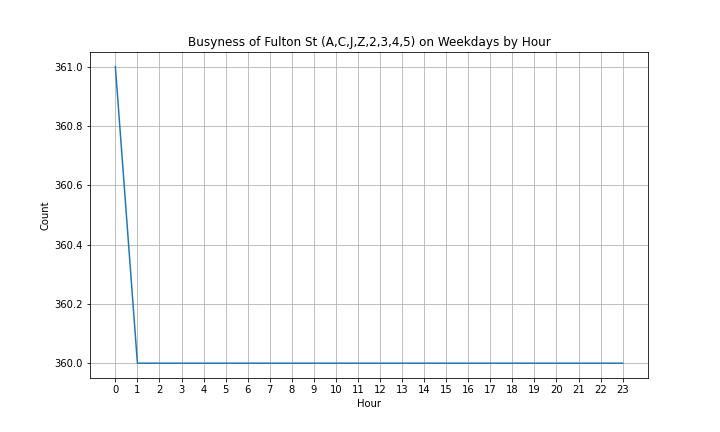
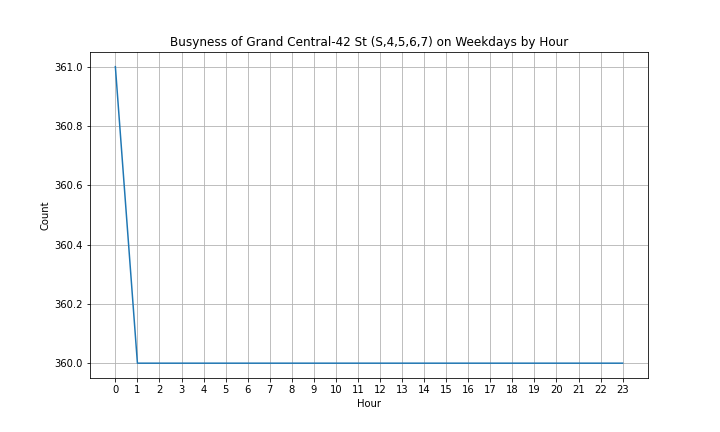
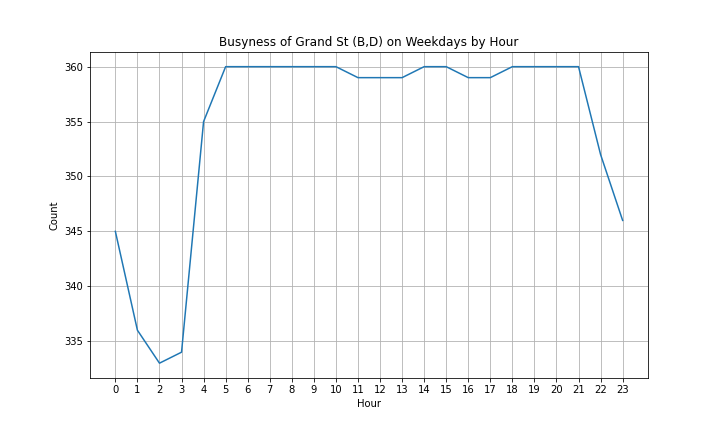
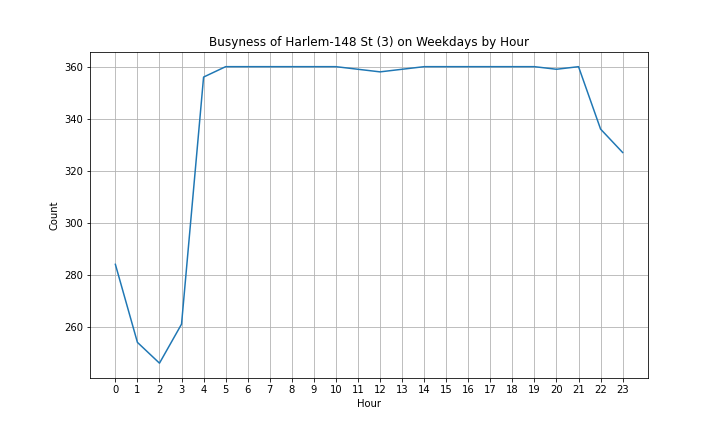
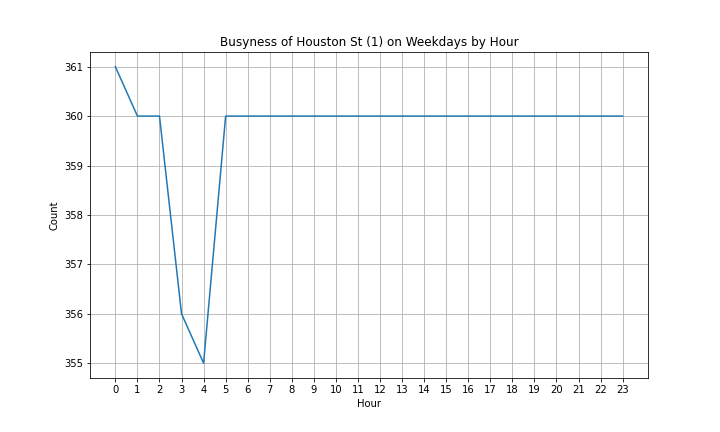
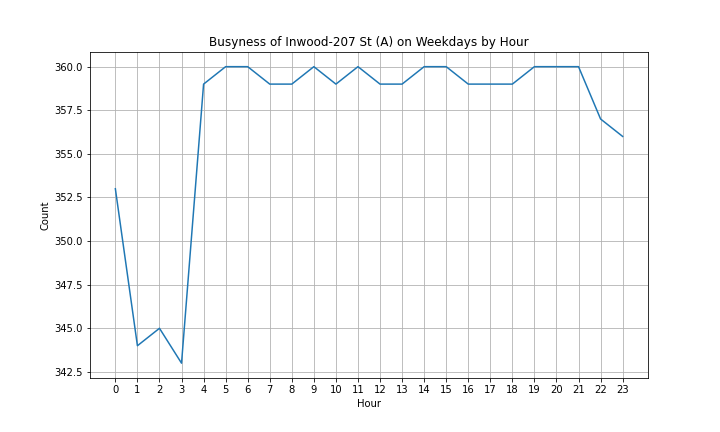
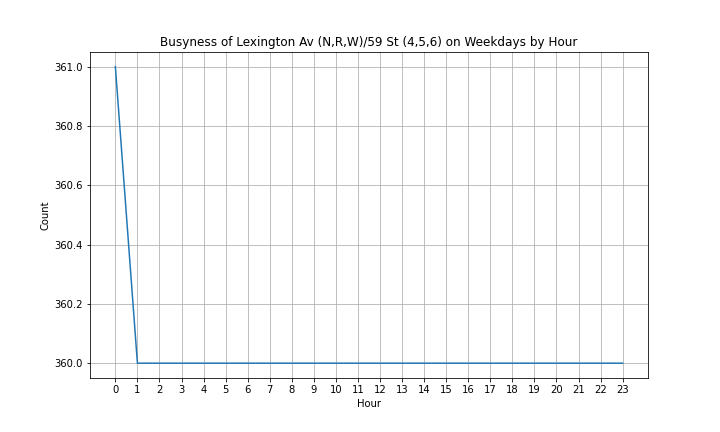
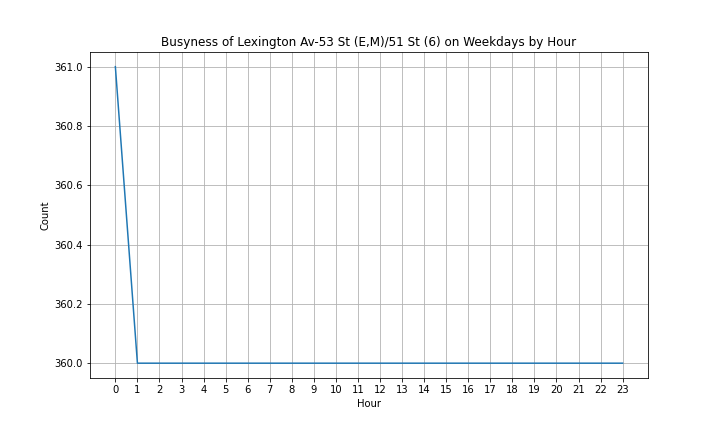
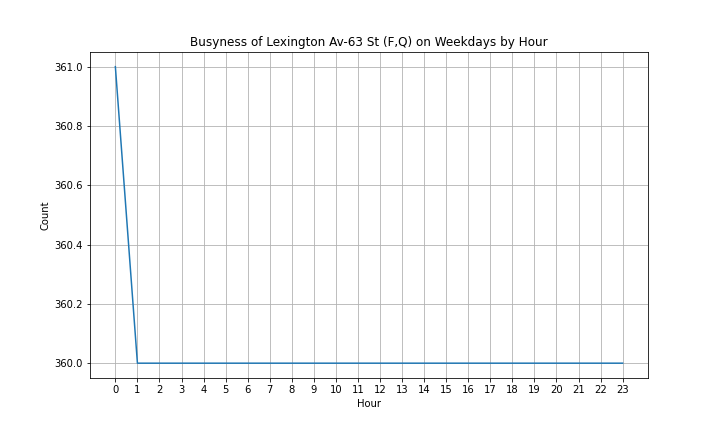
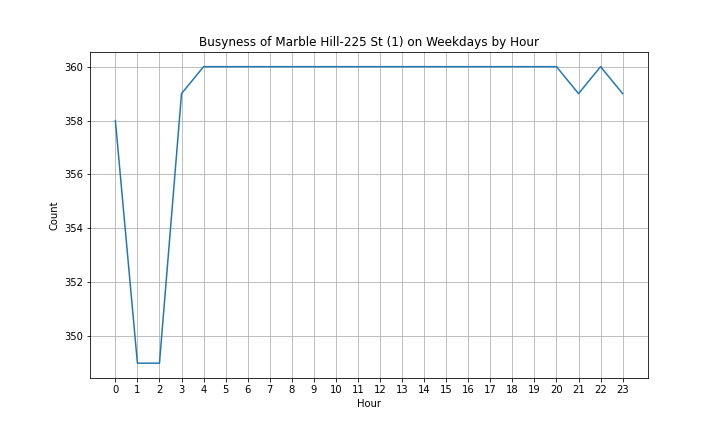
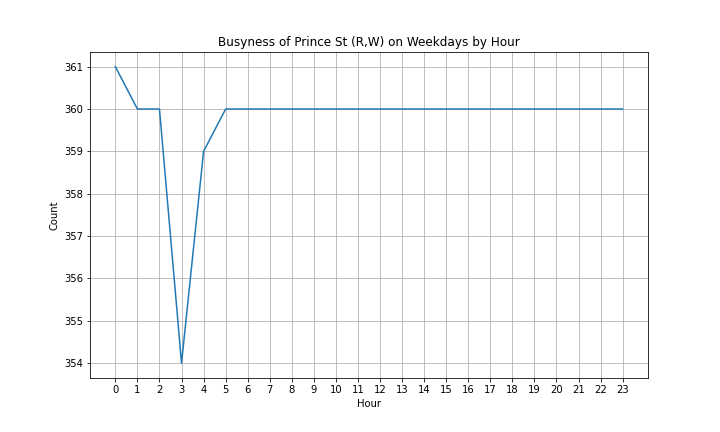
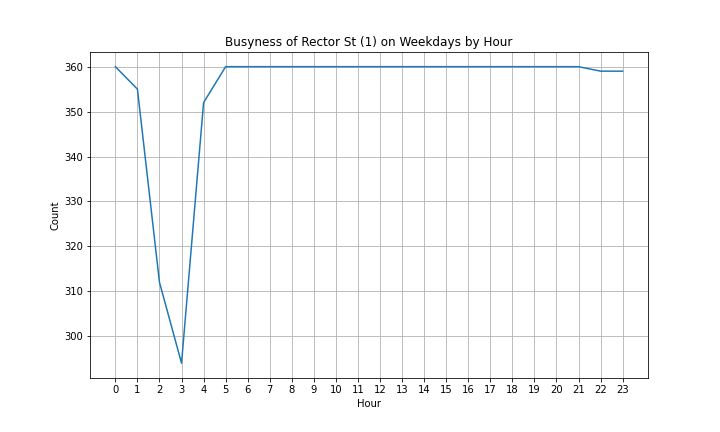
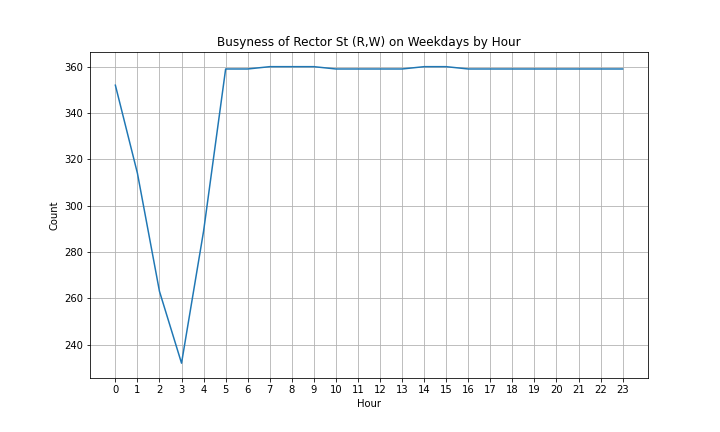
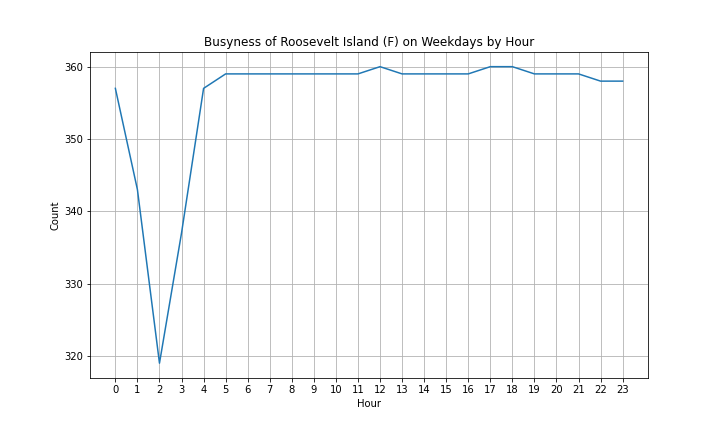
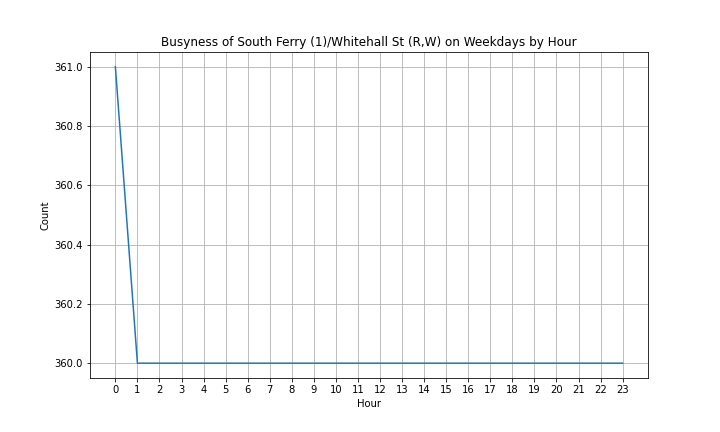
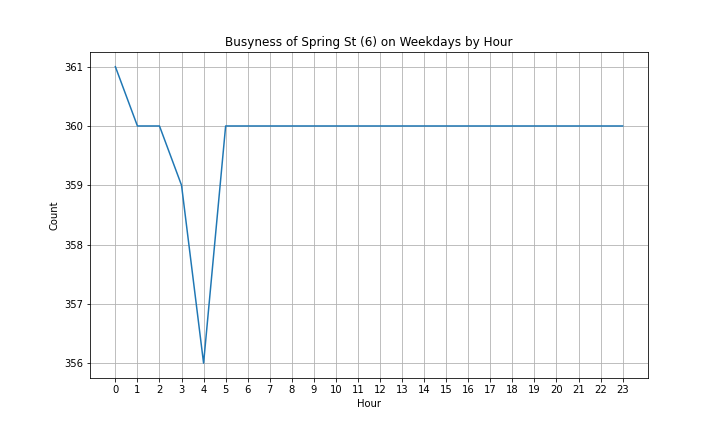
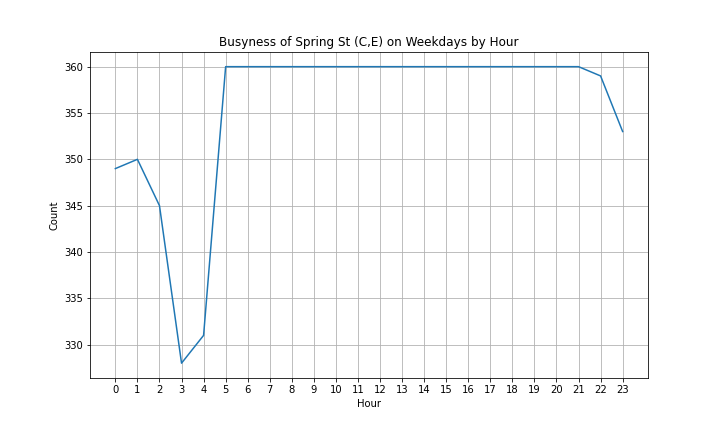
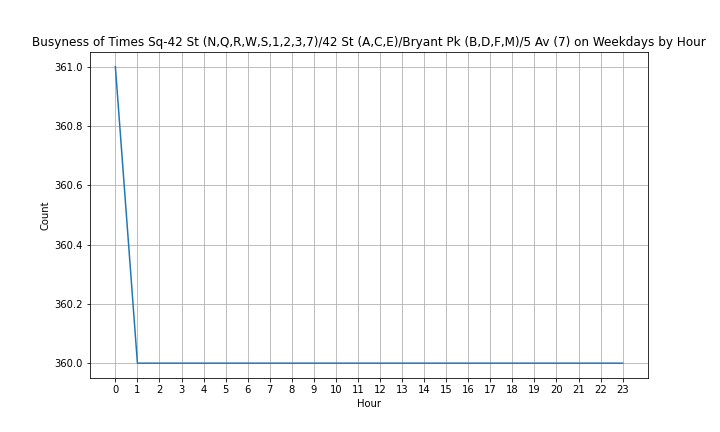
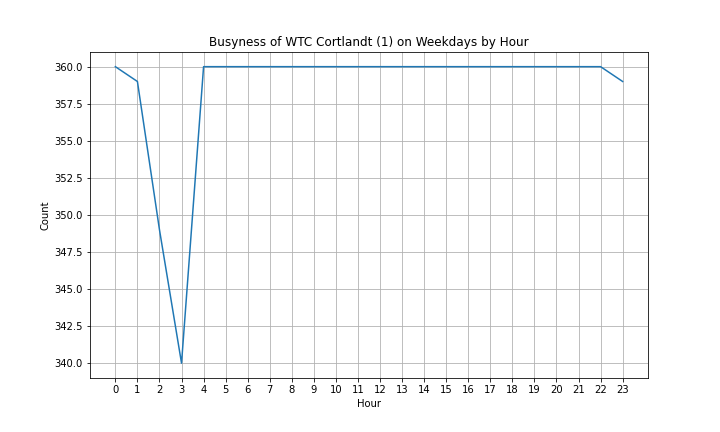
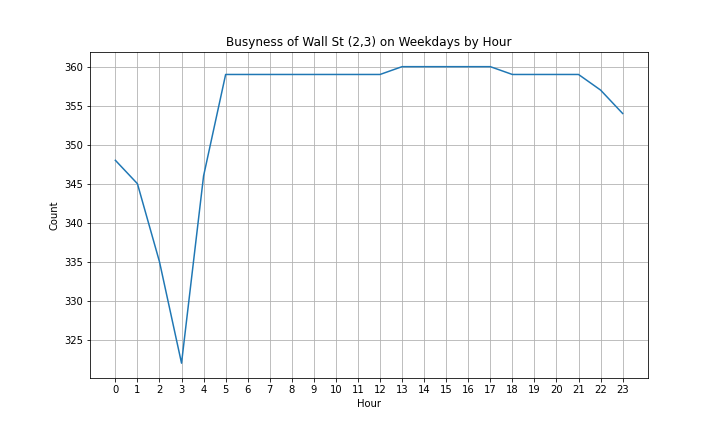
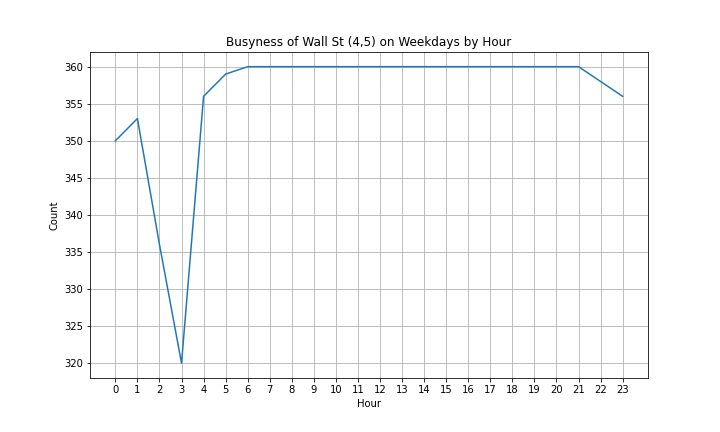
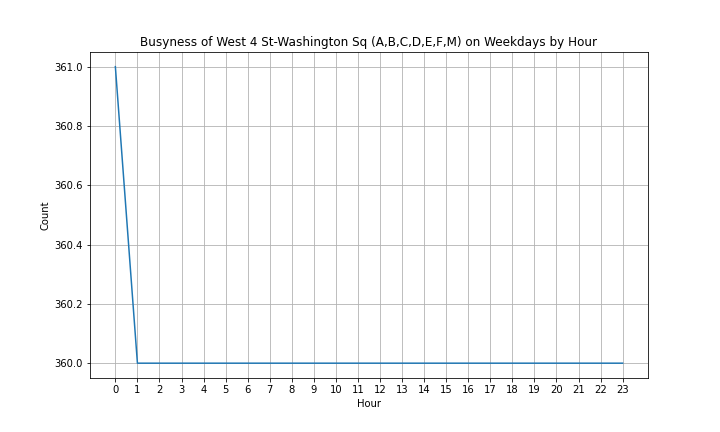
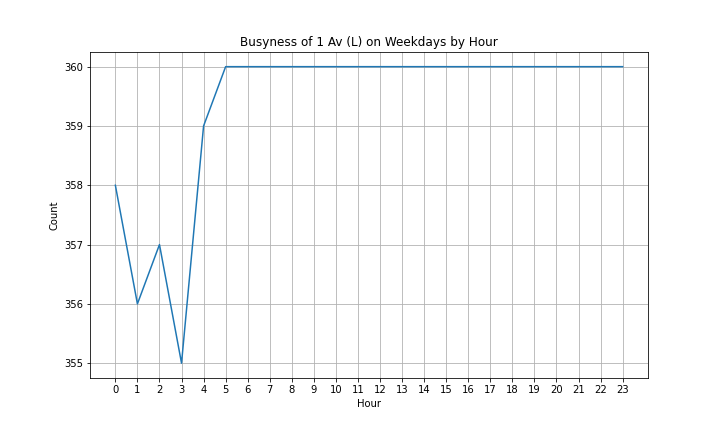
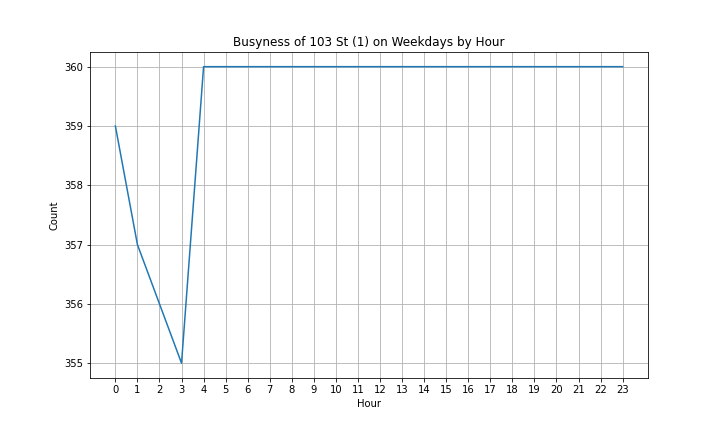
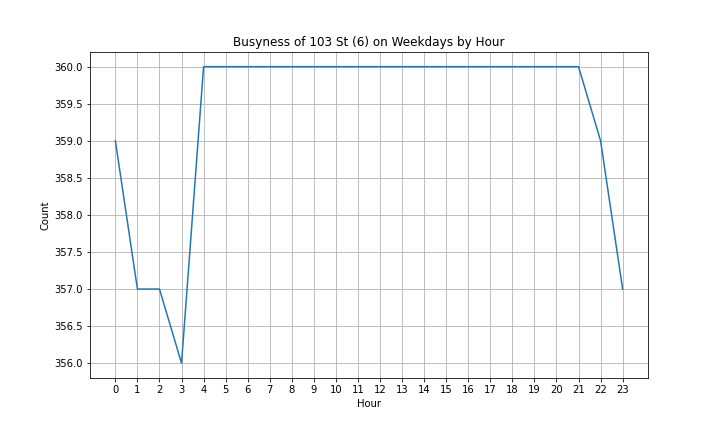
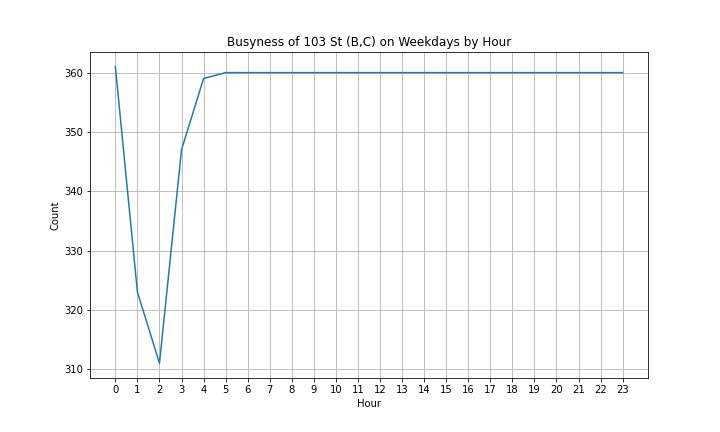
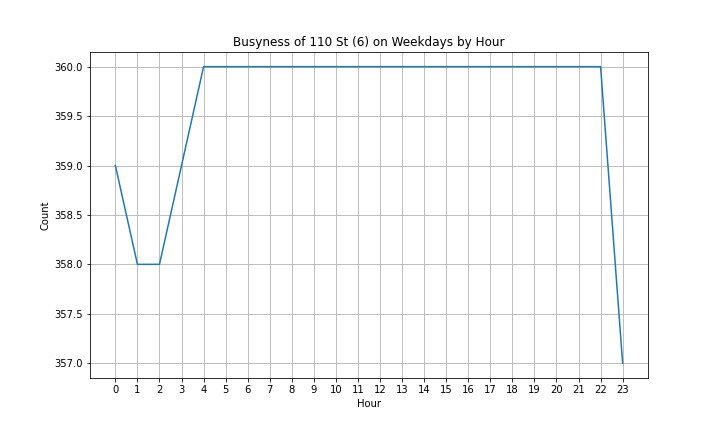
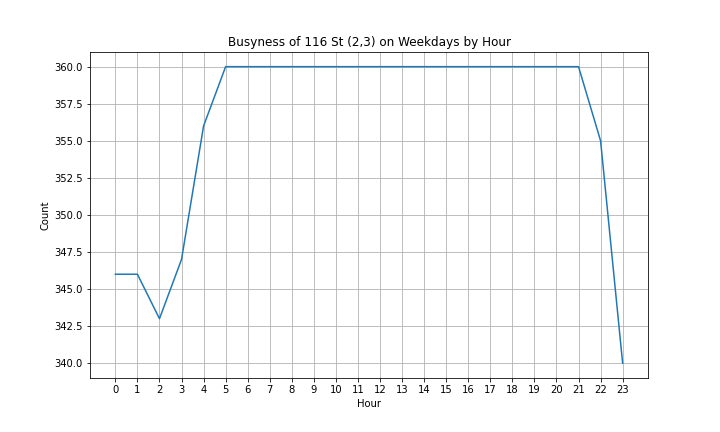
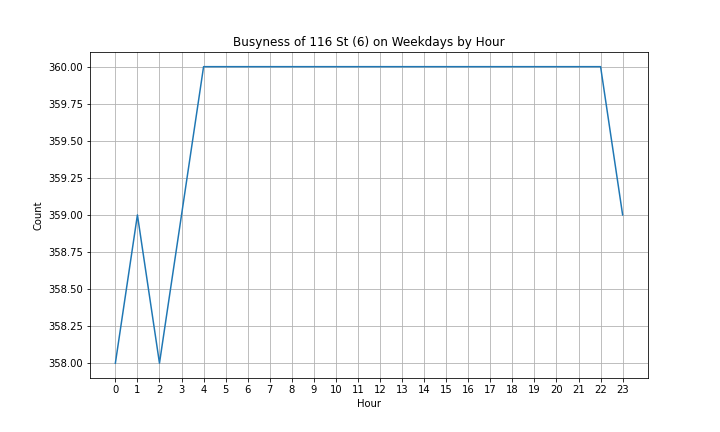
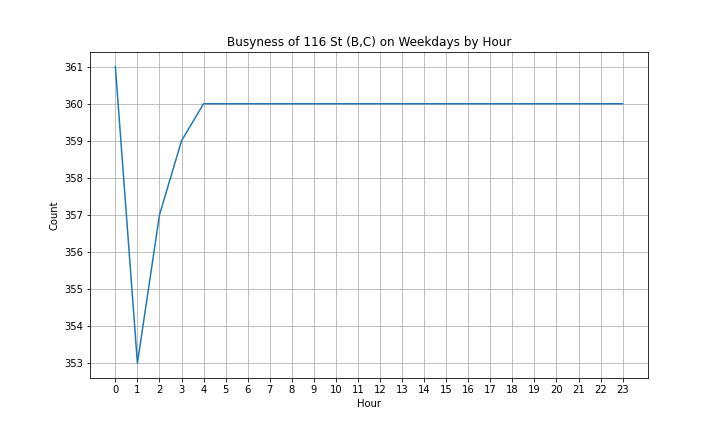
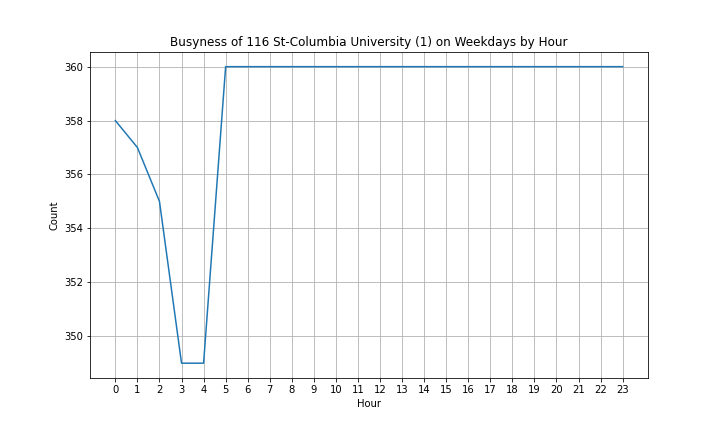
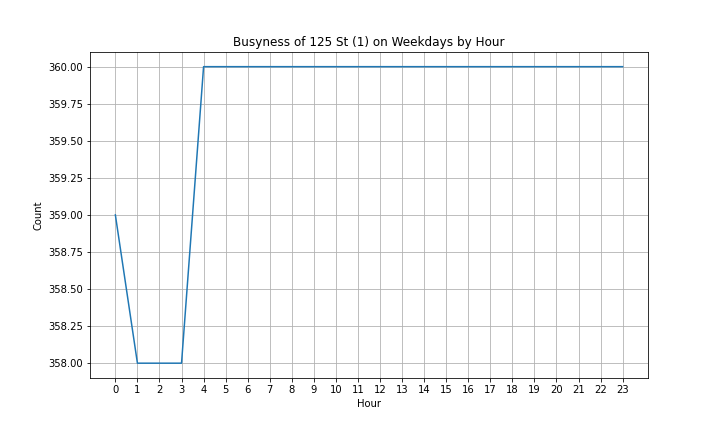
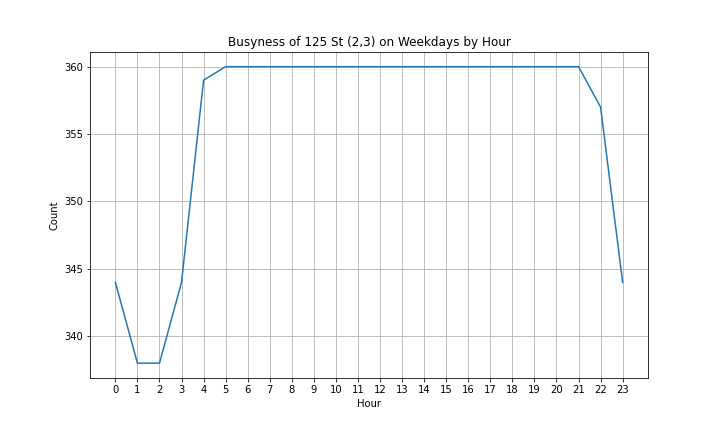
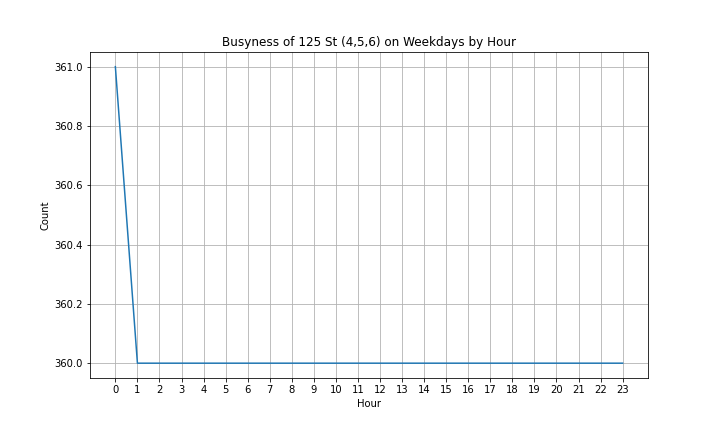
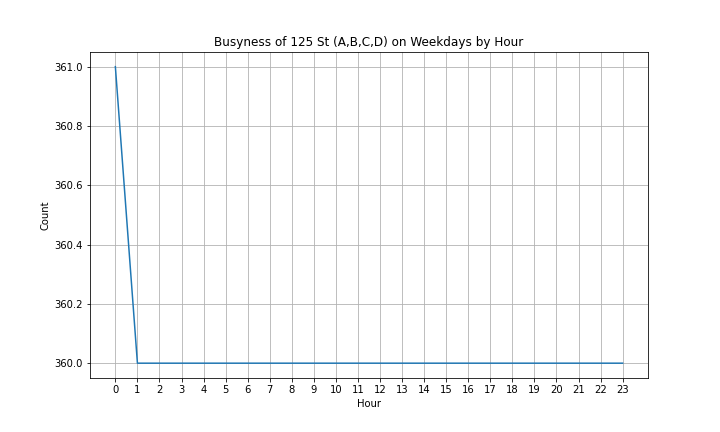
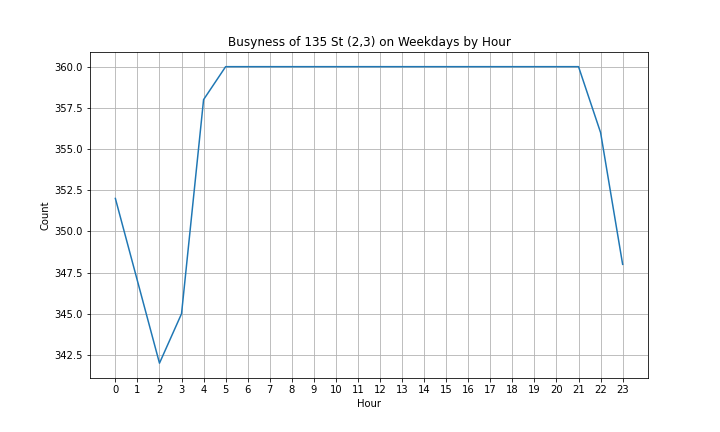
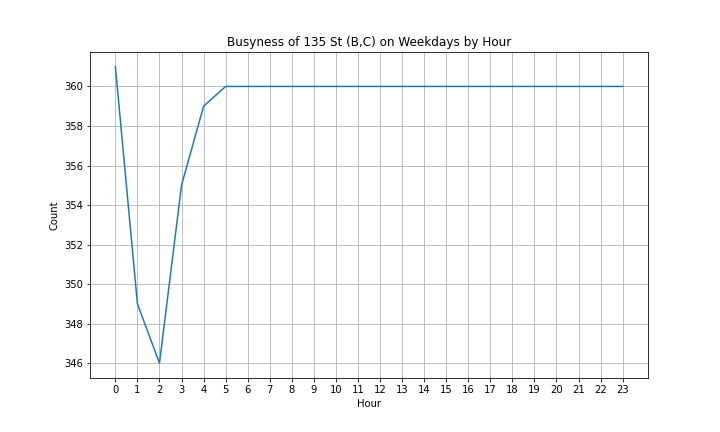
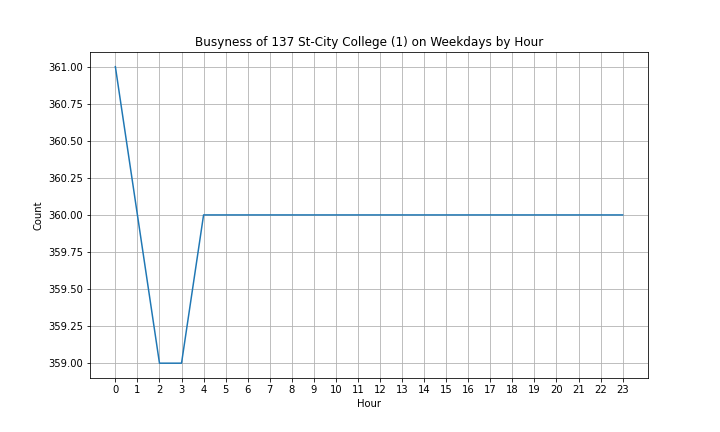
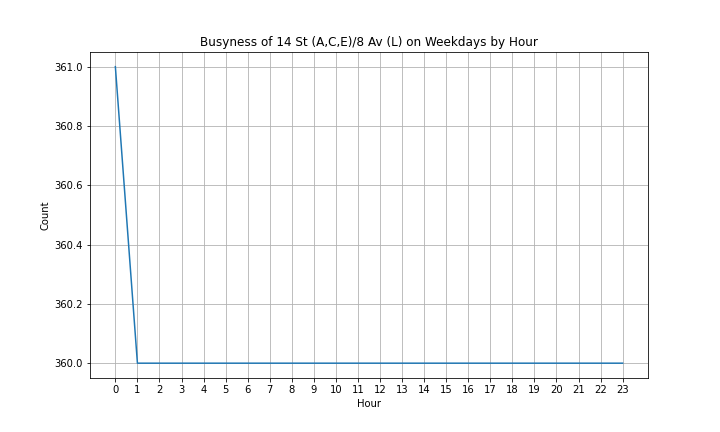
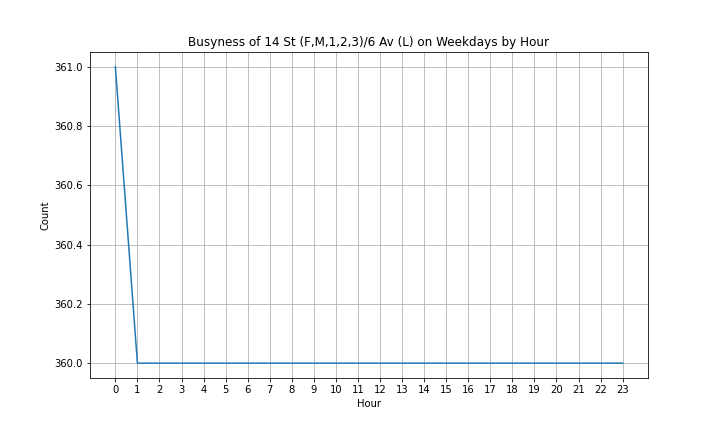
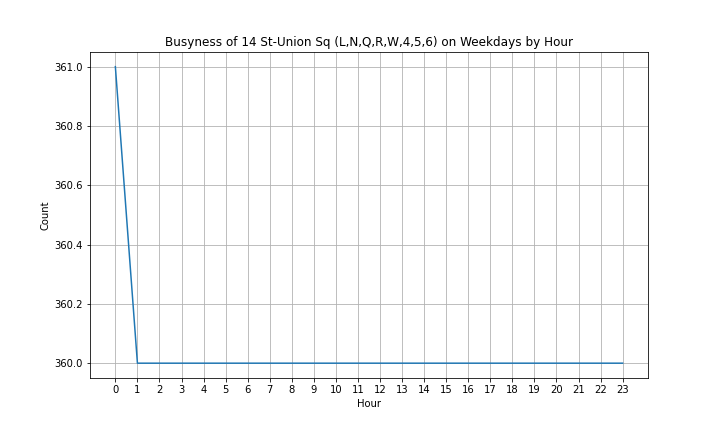
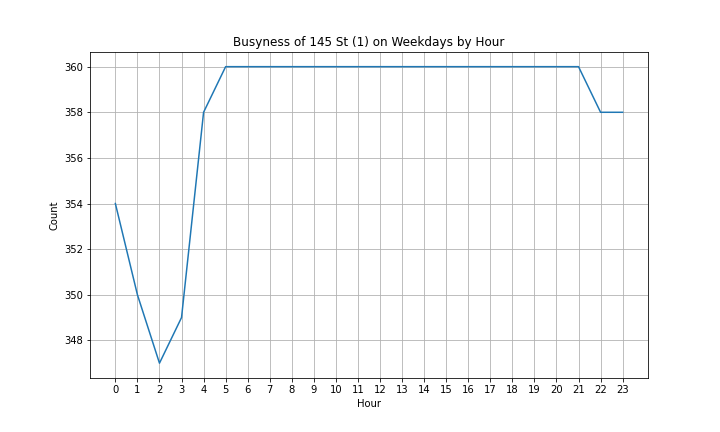
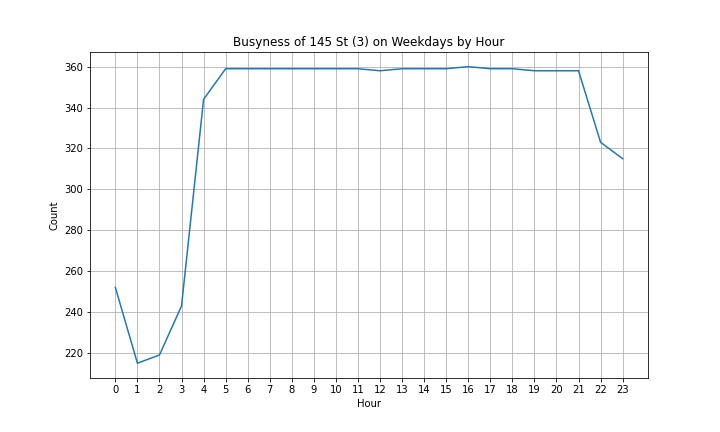
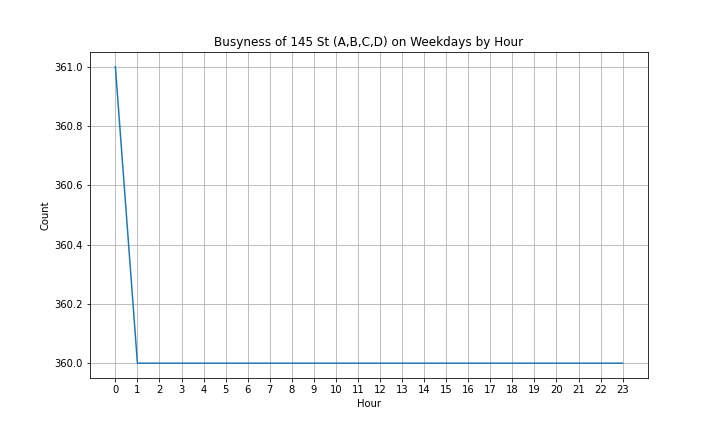
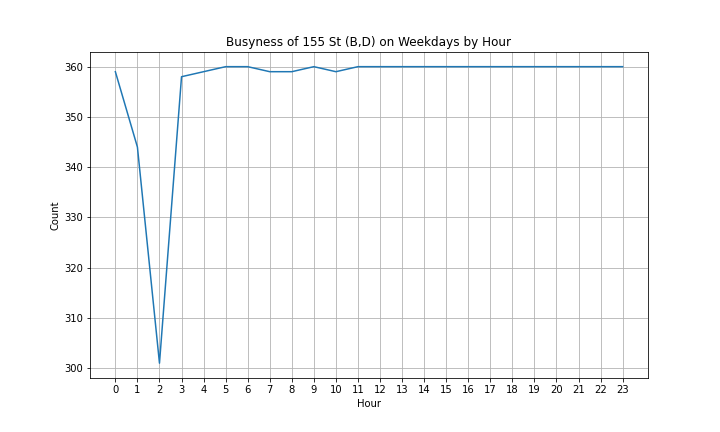
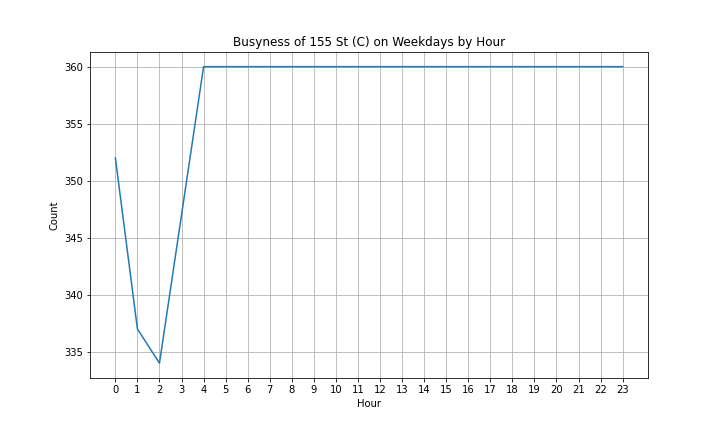
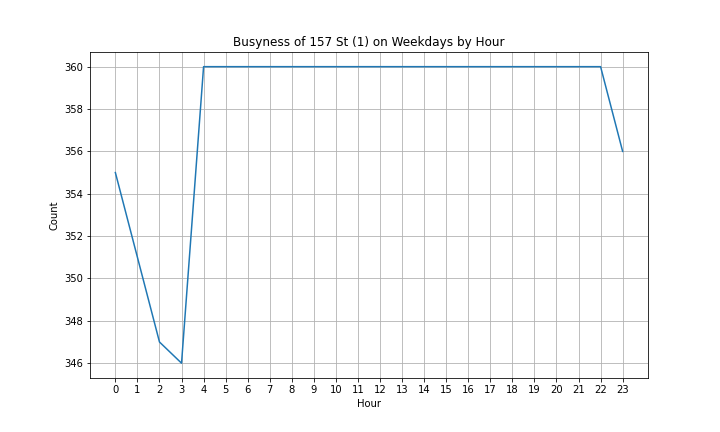
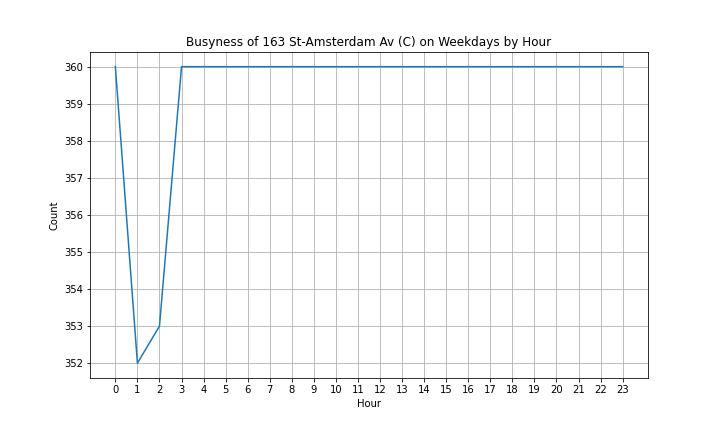
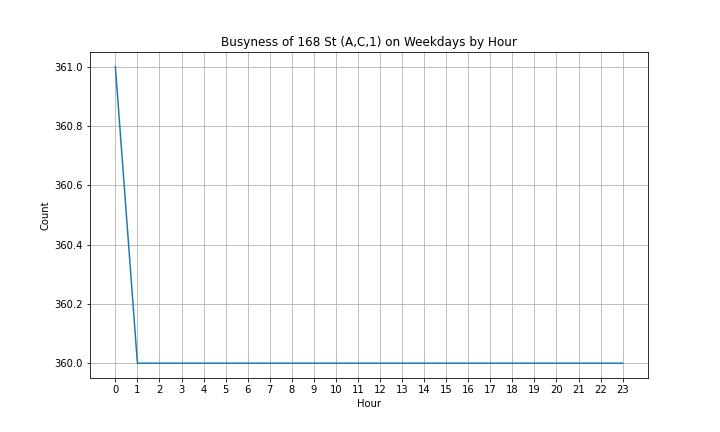
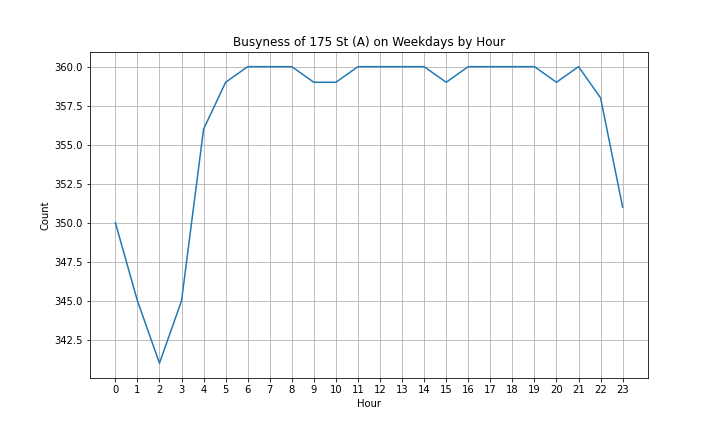
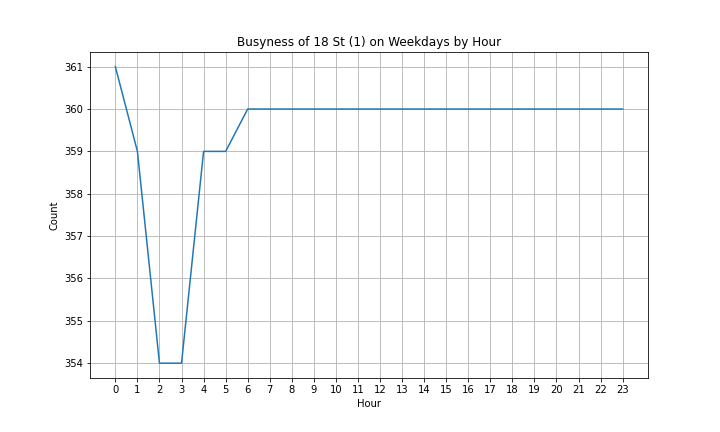
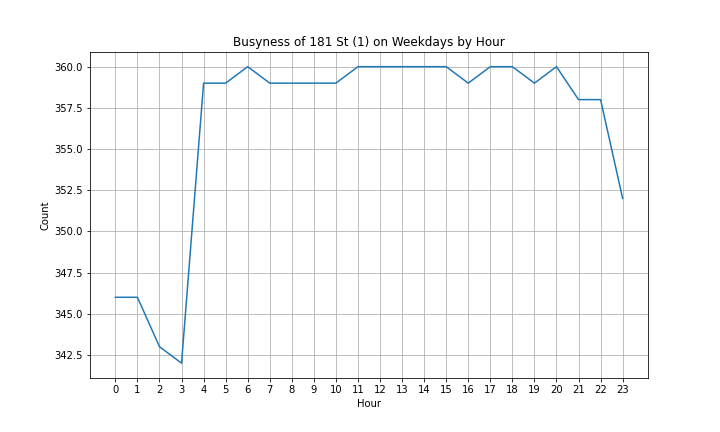
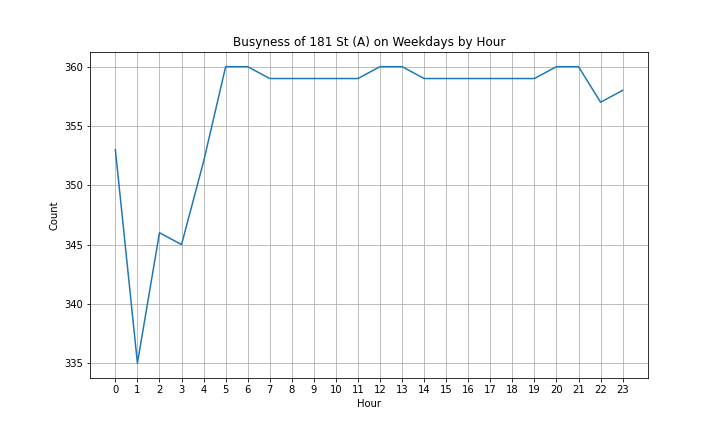
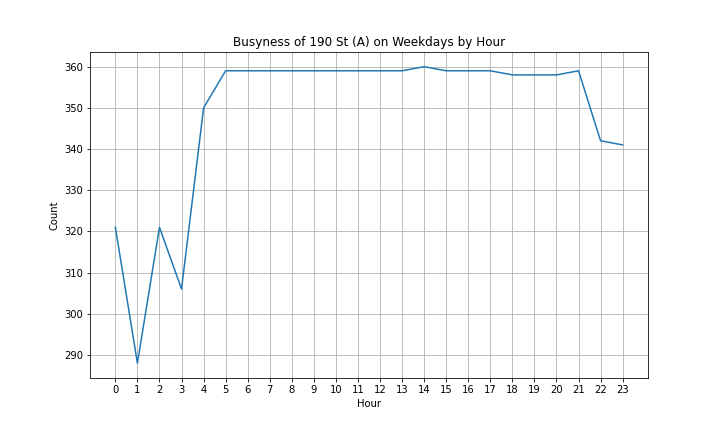
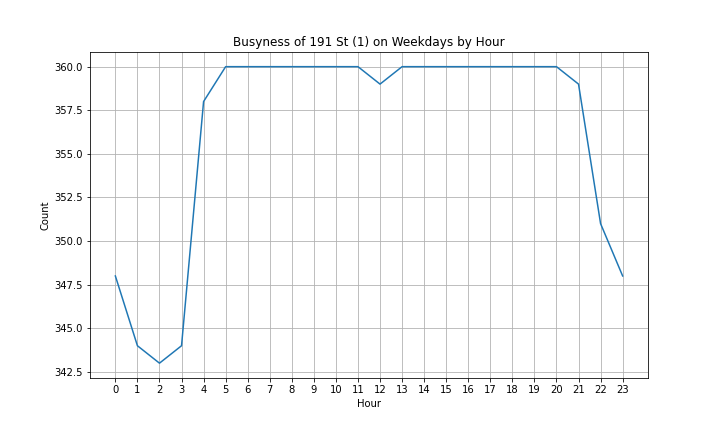
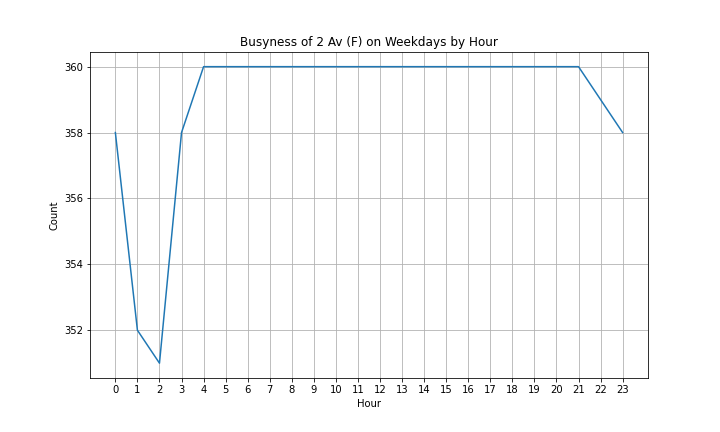
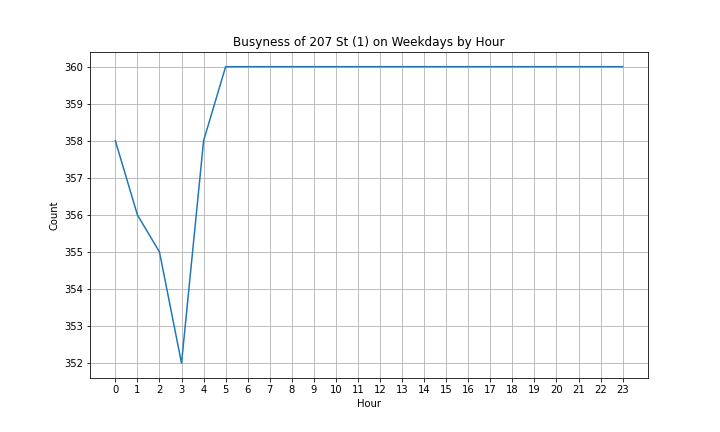
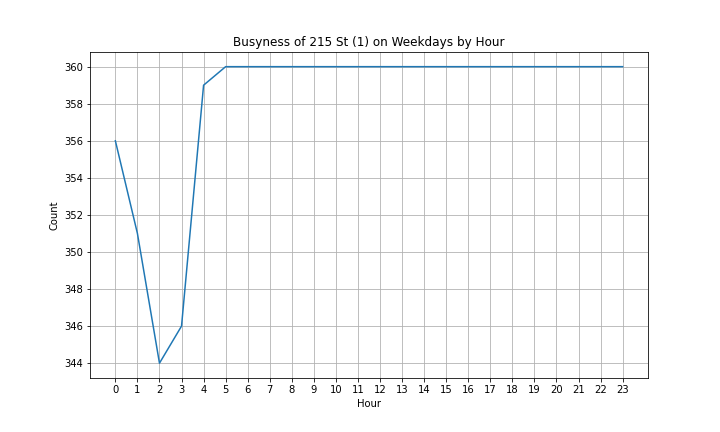
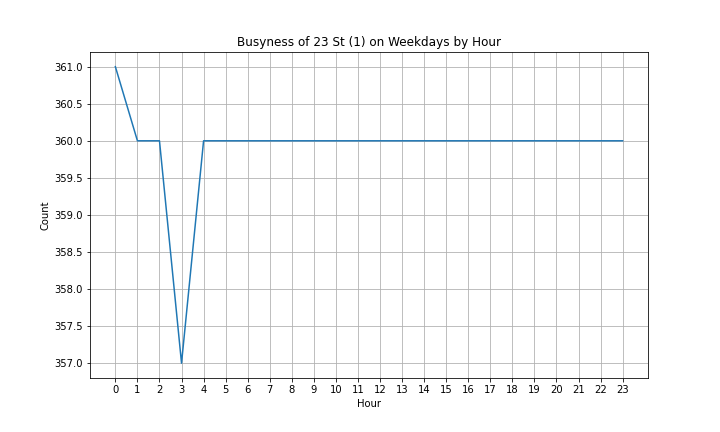
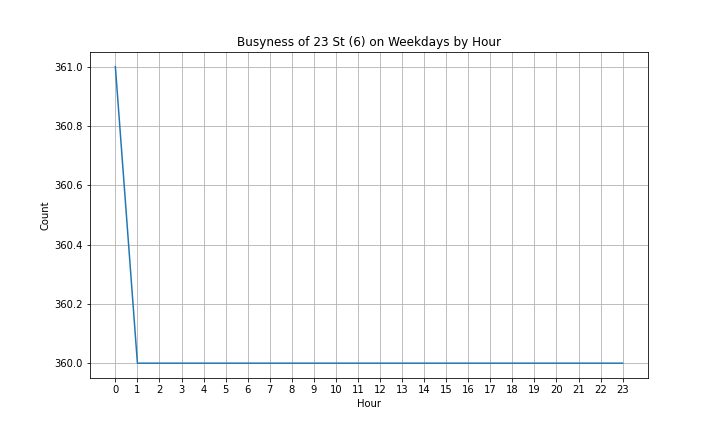
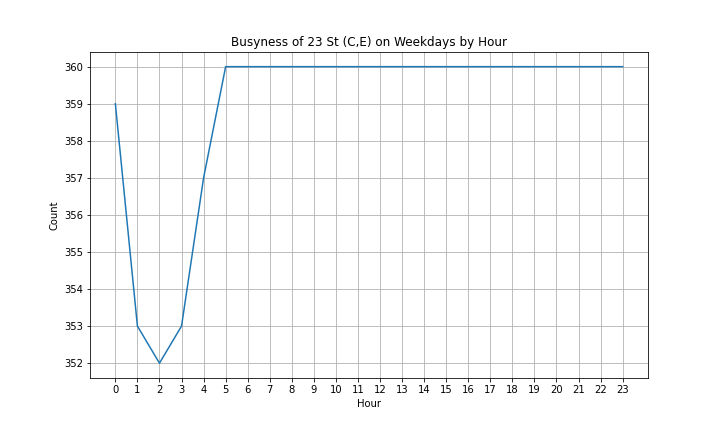
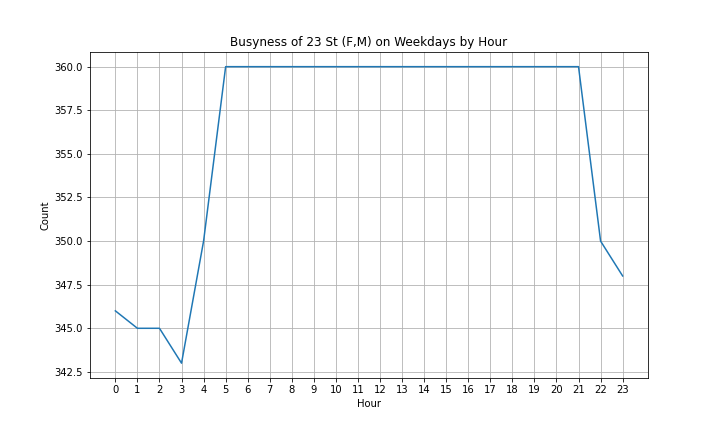
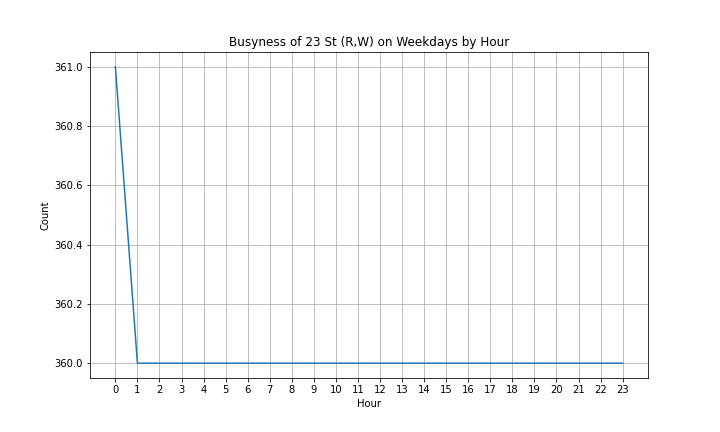
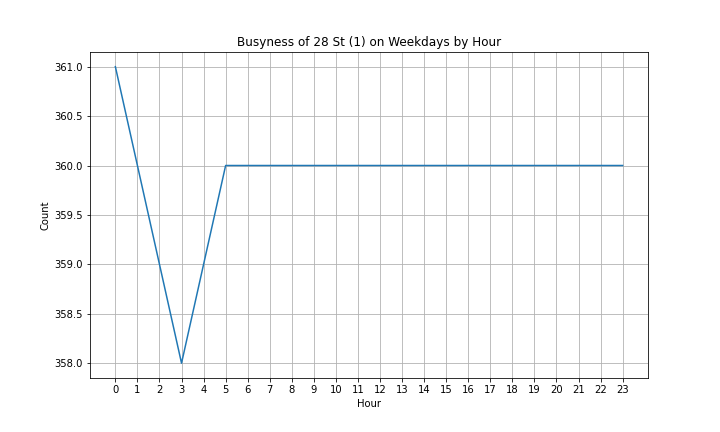
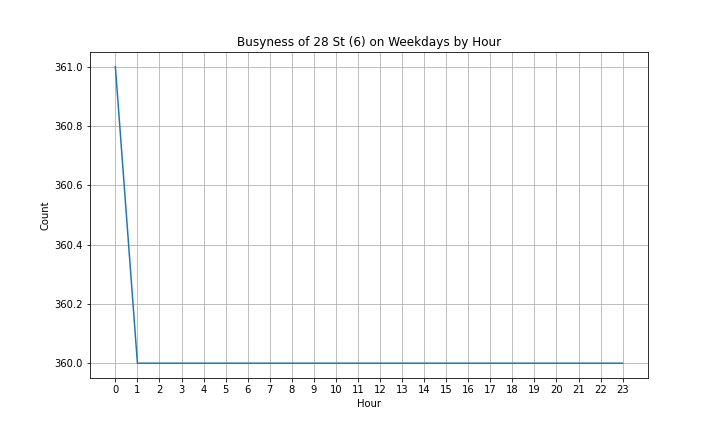
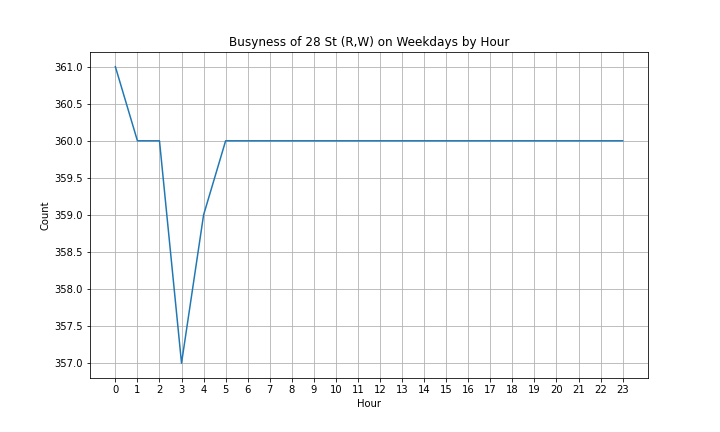
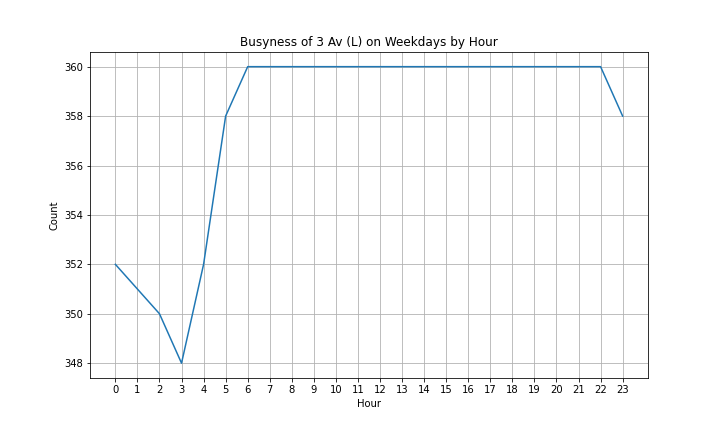
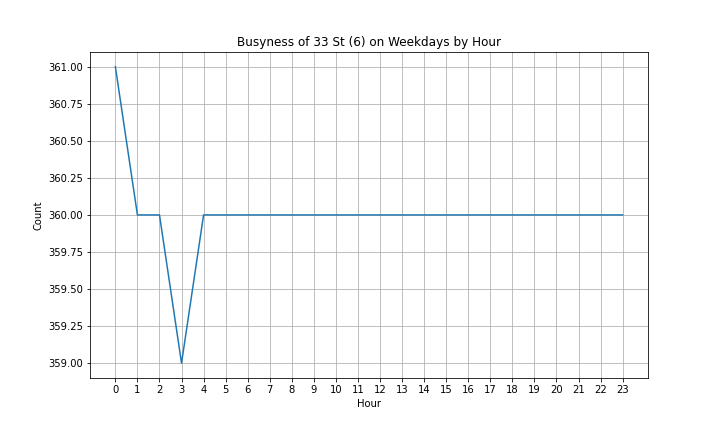
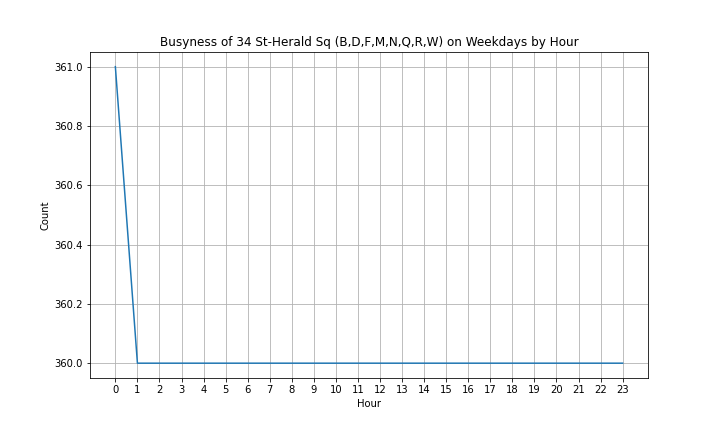
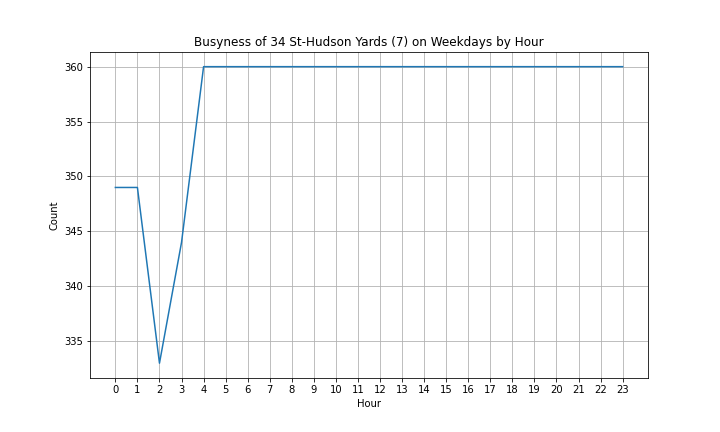
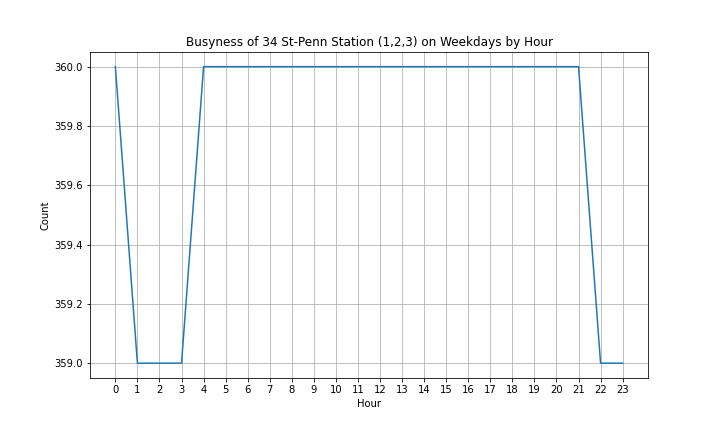
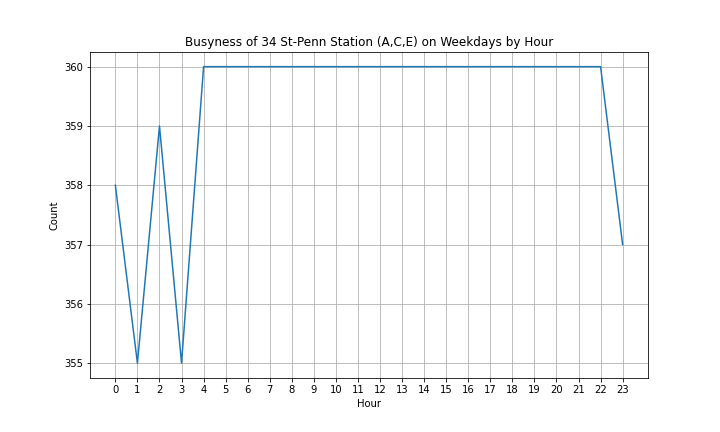
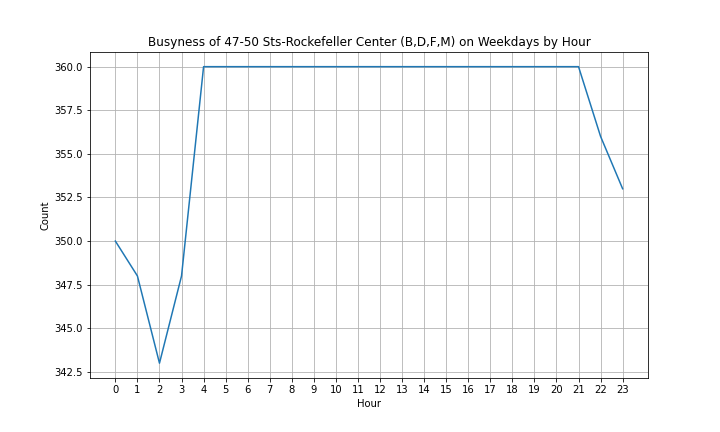
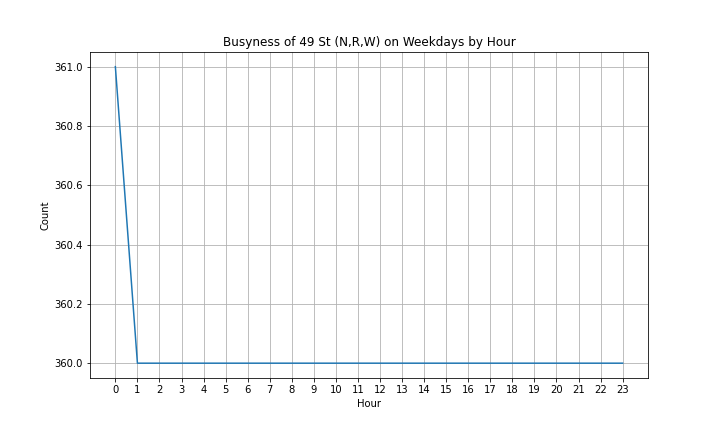
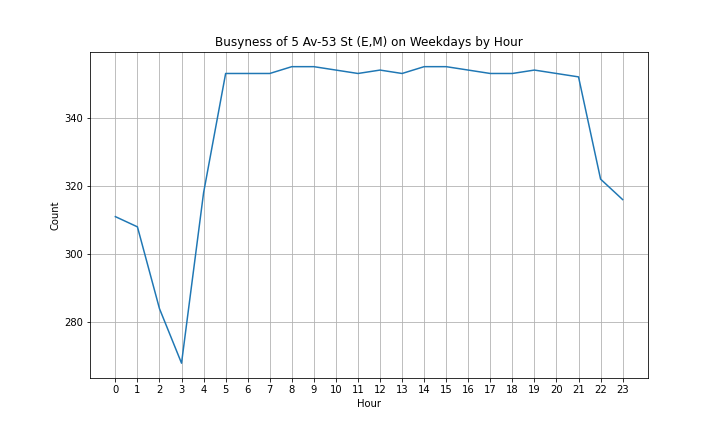
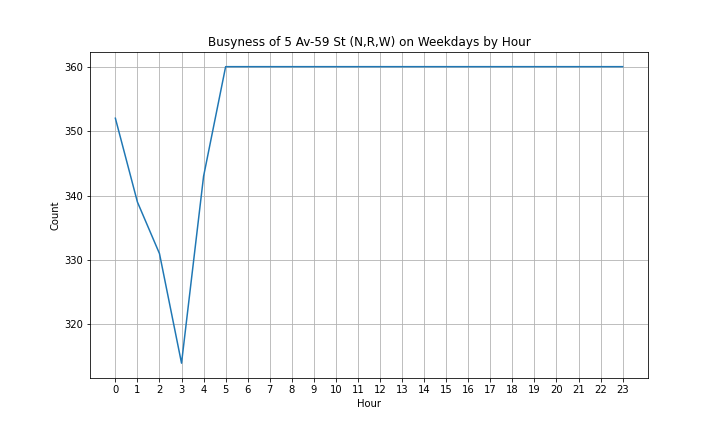
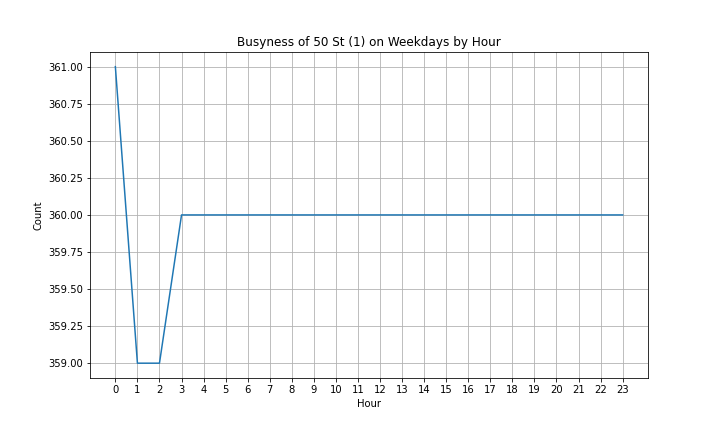
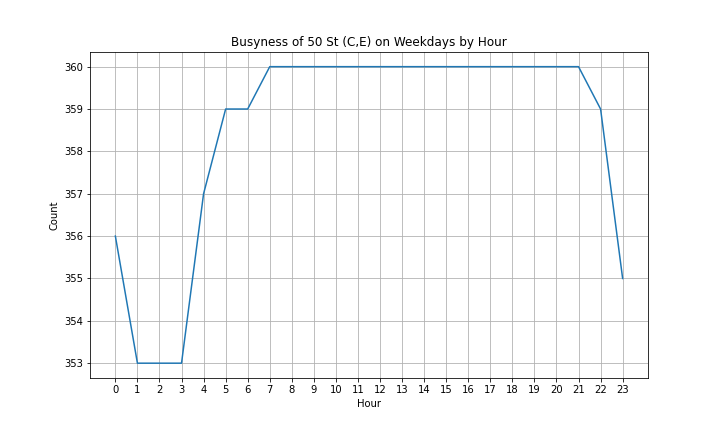
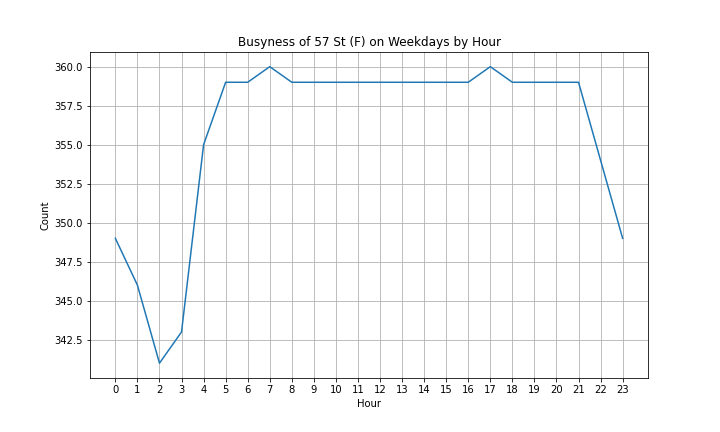
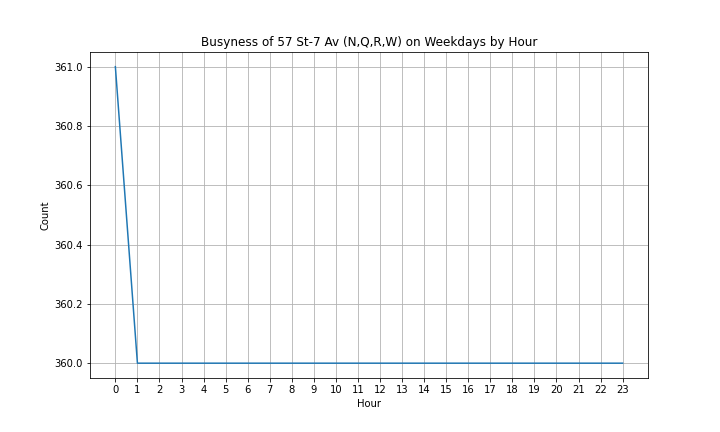
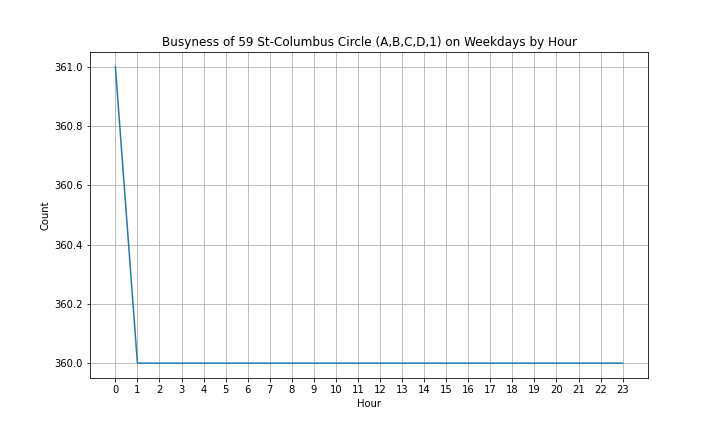
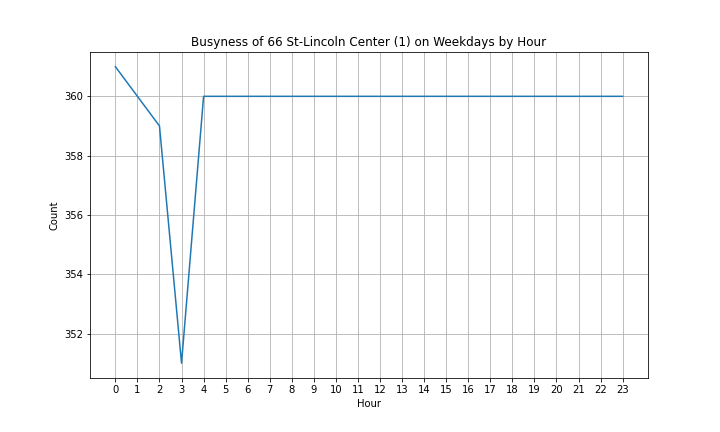
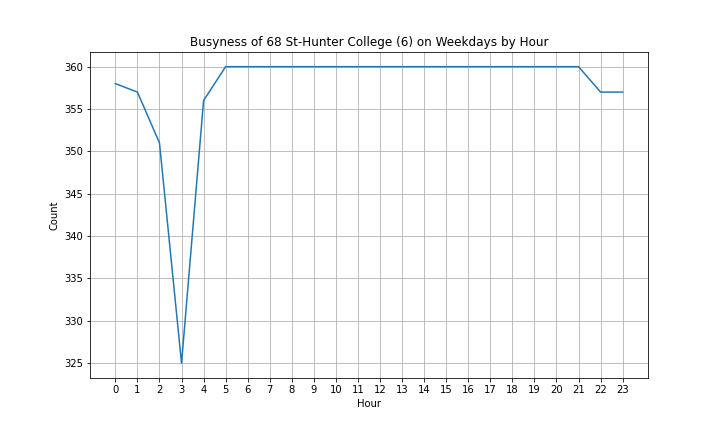
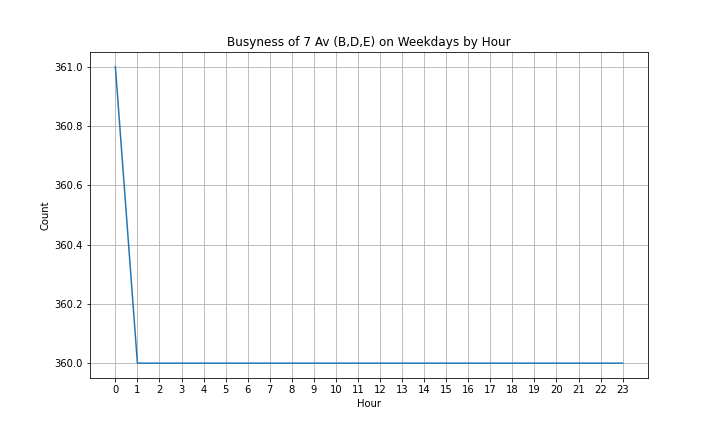
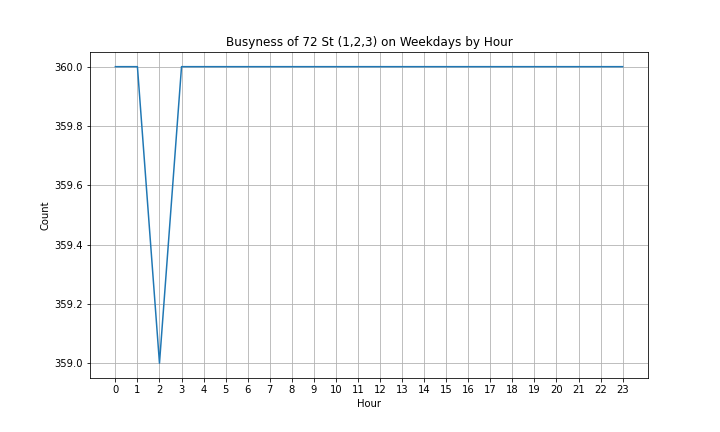
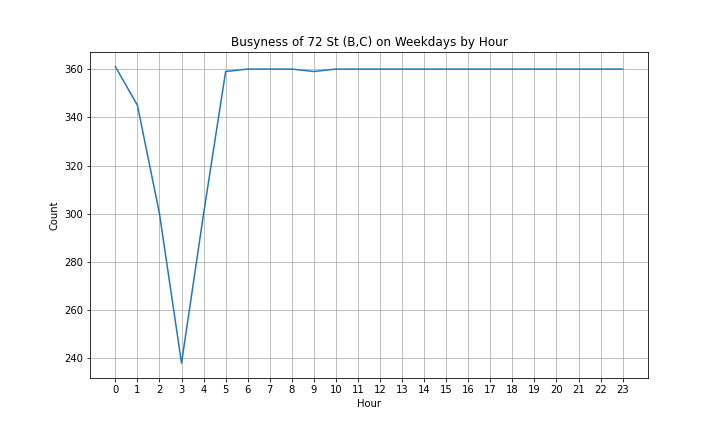
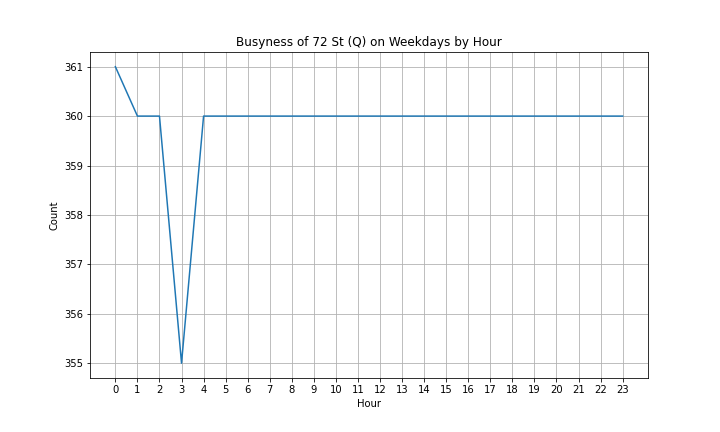
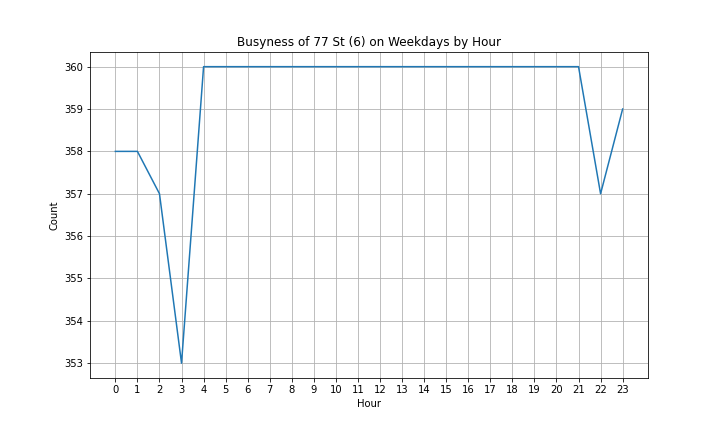
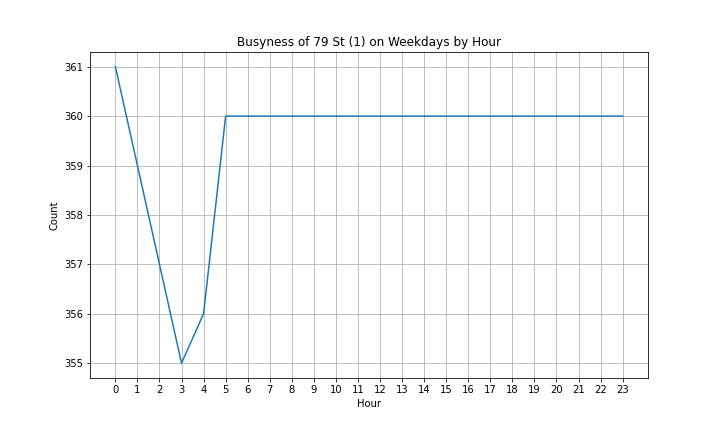
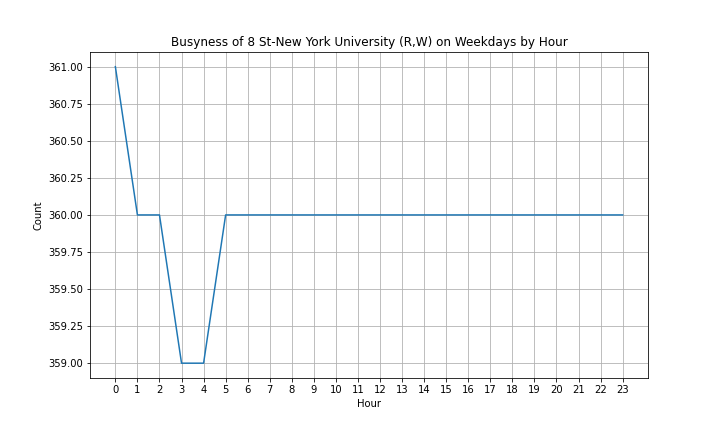
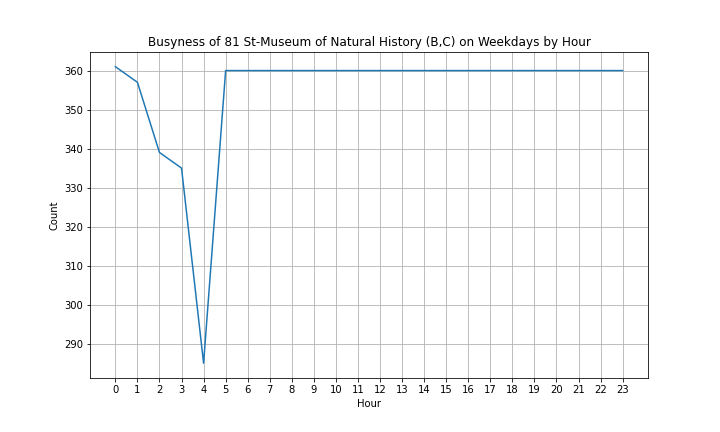
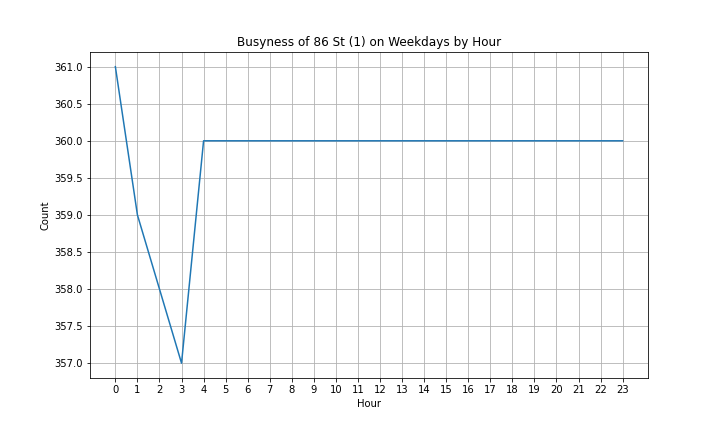
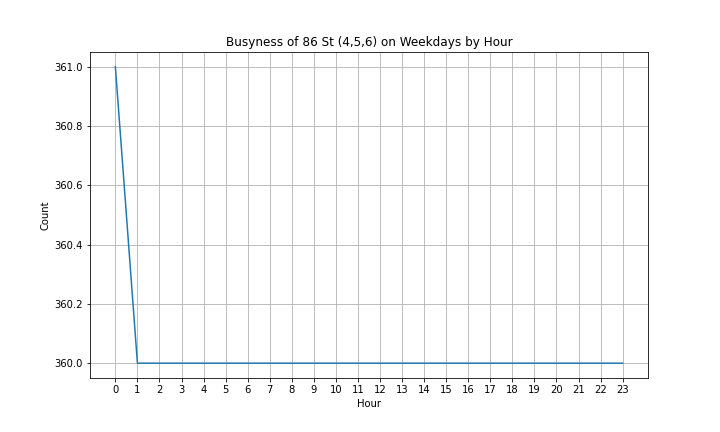
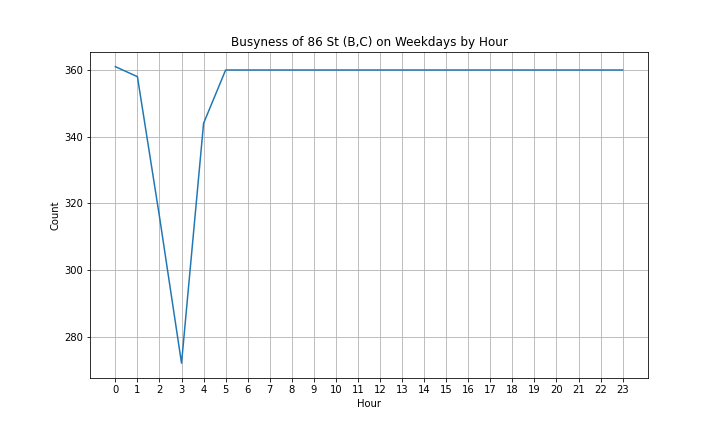
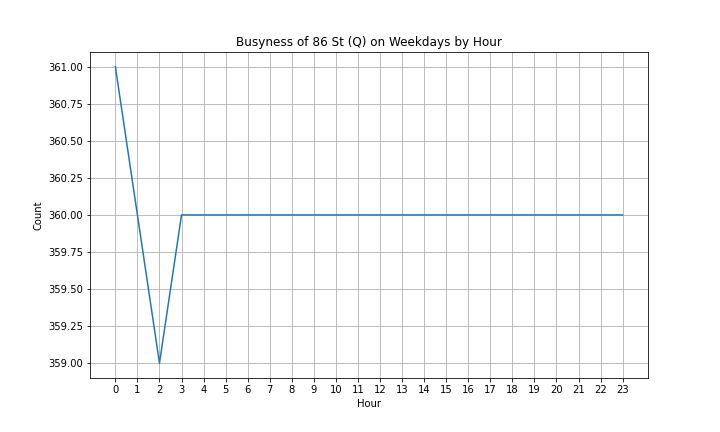
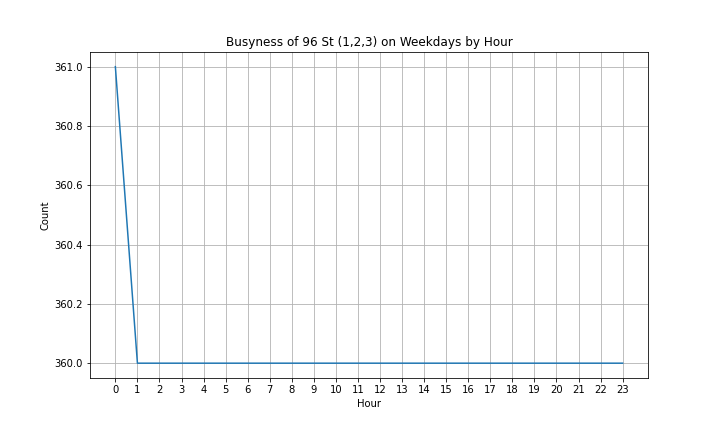
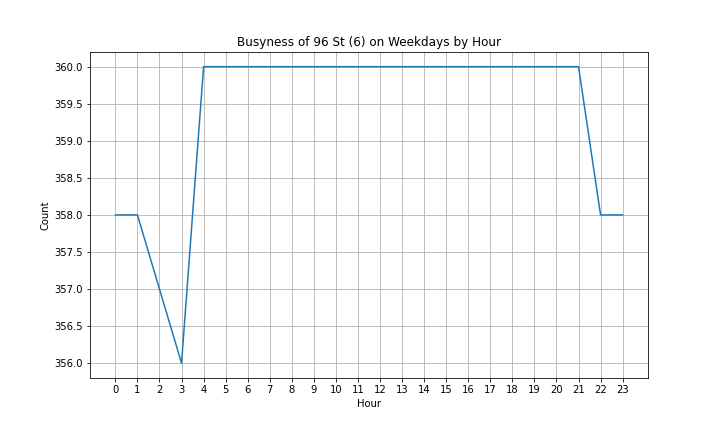
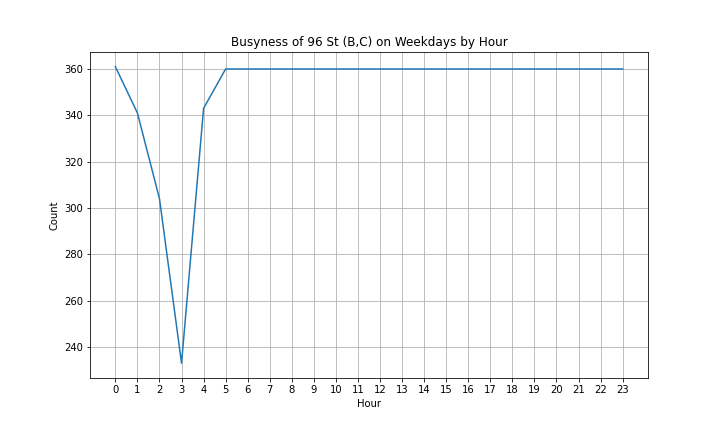
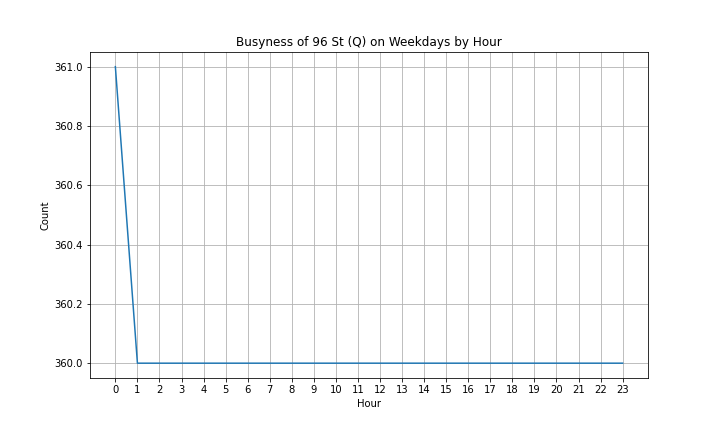
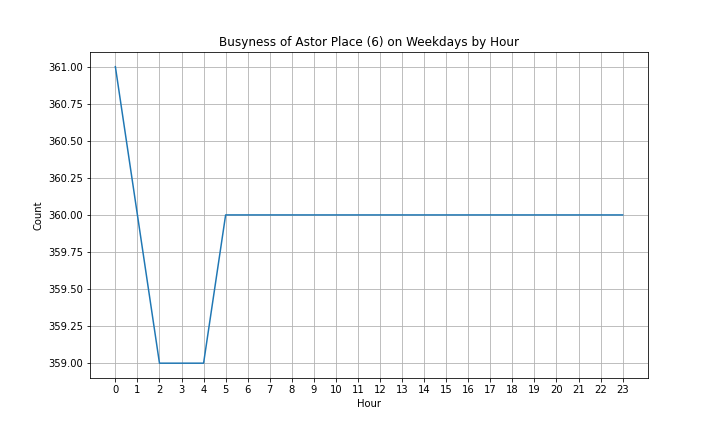
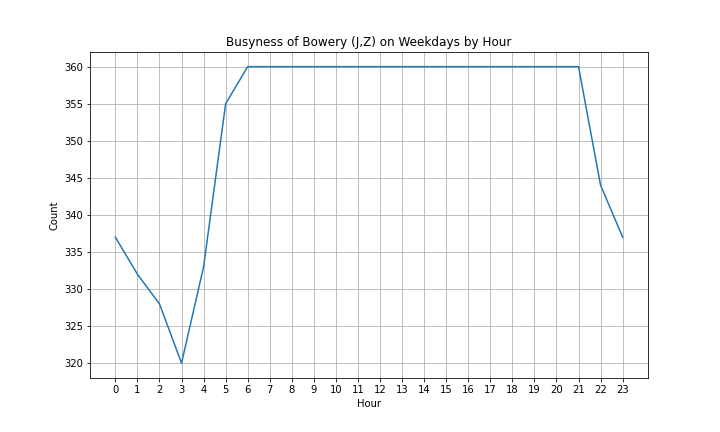
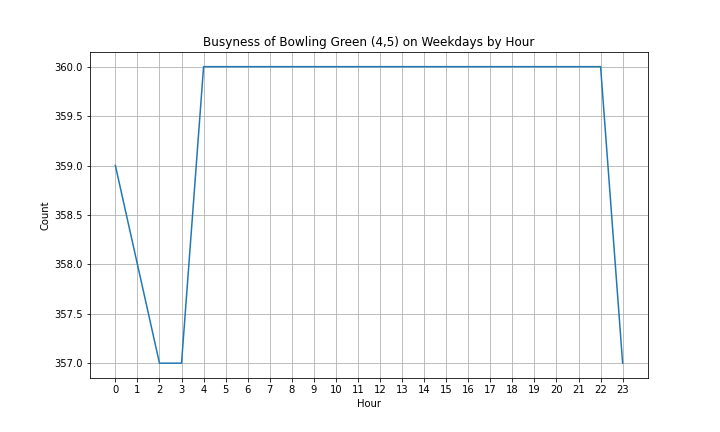
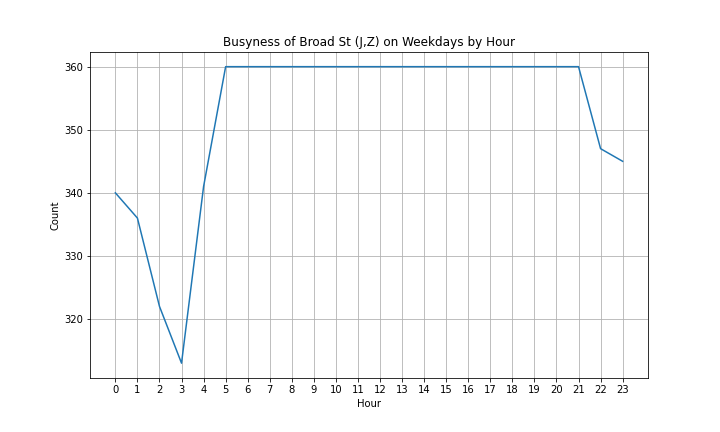
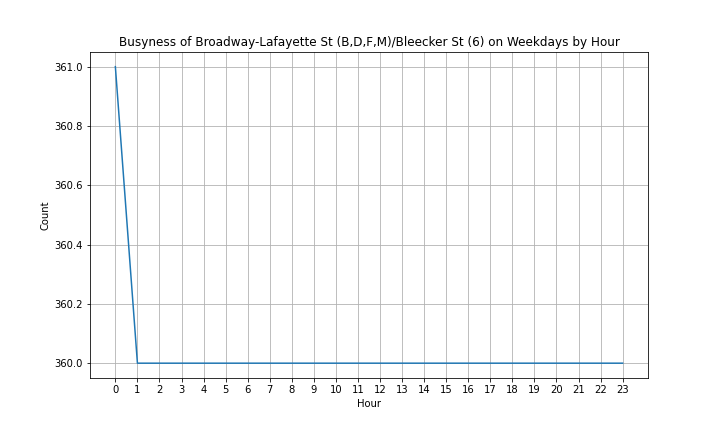
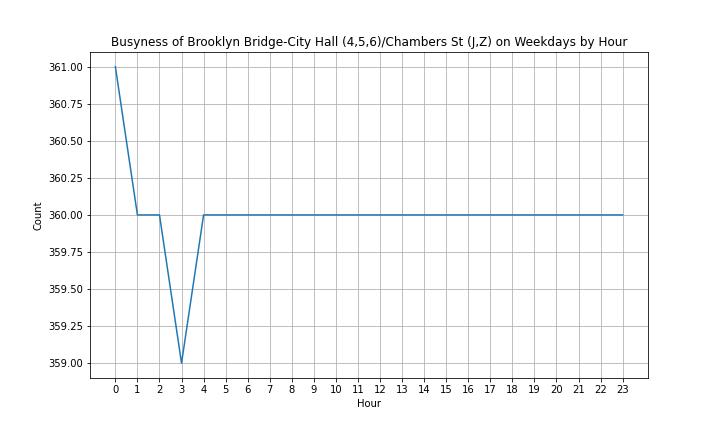
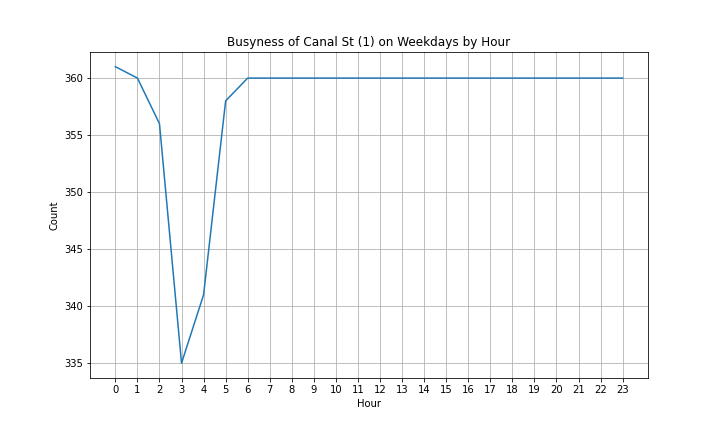
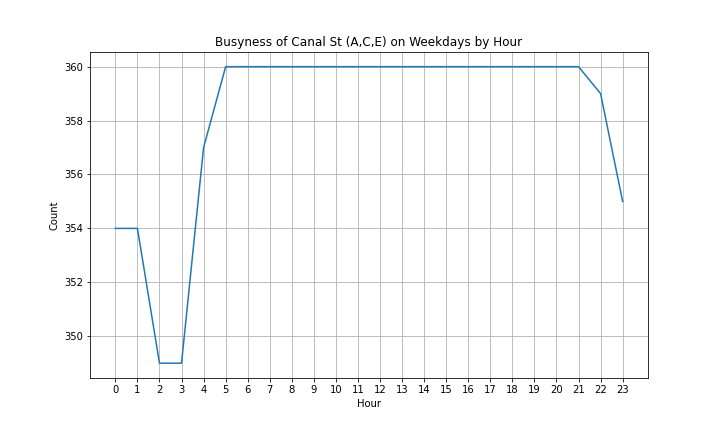
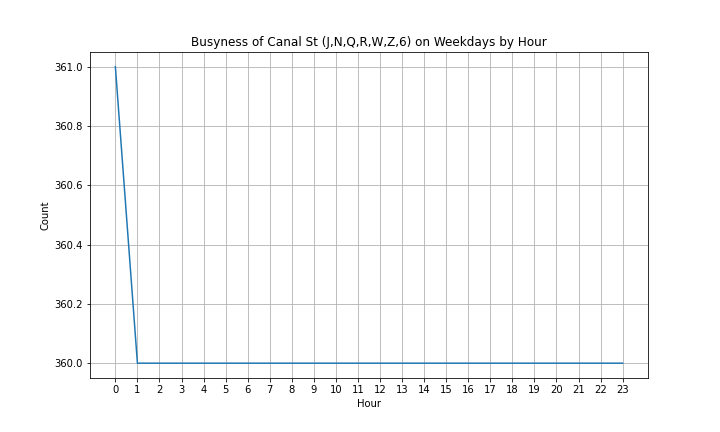
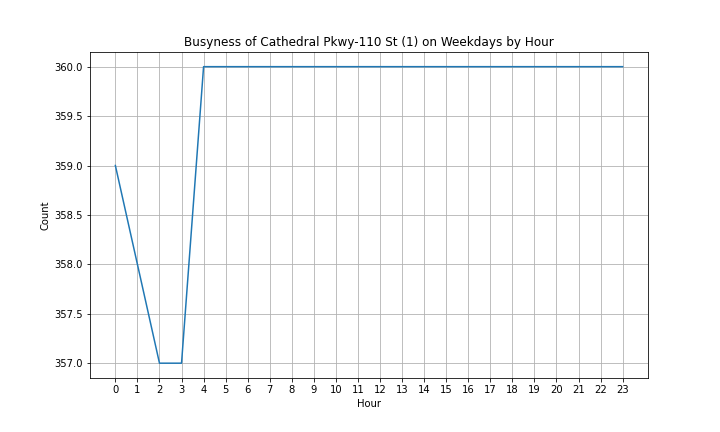
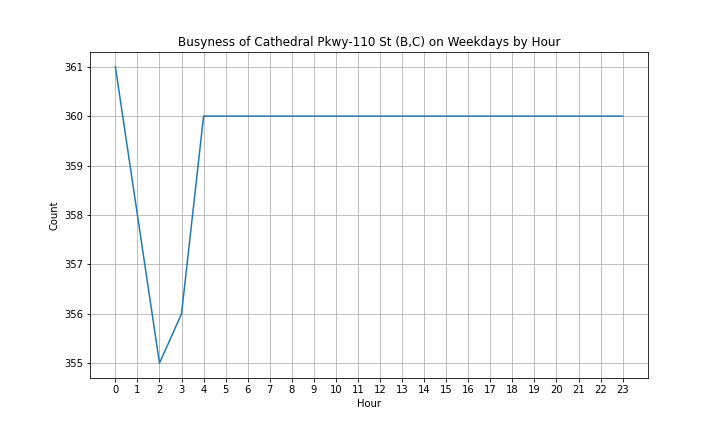
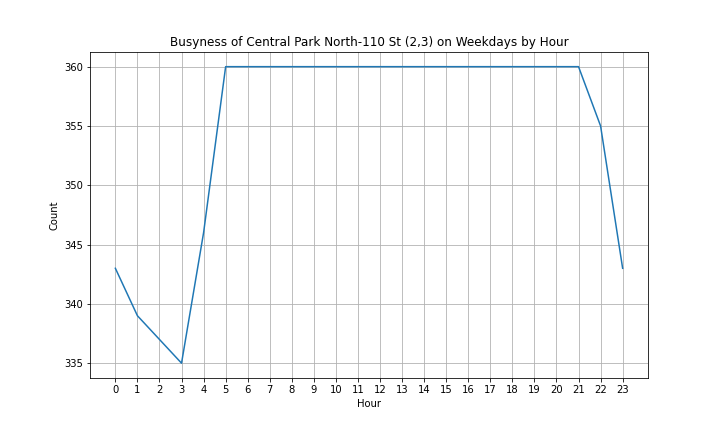
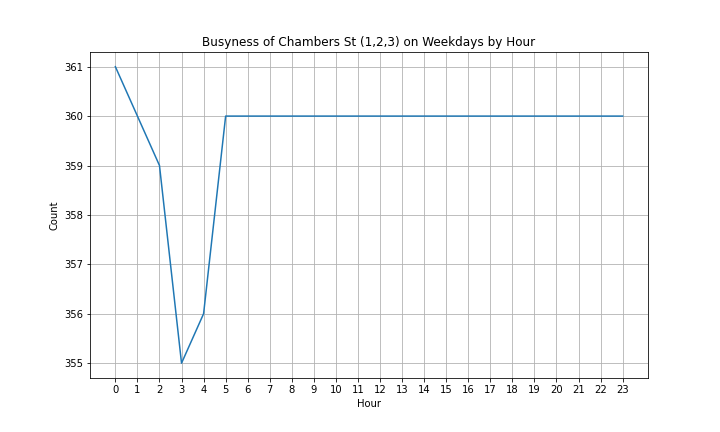
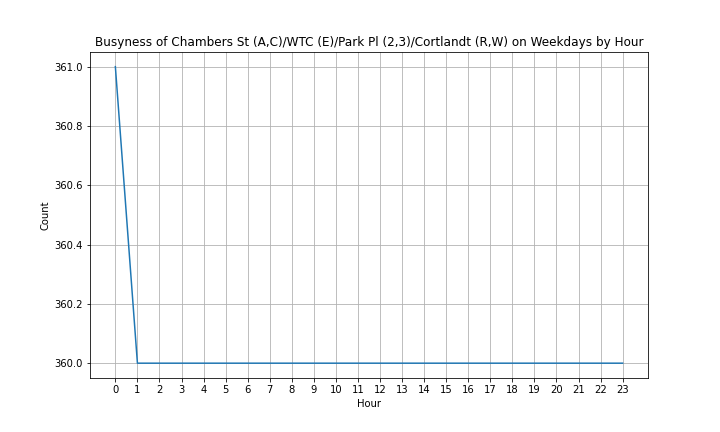
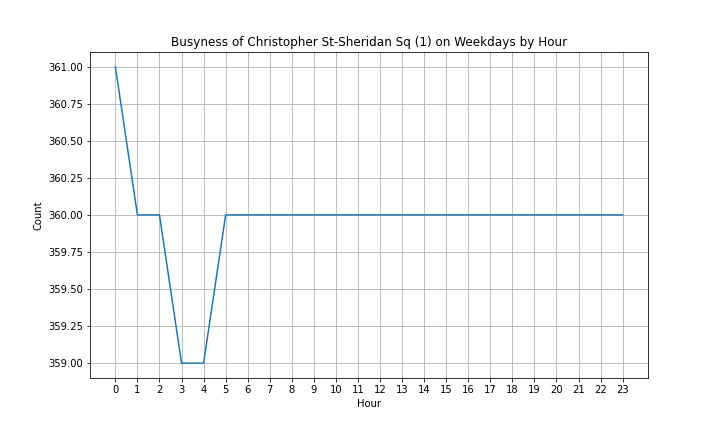
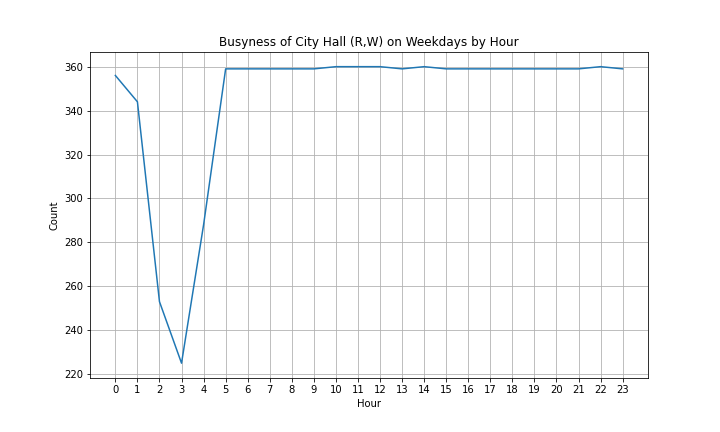
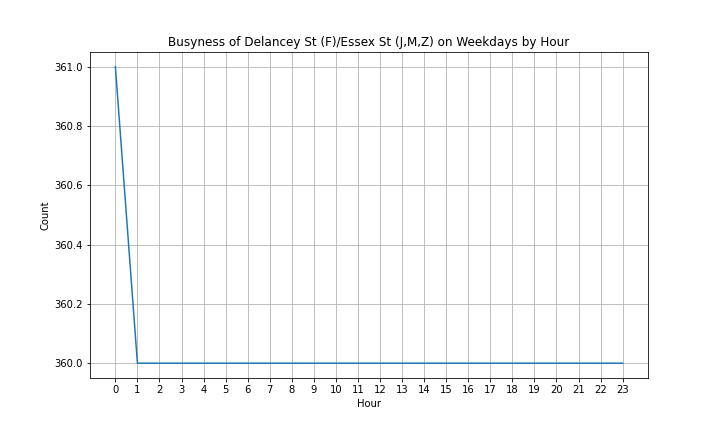
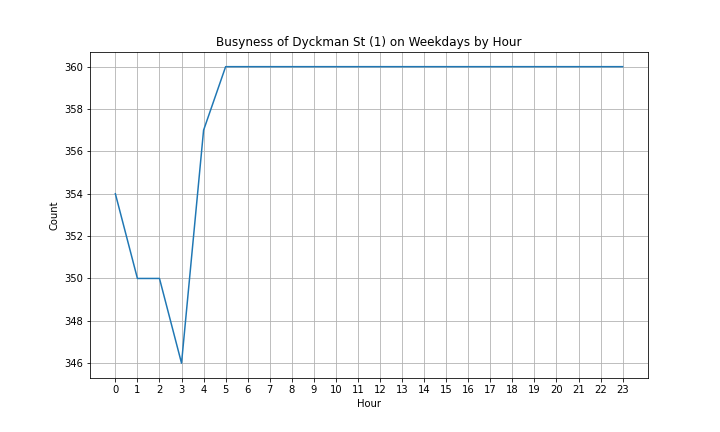
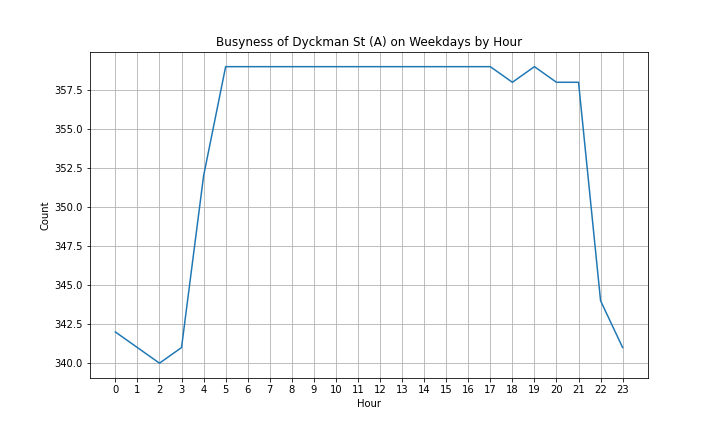
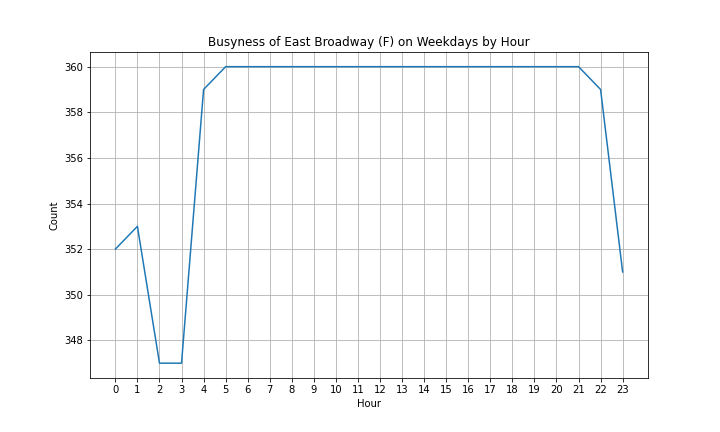
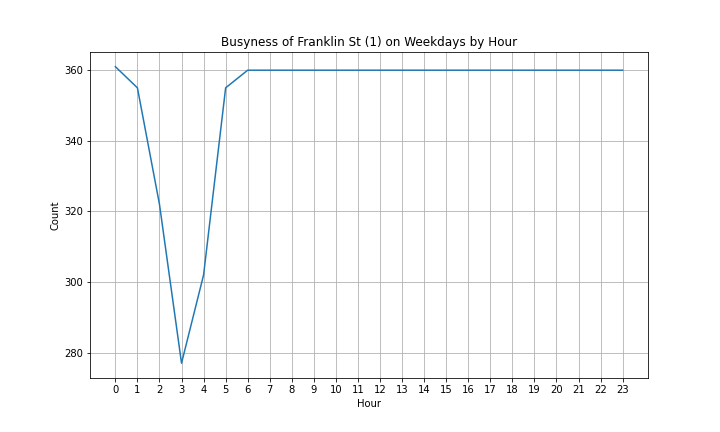
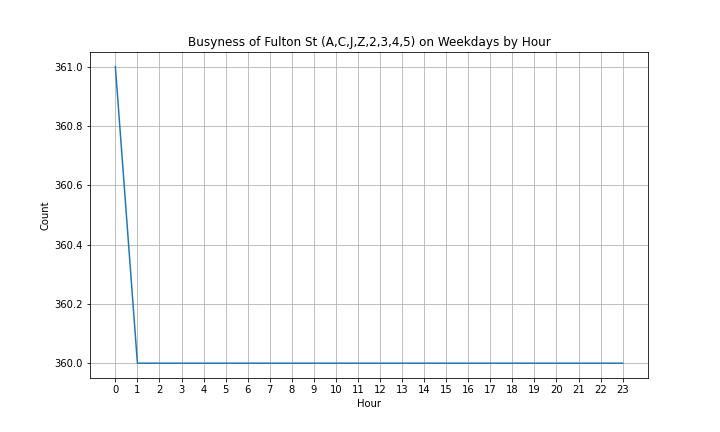
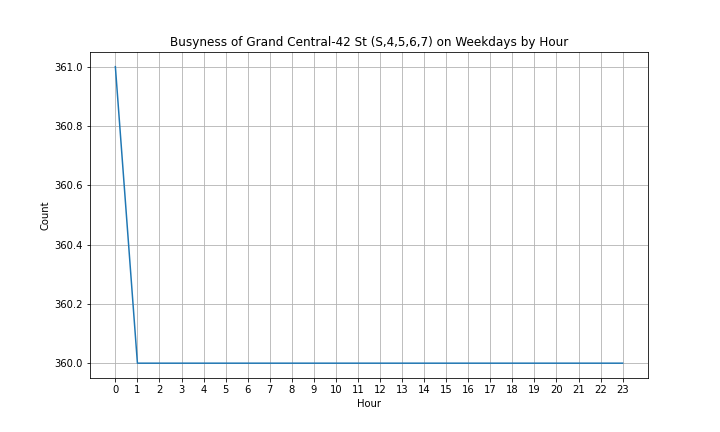
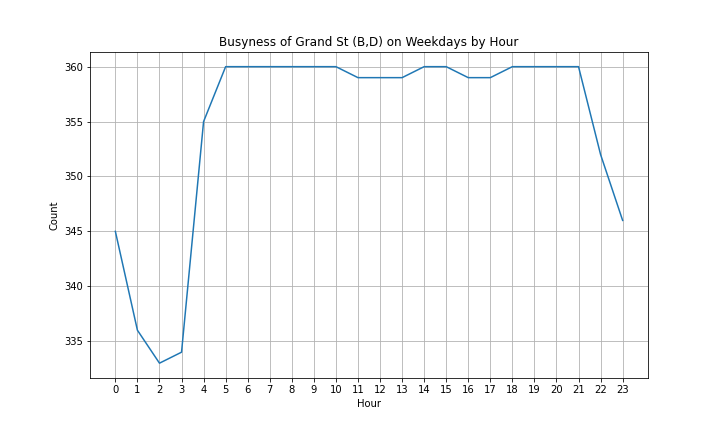
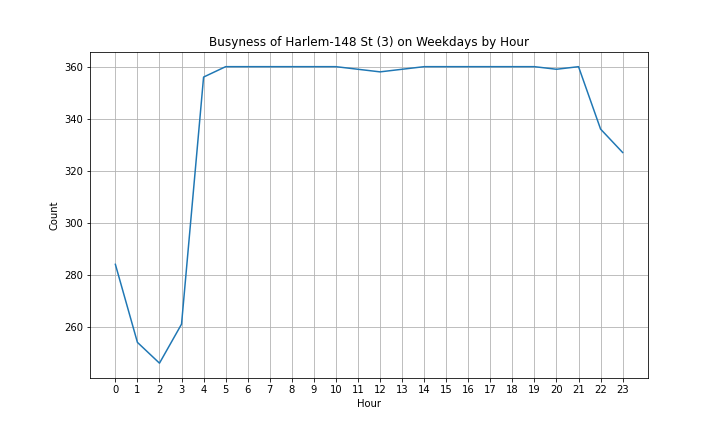
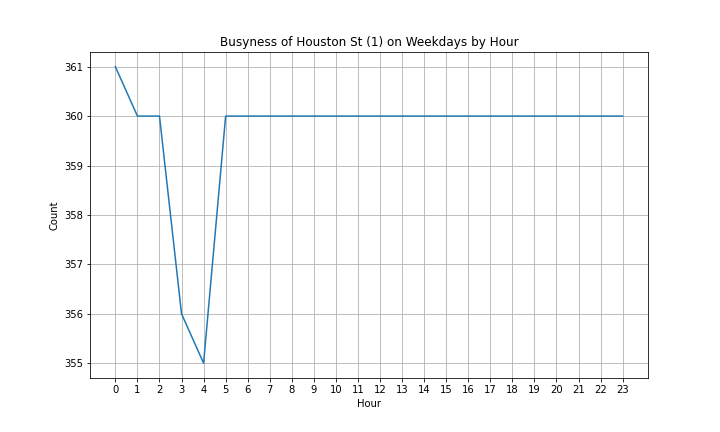
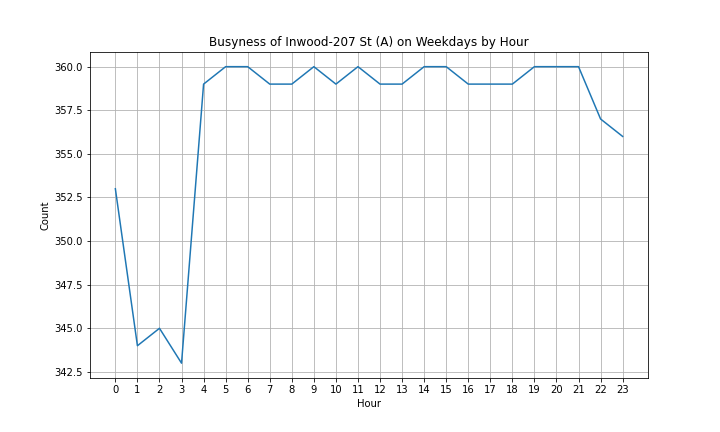
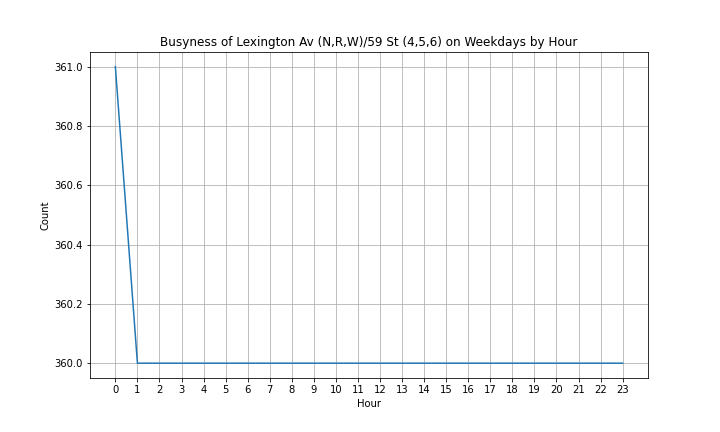
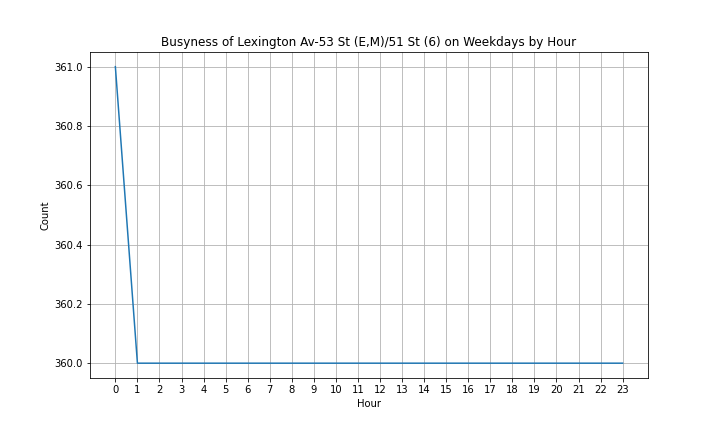
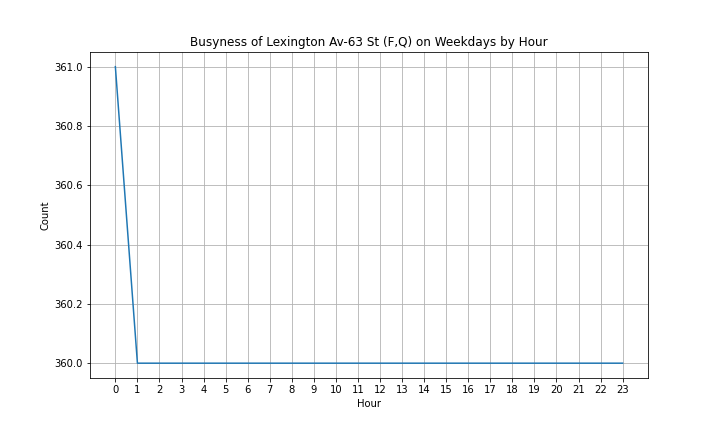
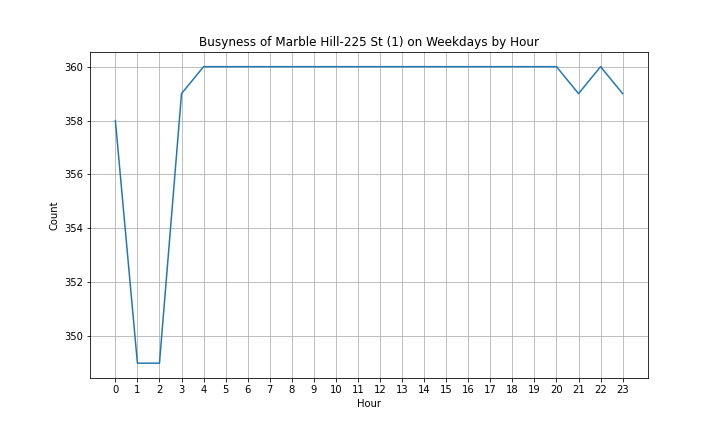
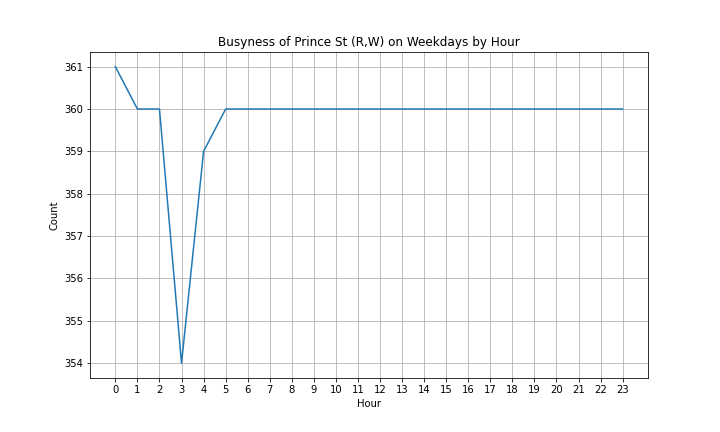
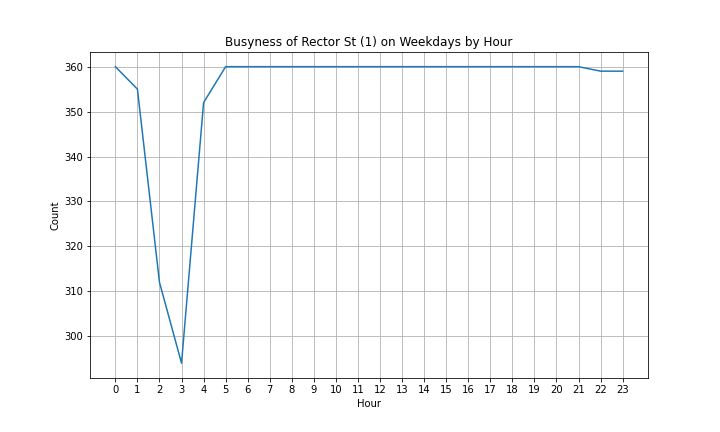
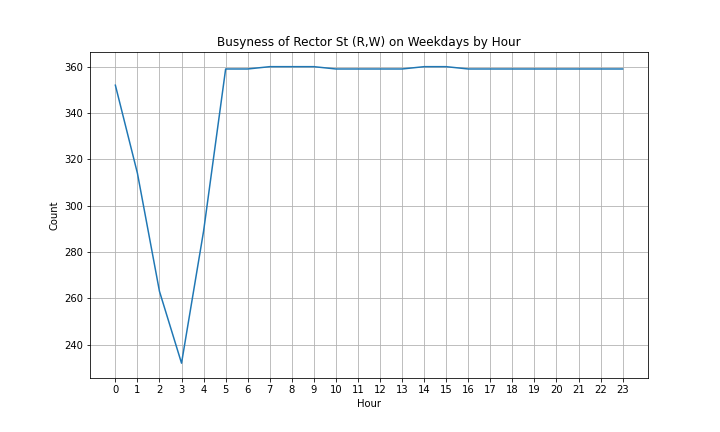
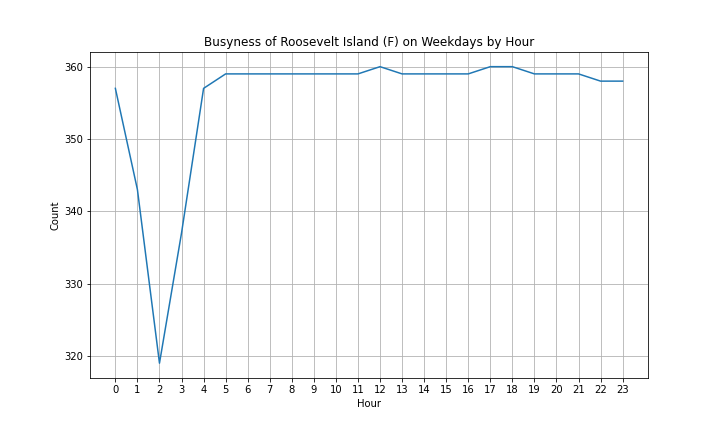
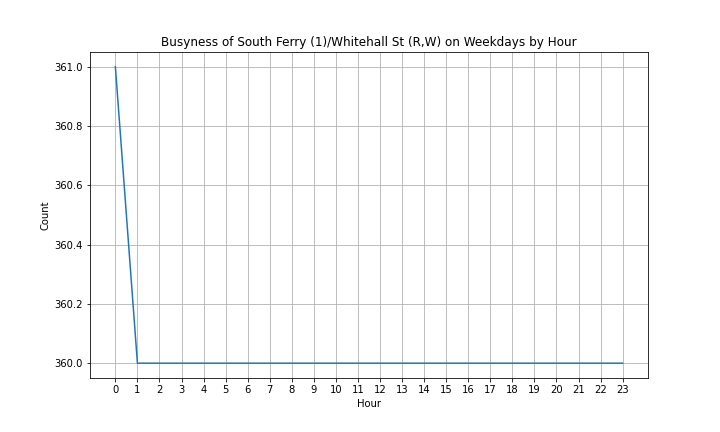
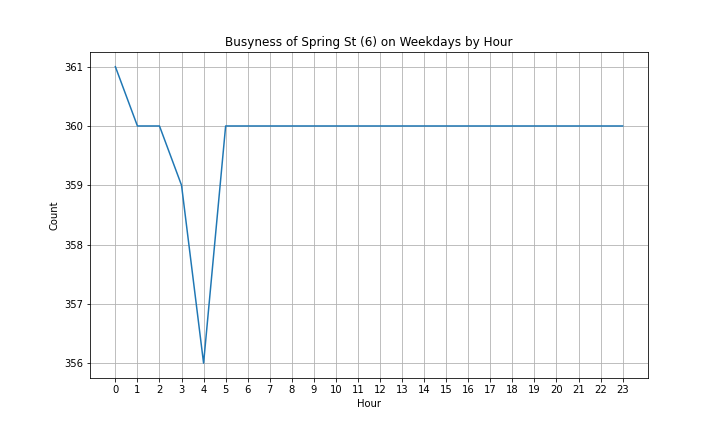
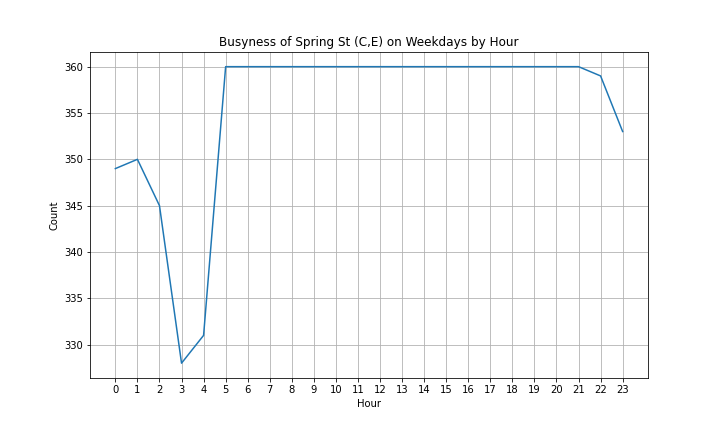
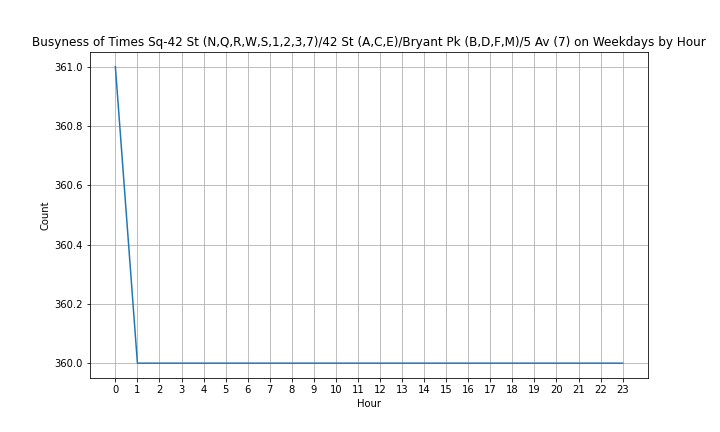
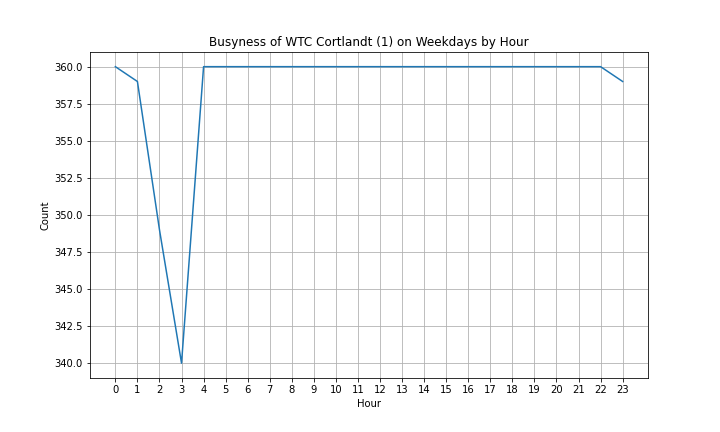
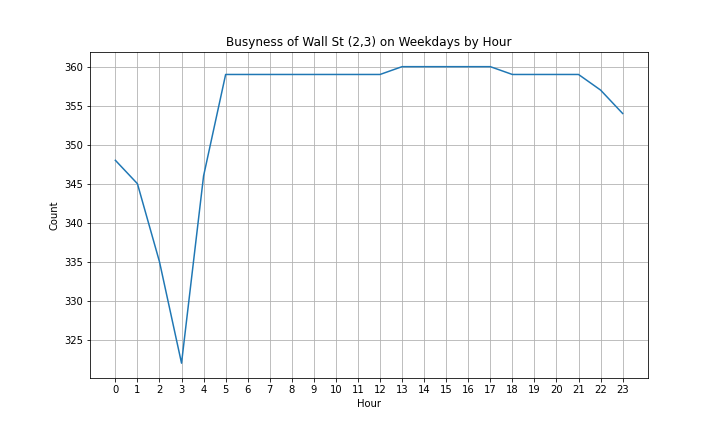
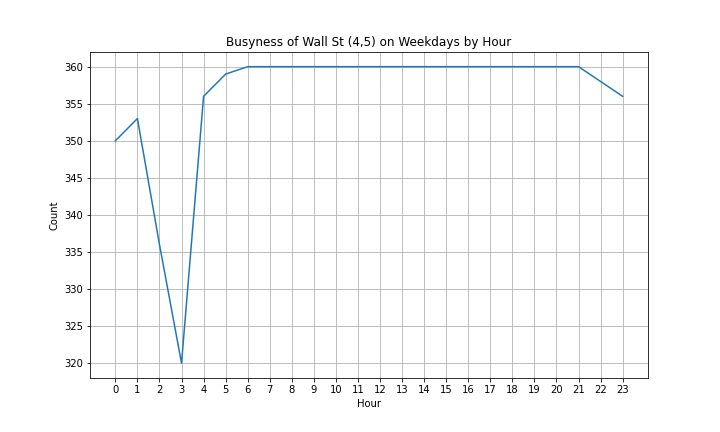
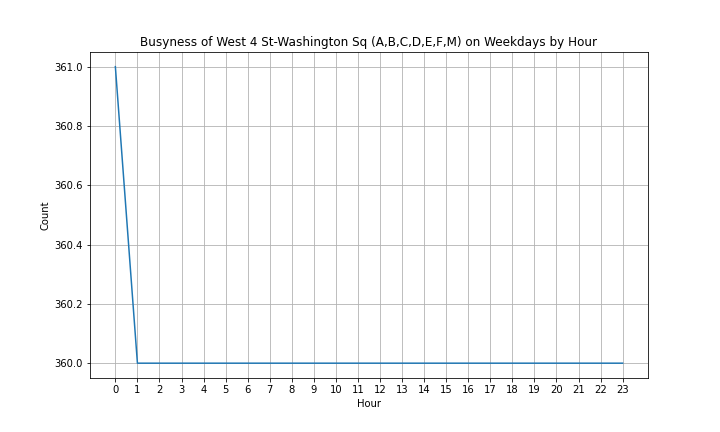

In [35]:
# Specify the width for the images in the popups
image_width = 300

# Iterate over unique station complexes
for station_complex in result['station_complex'].unique():
    # Get the latitude and longitude for the current station complex from the df DataFrame
    station_data = df[df['station_complex'] == station_complex]
    if len(station_data) > 0:
        station_lat = station_data['latitude'].iloc[0]
        station_lon = station_data['longitude'].iloc[0]

        # Add unique location to the set
        unique_locations.add((station_lat, station_lon))

        # Get the base64 encoded image from the dictionary
        image_base64 = station_complex_images[station_complex]

        # Construct the popup content with the base64 encoded image and set the image width
        popup_content = f'<img src="data:image/png;base64,{image_base64}" alt="Graph" width="{image_width}px">{station_complex}'

        # Create a marker on the map for the current station complex
        folium.Marker(location=[station_lat, station_lon],
                      icon=folium.Icon(color='green'),
                      popup=popup_content).add_to(map)

# Display the map
map

In [36]:
# Assuming you have defined these variables in the 'subwayvisualitions.ipynb' notebook
%store station_complex_images
%store unique_locations


Stored 'station_complex_images' (dict)
Stored 'unique_locations' (set)
